# Deep Learning Project


#### Author: Khizer Zakir


# 1. Data Characteristics

## 1.1. Learning task

The learning task to be solved is a supervised time-series classification, where the objective is to train deep learning models using time-series data to classify different crops. The input data consists of time-series observations for each crop, with features representing band reflectance values of the crops over time. The goal is to develop models capable of accurately predicting the crop type or class for new, unseen time-series observations~`test_data`.

**Recommended models**
 - MLP (MultiLayer Perceptron)
 - LSTM (Long Short Term Memory)
 - 1D-CNN (1-Dimensional Convolution Neural Network)

**Note** Looking at the class distribution:

- We will also try to run the model through a all classes
- We will try to drop the minority classes - This is another potential approach. You can drop all the `X-values` w.r.t the associated `y-labels` and train models on the revised data.

In this notebook, we are going to focus only on:
- all the labels and;
- dropped labels

Moreover, we will try 3 different versions for 2 DL models. MLP will work as a baseline model, while LSTM will be evaluated as a comparison.

__Version1__: Default parameters

__version2__: Hyperparameter tuning

__Version3__: Network tuned on the best model from version two

## 1.2. Dataset

The dataset used for this project is a subset of the TimeMatch dataset. The dataset consists of sequences of Sentinel-2 images collected in four areas: two in France, one in Denmark, and one in Austria. The task is crop-type identification from multi-spectral temporal profiles [DOI](https://doi.org/10.1016/j.isprsjprs.2022.04.018). In this notebook, we will focus on the dataset collected for western France.

In [34]:
# load libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from textwrap import dedent
from prettytable import PrettyTable
from collections import Counter

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid
from itertools import product


import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim


import time
import warnings

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# load the data from Gdrive/local computer if running locally "setpath"

path = '/content/drive/MyDrive/DL_final/data_FR1.npz'

data = np.load(path, allow_pickle=True)
series = data['series'] # time series (m,l,d) where m is the number of time series in a given domain,
## l is the length of the time series, and d is the number of channels in the image
labels = data['labels'] # label associated with each time series
dates = data['dates'] # acquisition dates (datetime package)
class_names = data['class_names'] # names of the class

The 3-D array of `series` will be used as the X - explanatory variable(s) in this learning task. While the labels will be addressed as the Y - target variable.

### 1.2.1. Features in the dataset and their type





In [37]:
# exploring the datatype within the series for each Dim

m_dtype = type(series.shape[0])
l_dtype = type(series.shape[1])
d_dtype = type(series.shape[2])
date_type = type(dates.shape[0])
label_type = type(labels.shape[0])

print(dedent(f'''
    Dataset information:
        Series:
            Shape: {data['series'].shape}
            Type: {type(data['series'])}
            Datatype of '# of time series': {m_dtype}
            Datatype of 'length of time series': {l_dtype}
            Datatype of 'bands': {d_dtype}

        Labels:
            Shape: {data['labels'].shape}
            Type: {type(data['labels'])}
            Datatype of 'labels': {label_type}

        Dates:
            Shape: {data['dates'].shape}
            Type: {type(data['dates'])}
            Datatype of 'Dates': {date_type}
'''))



Dataset information:
    Series:
        Shape: (115755, 62, 10)
        Type: <class 'numpy.ndarray'>
        Datatype of '# of time series': <class 'int'>
        Datatype of 'length of time series': <class 'int'>
        Datatype of 'bands': <class 'int'>

    Labels:
        Shape: (115755,)
        Type: <class 'numpy.ndarray'>
        Datatype of 'labels': <class 'int'>

    Dates:
        Shape: (62,)
        Type: <class 'numpy.ndarray'>
        Datatype of 'Dates': <class 'int'>



There are a total of **115755** time-series observations that encapsulates values of **10** features - bands in this case for **62** time-stamps.

For this problem, I have decided not to normalize the data just yet but only try for data cleaning if necessary. From the first glance and some heuristics, I have discovered that there are no NA values; however, there are numerous series with straight **0** for all the explanatory features (bands).

Removal of arrays with **0** values will create a dimension imbalance in this intricate timeseries data. Moreover, normalizing it now can lead to data leakage as the machine would be informed about the whole dataset and it can lead to over-optimistic results and unrealistic performance evaluations. Therefore, I would like to delay the normalization until we have the `train_test_split`.

In [38]:
# print the first 10 entires of each array as a table
for key in data.keys():
    print(key, data[key][:10])

# Print the number of arrays in the file
print("Number of arrays in the npz file:", len(data.files))

series [[[1402.49338374 1126.42627599  959.62381853 ... 2678.14839319
   1868.51417769 1154.1852552 ]
  [1819.21833648 1535.08412098 1419.86294896 ... 2486.28071834
   1938.28733459 1566.50189036]
  [4289.48393195 3983.32514178 4381.01606805 ... 5779.60680529
   4808.35255198 3873.94517958]
  ...
  [1770.73251418 1410.17485822 1242.99338374 ... 2155.12570888
   1439.62381853 1157.06805293]
  [3800.17769376 3331.58884688 3392.48960302 ... 4122.67769376
   2896.60680529 1960.39981096]
  [1757.16635161 1530.21833648 1414.52741021 ... 3226.85727788
   1779.05765595 1167.76559546]]

 [[1336.49818182 1004.34909091  933.93454545 ... 1767.37454545
   2129.90909091 1372.13090909]
  [1235.45818182  981.16727273  936.85818182 ... 2039.72363636
   2270.54545455 1289.15272727]
  [1093.17818182  756.67636364  622.78181818 ... 1063.64
   1145.47636364  678.15636364]
  ...
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [6453.54181818 6088.46181818 6695.9490909

### 1.2.2. Descriptive statistics for quantitative explanatory variables

In [39]:
# Extract the third dimension of the series array for all features
quantitative_variables = series[:, :, :10]  # Assuming you want statistics for all 10 features

# Reshape the array to have features as the last dimension
quantitative_variables_reshaped = np.moveaxis(quantitative_variables, 2, 0)

# Create a DataFrame for descriptive statistics
statistics_df = pd.DataFrame({
    f'Feature_{i + 1}': [
        len(quantitative_variables_reshaped[i]),
        np.mean(quantitative_variables_reshaped[i]),
        np.median(quantitative_variables_reshaped[i]),
        np.std(quantitative_variables_reshaped[i]),
        np.min(quantitative_variables_reshaped[i]),
        np.max(quantitative_variables_reshaped[i])
    ]
    for i in range(quantitative_variables_reshaped.shape[0])
}, index=['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max'])

# Print the descriptive statistics table
print(statistics_df)

             Feature_1      Feature_2      Feature_3      Feature_4  \
Count    115755.000000  115755.000000  115755.000000  115755.000000   
Mean       2023.126302    1882.874282    1849.271764    3262.842927   
Median     1297.477469    1194.314119    1112.733634    3109.460952   
Std Dev    1866.139993    1780.241664    1966.758417    1990.396460   
Min           0.000000       0.000000       0.000000       0.000000   
Max       18558.623762   18710.485149   21519.457944   22403.448845   

             Feature_5      Feature_6      Feature_7      Feature_8  \
Count    115755.000000  115755.000000  115755.000000  115755.000000   
Mean       2114.806816    2954.983318    3360.753526    3592.527791   
Median     1455.491987    2681.168640    3191.490566    3508.218775   
Std Dev    1940.185595    1934.058284    2039.875270    2089.218729   
Min           0.000000       0.000000       0.000000       0.000000   
Max       21990.607477   22588.523364   23273.934579   24001.890000   

    

In [40]:

# Extract the third dimension of the series array for all features
quantitative_variables = series[:, :, :10]  # Assuming you want statistics for all 10 features

# Normalize by dividing with 1000
quantitative_variables_normalized = quantitative_variables/10000

# Reshape the array to have features as the last dimension
quantitative_variables_reshaped = np.moveaxis(quantitative_variables_normalized, 2, 0)

# Create a DataFrame for descriptive statistics
statistics_df = pd.DataFrame({
    f'Feature_{i + 1}': [
        len(quantitative_variables_reshaped[i]),
        np.mean(quantitative_variables_reshaped[i]),
        np.median(quantitative_variables_reshaped[i]),
        np.std(quantitative_variables_reshaped[i]),
        np.min(quantitative_variables_reshaped[i]),
        np.max(quantitative_variables_reshaped[i])
    ]
    for i in range(quantitative_variables_reshaped.shape[0])
}, index=['Count', 'Mean', 'Median', 'Std Dev', 'Min', 'Max'])

# Print the normalized descriptive statistics table
print(statistics_df)


             Feature_1      Feature_2      Feature_3      Feature_4  \
Count    115755.000000  115755.000000  115755.000000  115755.000000   
Mean          0.202313       0.188287       0.184927       0.326284   
Median        0.129748       0.119431       0.111273       0.310946   
Std Dev       0.186614       0.178024       0.196676       0.199040   
Min           0.000000       0.000000       0.000000       0.000000   
Max           1.855862       1.871049       2.151946       2.240345   

             Feature_5      Feature_6      Feature_7      Feature_8  \
Count    115755.000000  115755.000000  115755.000000  115755.000000   
Mean          0.211481       0.295498       0.336075       0.359253   
Median        0.145549       0.268117       0.319149       0.350822   
Std Dev       0.194019       0.193406       0.203988       0.208922   
Min           0.000000       0.000000       0.000000       0.000000   
Max           2.199061       2.258852       2.327393       2.400189   

    

### 1.2.3 Class distribution

The idea was to understand the distribution of labels in the dataset. If they do not qualify to be part of the network we either remove the classes or merge them as a minority class.

#### All Classess

In [41]:
# checking the class distribution to strategize for later parts

if 'class_names' in data and 'labels' in data:
    class_names = data['class_names'][:]
    labels = data['labels'][:]

     # Count occurrences of each label
    count_table = PrettyTable()
    count_table.field_names = ["Label", "Class Name", "Count"]
    unique_labels, counts = np.unique(labels, return_counts=True)

    for label, class_name, count in zip(unique_labels, class_names, counts):
        count_table.add_row([label, class_name, count])

    print("Label Counts:")
    print(count_table)

    # Check the length of class names and unique labels
    print("Length of Class Names:", len(class_names))
    print("Length of Labels:", len(np.unique(labels)))

else:
    print("Either 'class_names' or 'labels' array does not exist in the npz file.")


Label Counts:
+-------+------------------+-------+
| Label |    Class Name    | Count |
+-------+------------------+-------+
|   0   |       corn       | 19088 |
|   1   |    horsebeans    |  462  |
|   2   |      meadow      | 52537 |
|   3   |  spring_barley   |  390  |
|   4   |    spring_oat    |   41  |
|   5   |   spring_peas    |  277  |
|   6   | spring_rapeseed  |   10  |
|   7   |    spring_rye    |   1   |
|   8   | spring_triticale |   3   |
|   9   |   spring_wheat   |   32  |
|   10  |    sunflowers    |  1270 |
|   11  |     unknown      |  9510 |
|   12  |  winter_barley   |  4083 |
|   13  |    winter_oat    |  435  |
|   14  |   winter_peas    |   79  |
|   15  | winter_rapeseed  |  3809 |
|   16  |    winter_rye    |   51  |
|   17  | winter_triticale |  2687 |
|   18  |   winter_wheat   | 20990 |
+-------+------------------+-------+
Length of Class Names: 19
Length of Labels: 19


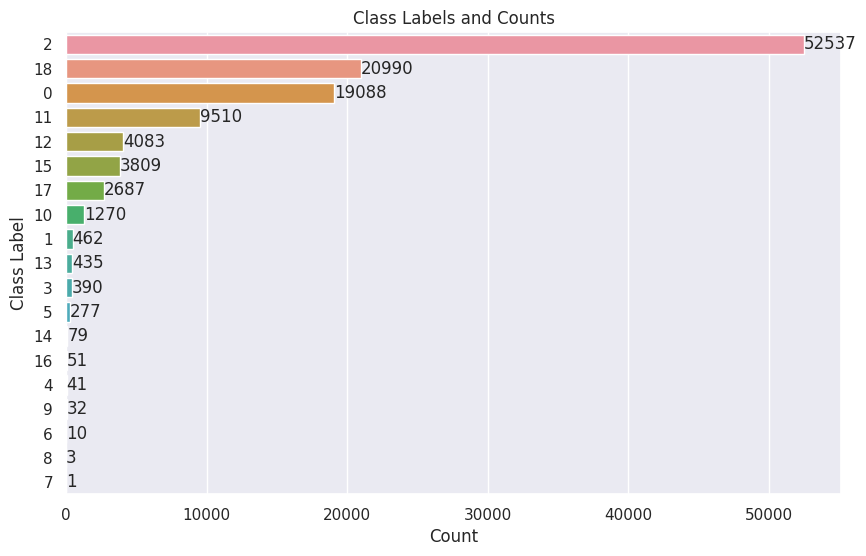

In [42]:

sorted_indices = np.argsort(counts)[::-1]
unique_labels_sorted = unique_labels[sorted_indices]
counts_sorted = counts[sorted_indices]

# Create a bar plot for class labels and counts
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))
ax = sns.countplot(y=labels, order=unique_labels_sorted)  # Use the sorted order
ax.set(xlabel='Count', ylabel='Class Label')  # Adjust the labels
ax.set_title('Class Labels and Counts')

# Add counts on each bar
for i, count in enumerate(counts_sorted):
    ax.text(count + 0.1, i, f'{count}', ha='left', va='center')  # Adjust the position

plt.show()


**Interpretation**

This countplot represents the class distribution for al the classes available in this dataset. This gives a good understanding of what classes to drop as move forward. With observations, less than 100, they would only create noise in the dataset and harm the accuracy. Imagine there are only 1 observation for the `label:7`, with only 1:62 - it cannot be distributed among train_val_test effectively to be learned by the model.

#### After Dropped Classess

In [43]:
# Create a PrettyTable for minority classes
minority_classes_table = PrettyTable()
minority_classes_table.field_names = ["Label", "Class Name", "Count"]

#classes having counts less than 100
minority_classes = [(label, class_name, count) for label, class_name, count in zip(unique_labels, class_names, counts) if count < 100]

#fo r pretty table
for label, class_name, count in minority_classes:
  minority_classes_table.add_row([label, class_name, count])
print("Classes with Counts Less Than 100:")
print(minority_classes_table)


Classes with Counts Less Than 100:
+-------+------------------+-------+
| Label |    Class Name    | Count |
+-------+------------------+-------+
|   4   |    spring_oat    |   41  |
|   6   | spring_rapeseed  |   10  |
|   7   |    spring_rye    |   1   |
|   8   | spring_triticale |   3   |
|   9   |   spring_wheat   |   32  |
|   14  |   winter_peas    |   79  |
|   16  |    winter_rye    |   51  |
+-------+------------------+-------+


The labels shown in the table above, have the lowest counts in the y-label distribution. We are considering them as the `minority_classes`. We will try to merge them as one class and see if it affects the accuracy of the model or not.

In [44]:
# Filter indices
minority_classes_labels = [label for label, _, _ in minority_classes]
non_minority_indices = np.where(~np.isin(labels, minority_classes_labels))[0] # everythin that is not minority

# new data without minority classes

X_new = series[non_minority_indices]
y_new = labels[non_minority_indices]

print(len(X_new))
print(len(y_new))

115538
115538


In [45]:
uniqu_vals = np.unique(y_new)
uniq_arr, uniq_tags = uniqu_vals, range(0, len(uniqu_vals))
mapping_dict = dict(zip(uniq_arr, uniq_tags))
y_upt = np.array(pd.Series(y_new).map(mapping_dict))
print(np.unique(y_upt))
print(y_upt.shape, X_new.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
(115538,) (115538, 62, 10)


In [46]:
np.unique(y_new)

array([ 0,  1,  2,  3,  5, 10, 11, 12, 13, 15, 17, 18], dtype=int32)

### Double_checking the indices

In [47]:
### [Took help from AI for this cell]

### did not help went back to documentation and redid it in the cell above

# Rearrange the indices for both trimmed series and labels to start from 0
X_new_t = np.array([X_new[original_index] for original_index in range(len(X_new))])
y_new_t = np.array([y_new[original_index] for original_index in range(len(y_new))])

label_mapping_trimmed = {old_label: new_label for new_label, old_label in enumerate(np.unique(y_new_t))}

# Apply the mapping to remap the trimmed labels
y_new_t_r = np.array([label_mapping_trimmed[label] for label in y_new_t])
X_new_t_consecutive = np.array([X_new_t[i] for i in range(len(X_new_t))])
y_new_t_r_consecutive = np.array([y_new_t_r[i] for i in range(len(y_new_t_r))])

# Display the length of the rearranged series and labels
length_X_new_t_consecutive = len(X_new_t_consecutive)
length_y_new_t_r_consecutive = len(y_new_t_r_consecutive)
print("Length of Rearranged Trimmed Series:", length_X_new_t_consecutive)
print("Length of Rearranged Trimmed Labels:", length_y_new_t_r_consecutive)

# Print the index and first 10 samples of the rearranged trimmed series and labels
print("Index and First 10 Samples of Rearranged Trimmed Series and Labels:")
for i in range(10):
    print(f"Index {i} - Label: {y_new_t_r_consecutive[i]}, Series Index: {i}")


Length of Rearranged Trimmed Series: 115538
Length of Rearranged Trimmed Labels: 115538
Index and First 10 Samples of Rearranged Trimmed Series and Labels:
Index 0 - Label: 2, Series Index: 0
Index 1 - Label: 6, Series Index: 1
Index 2 - Label: 0, Series Index: 2
Index 3 - Label: 7, Series Index: 3
Index 4 - Label: 11, Series Index: 4
Index 5 - Label: 2, Series Index: 5
Index 6 - Label: 6, Series Index: 6
Index 7 - Label: 6, Series Index: 7
Index 8 - Label: 2, Series Index: 8
Index 9 - Label: 6, Series Index: 9


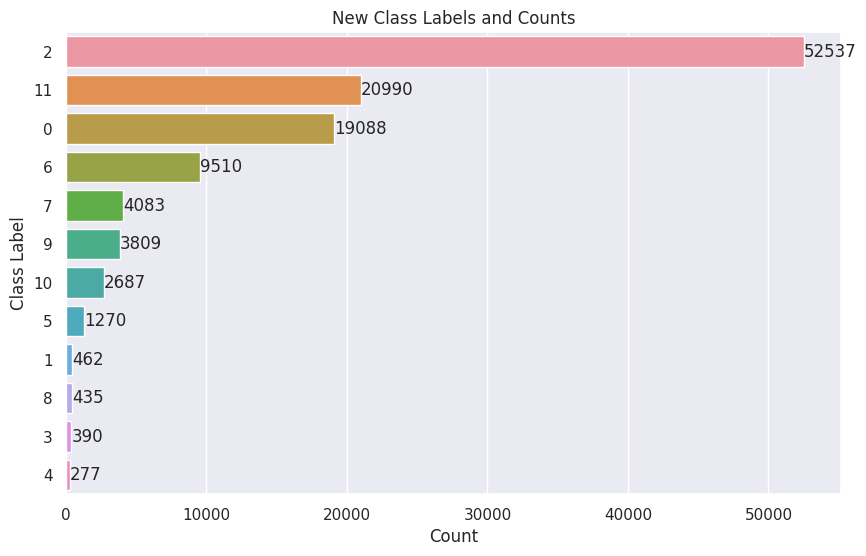

In [48]:
unique_labels, counts = np.unique(y_new_t_r_consecutive, return_counts=True)
sorted_indices = np.argsort(counts)[::-1]
unique_labels_sorted = unique_labels[sorted_indices]
counts_sorted = counts[sorted_indices]

# Create a bar plot for class labels and counts
sns.set(style='darkgrid')
plt.figure(figsize=(10, 6))
ax = sns.countplot(y=y_new_t_r_consecutive, order=unique_labels_sorted)  # Use the sorted order
ax.set(xlabel='Count', ylabel='Class Label')  # Adjust the labels
ax.set_title('New Class Labels and Counts')

# Add counts on each bar
for i, count in enumerate(counts_sorted):
    ax.text(count + 0.1, i, f'{count}', ha='left', va='center')  # Adjust the position

plt.show()



**Interpretation**

This plot shows the classes that have more than 100 observations and are fit enough to be considered as a potential class.

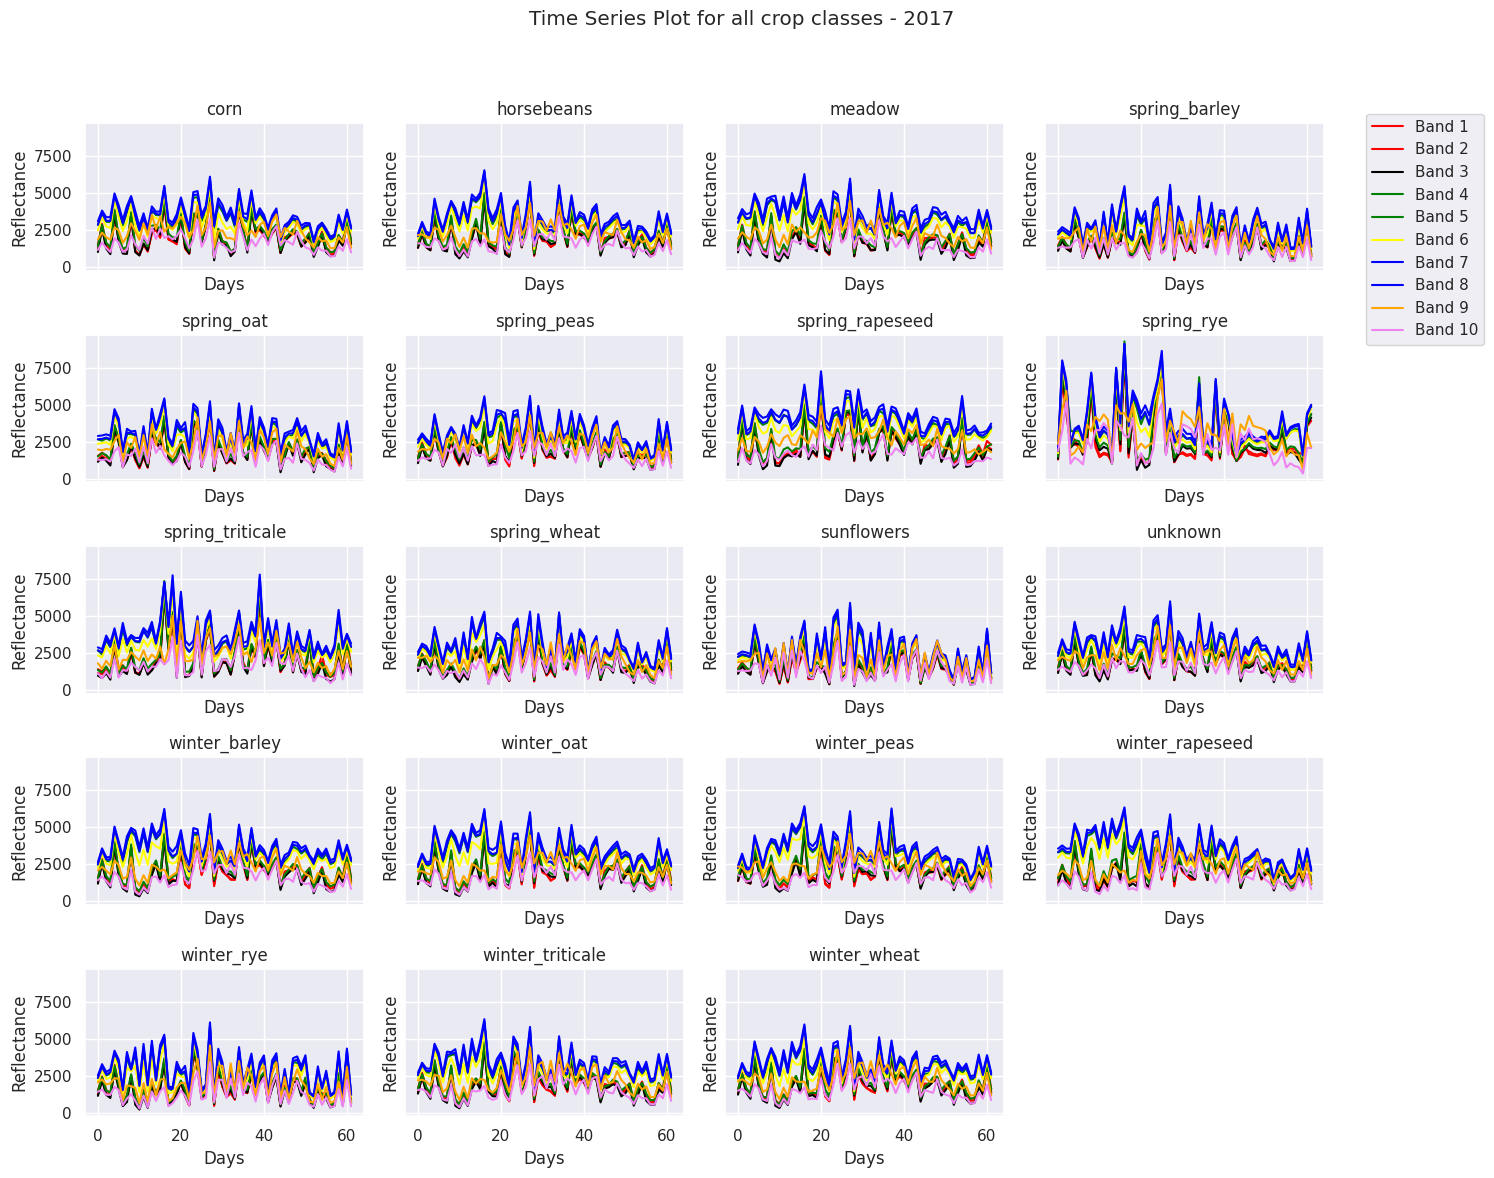

In [49]:

# Replace label names with class names
mapped_labels = np.array([class_names[label] for label in labels])
unique_class_names = np.unique(mapped_labels)

# the number of bands
num_bands = series.shape[2]

# custom colormap
custom_colors = ['red', 'black', 'green', 'yellow', 'blue', 'orange', 'violet']
cmap = ListedColormap(custom_colors)

# Plot
fig, axes = plt.subplots(len(unique_class_names)//4 + 1, 4, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Plot for each class
for i, class_name in enumerate(unique_class_names):
    indices = np.where(mapped_labels == class_name)[0]
    mean_reflectance = series[indices].mean(axis=0)  # Mean over the first dimension (observations)

    # Plot each band with a color from the custom colormap
    for band in range(num_bands):
        color = cmap(band / num_bands)
        axes[i].plot(mean_reflectance[:, band], label=f'Band {band + 1}', color=color)

    # labels & titles
    axes[i].set_title(f'{class_name}')
    axes[i].set_ylabel('Reflectance')
    axes[i].set_xlabel('Days')

# Remove empty subplots
for j in range(len(unique_class_names), len(axes)):
    fig.delaxes(axes[j])

# Main Title
fig.suptitle('Time Series Plot for all crop classes - 2017')

# legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1, 0.9))

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


**Interpretation**

This is an extensive overview of how the band values are distributed across the dates stored in this dataset. In all honesty, this graph is of no help, as it gives away no distinct of significant information, all the bands have similar distribution. It was expected to be different for different type of crops.  

# 2. Data Preparation


The Dataset class has three important class functions:
 - __init__(): as usual, the starting point where we will initialize everything that we use in the class.
 - __len__(): this returns the length of the dataset. Simply this will return the number of samples in the dataset.
 - __getitem__(): this function returns a sample from the dataset when we provide an index value to it.

 [pytorch_Documentation](https://pytorch.org/vision/main/datasets.html)

This is the most fundamental stage of the process, where you prepare the data according to the architecture/nature of your network or learn from the data to design/architect the networks repectively.

## 2.1. Custom Dataset Class

In [50]:
class TimeSeriesDataset(Dataset):
    def __init__(self, series, labels, transform=None):
        # Convert to torch tensors internally
        self.series = torch.tensor(series, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        series_sample = self.series[idx]
        label_sample = self.labels[idx]

        if self.transform:
            series_sample = self.transform(series_sample)

        return series_sample, label_sample


### 2.1.1. Transform class

This is the normalization technique that will be used for this dataset

In [51]:

class MinMaxScalerTransform:
    def __init__(self, min_vals, max_vals):
        self.min_vals = min_vals
        self.max_vals = max_vals

    def __call__(self, series_sample):
        # Apply the Min-Max scaling using stored min and max values
        series_transformed = (series_sample - self.min_vals) / (self.max_vals - self.min_vals)
        return series_transformed


### 2.1.2. Train|Val|Test Split

***NOTE*** Please make sure to use the same random_seed = 42

In [52]:

def split_dataset(series, labels, test_size=0.1, val_size=0.1, random_seed=42):
    # Split the dataset using train_test_split
    train_series, test_series, train_labels, test_labels = train_test_split(
        series, labels, test_size=test_size, random_state=random_seed
    )

    train_series, val_series, train_labels, val_labels = train_test_split(
        train_series, train_labels, test_size=val_size, random_state=random_seed
    )

    return train_series, val_series, test_series, train_labels, val_labels, test_labels


### 2.1.3. Transformed and Splitted Datasets

In [53]:

def create_transform_and_datasets(train_series, val_series, test_series, min_vals, max_vals):
    # Create the Min-Max scaler transform using min and max values
    transform = MinMaxScalerTransform(min_vals, max_vals)

    # Create datasets
    train_dataset = TimeSeriesDataset(train_series, train_labels, transform=transform)
    val_dataset = TimeSeriesDataset(val_series, val_labels, transform=transform)
    test_dataset = TimeSeriesDataset(test_series, test_labels, transform=transform)

    return train_dataset, val_dataset, test_dataset


## 2.2. Dataset and DataLoader



### 2.2.1. ALL LABELS

In this instance we are going to prepare data loader for all the available labels. These dataloaders will be used for the all the DL models we are going to train and discuss in this notebook.

In [54]:
series = data['series']
labels = data['labels']

# Split the dataset
train_series, val_series, test_series, train_labels, val_labels, test_labels = split_dataset(
    series, labels, test_size=0.1, val_size=0.1, random_seed=42
)

# Calculate min and max values for the training set
min_vals = train_series.min()
max_vals = train_series.max()

# datasets with Min-Max scaling
train_dataset, val_dataset, test_dataset = create_transform_and_datasets(
    train_series, val_series, test_series, min_vals, max_vals
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check lengths and print first 5 samples
print(f"Train Set Length: {len(train_loader.dataset)}")
print(f"Validation Set Length: {len(val_loader.dataset)}")
print(f"Test Set Length: {len(test_loader.dataset)}")

# sample - intance

for i in enumerate(train_loader):
  print(i)
  break
# for i, (series_sample, label_sample) in enumerate(train_loader):
#     if i >= 5:
#         break
#     print(f"Sample {i + 1} - Series Shape: {series_sample.shape}, Label: {label_sample}")


Train Set Length: 93761
Validation Set Length: 10418
Test Set Length: 11576
(0, [tensor([[[0.0596, 0.0454, 0.0389,  ..., 0.0599, 0.0303, 0.0185],
         [0.0418, 0.0314, 0.0248,  ..., 0.0493, 0.0322, 0.0168],
         [0.0455, 0.0337, 0.0253,  ..., 0.0555, 0.0321, 0.0163],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1404, 0.1196, 0.1183,  ..., 0.1462, 0.0974, 0.0617],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0545, 0.0425, 0.0307,  ..., 0.1150, 0.0691, 0.0394],
         [0.0708, 0.0613, 0.0520,  ..., 0.1333, 0.0676, 0.0393],
         [0.0471, 0.0397, 0.0270,  ..., 0.1320, 0.0652, 0.0313],
         ...,
         [0.0532, 0.0387, 0.0251,  ..., 0.0598, 0.0221, 0.0111],
         [0.0810, 0.0657, 0.0562,  ..., 0.1136, 0.0797, 0.0593],
         [0.0490, 0.0405, 0.0251,  ..., 0.1318, 0.0533, 0.0243]],

        [[0.0578, 0.0470, 0.0373,  ..., 0.1182, 0.0780, 0.0466],
         [0.2365, 0.2155, 0.2231,  ..., 0.

### 2.2.2. AFTER MINORITY CLASSES DROP


***Because of some error in the `DatasetClass`, I was unable to get outputs after dropping the minority classes.***

Although I have discussed that dropping minority classes is important as they create noise in the training process of the model, in this instance, I have failed to perform the evaluation for the "Dropped Class" dataset.



In [55]:
# new_series = X_new
# new_labels = y_upt

# # Split the dataset
# new_train_series, new_val_series, new_test_series, new_train_labels, new_val_labels, new_test_labels = split_dataset(
#     new_series, new_labels, test_size=0.1, val_size=0.1, random_seed=42
# )

# # Calculate min and max values for the training set
# min_vals = new_train_series.min()
# max_vals = new_train_series.max()

# # Create datasets with Min-Max scaling
# new_train_dataset, new_val_dataset, new_test_dataset = create_transform_and_datasets(
#     new_train_series, new_val_series, new_test_series, min_vals, max_vals
# )

# # Example DataLoader creation
# new_train_loader = DataLoader(new_train_dataset, batch_size=64, shuffle=True)
# new_val_loader = DataLoader(new_val_dataset, batch_size=64, shuffle=False)
# new_test_loader = DataLoader(new_test_dataset, batch_size=64, shuffle=False)

# # Check lengths and print first 5 samples
# print(f"New Train Set Length: {len(new_train_loader.dataset)}")
# print(f"New Validation Set Length: {len(new_val_loader.dataset)}")
# print(f"New Test Set Length: {len(new_test_loader.dataset)}")

# # Print the first 5 samples in the train loader
# for i in enumerate(new_train_loader):
#   print(i)
#   break
#     # if i >= 5:
#     #     break
#     # print(f"Sample {i + 1} - Series Shape: {new_series_sample.shape}, Label: {new_label_sample}")


In [56]:
# @title Just if the data has been norm or not
# Check one entry from the training dataset
sample_index = 0
sample_series, sample_label = test_dataset[sample_index]

# Print the series before and after normalization
print("Original Series:")
print(test_series[sample_index])

print("\nNormalized Series:")
print(sample_series)

# Print the label
print("\nLabel:")
print(sample_label)



Original Series:
[[ 1372.13913043  1124.33913043   868.32173913  2993.40869565
   1356.00869565  2502.39130435  2942.0173913   3284.15652174
   1981.25217391  1094.83478261]
 [ 1319.57391304  1183.60869565   984.37391304  3012.19130435
   1482.70434783  2645.07826087  3146.4         3560.33043478
   2329.64347826  1266.94782609]
 [ 1149.11304348   983.84347826   677.13913043  3258.04347826
   1251.43478261  2764.24347826  3288.84347826  3627.15652174
   1830.0173913    855.28695652]
 [ 1054.10434783   940.06956522   611.6173913   3354.54782609
   1157.3826087   2814.68695652  3431.66086957  3772.62608696
   2005.73043478   926.96521739]
 [ 3951.8         3551.72173913  3787.66956522  4871.94782609
   4113.06956522  4710.53043478  5014.06956522  5190.55652174
   3529.99130435  2778.33043478]
 [ 1237.72173913  1043.68695652   678.25217391  3548.15652174
   1030.53913043  2878.25217391  3749.65217391  4014.63478261
   1588.26086957   727.70434783]
 [ 1345.64347826  1096.77391304   825.295

# 3. Deep Learning Models

In the following section, we are going to train and evaluate two different DL models to perform timeseries classification.

- `MLP`
- `LSTM`

In [57]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


## 3.1. MLP - Multilayer perceptron

### 3.1.1. Model Class Definition

In [58]:
class TimeSeriesMLP(nn.Module):

    def __init__(self, input_size, output_size, hidden_units=[128, 256, 128], dropout_rate=None):
        super(TimeSeriesMLP, self).__init__()

        self.fc_in = nn.Linear(input_size, hidden_units[0])
        fc_modules = []

        for i in range(len(hidden_units)-1):
            fc_modules.append(nn.Linear(hidden_units[i], hidden_units[i+1]))
            fc_modules.append(nn.ReLU())

            if dropout_rate is not None:
                fc_modules.append(nn.Dropout(dropout_rate))  # Add dropout after ReLU

        self.fc_hidden = nn.Sequential(*fc_modules)
        self.fc_out = nn.Linear(hidden_units[-1], output_size)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc_in(x))
        x = self.fc_hidden(x)
        logits = self.fc_out(x)
        return logits


### 3.1.2. Architecture

The `TimeSeriesMLP` class represents a feedforward neural network architecture for time series classification.

It consists of an `input layer`, `multiple hidden layers` with `ReLU` activation functions, and an output layer.
The number of neurons in each layer is determined by the provided parameters (input_size, output_size, and hidden_units).
Optional `dropout layers` can be added after each ReLU activation to prevent overfitting. The `dropout rate` is specified by the dropout_rate parameter.
The forward pass applies `ReLU` activation after each linear layer and computes the final `logits` for classification.


    Note: Input time series data is expected to be pre-flattened, i.e., each sample should be a 1D tensor.
This example has been generated with the help of AI


    Example:
    ```python
    model = TimeSeriesMLP(input_size=620, output_size=19)
    ```

    To visualize the architecture diagram:
    ```
    Input (Size: input_size)
      ↓
    Linear (hidden_units[0])
      ↓
    ReLU
      ↓
    Dropout (if specified)
      ↓
    Linear (hidden_units[1])
      ↓
    ReLU
      ↓
    Dropout (if specified)
      ↓
    ...
      ↓
    Linear (hidden_units[-1])
      ↓
    ReLU
      ↓
    Dropout (if specified)
      ↓
    Linear (output_size)
      ↓
    Output (Size: output_size)
    ```

### 3.1.3. MLP model instance

In [59]:
all_label_model = TimeSeriesMLP(620, 19, hidden_units=[256,256]).to(device)
print(all_label_model)

TimeSeriesMLP(
  (fc_in): Linear(in_features=620, out_features=256, bias=True)
  (fc_hidden): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
  )
  (fc_out): Linear(in_features=256, out_features=19, bias=True)
)


In [60]:
summary(all_label_model, (620,))  # input shape: (n_features)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         158,976
            Linear-2                  [-1, 256]          65,792
              ReLU-3                  [-1, 256]               0
            Linear-4                   [-1, 19]           4,883
Total params: 229,651
Trainable params: 229,651
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.88
Estimated Total Size (MB): 0.88
----------------------------------------------------------------


### 3.1.4. Train and Validation Function - Loss/Accuracy with plot

In [69]:
def train_evaluate_plot_model(model, train_loader, val_loader, optimizer, num_epochs=50, learning_rate=0.001, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):

    model = model.to(device)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Training and evaluation lists
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_loss = float('inf')
    best_model = None
    best_metrics = None

    # Training loop
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        epoch_train_losses = []
        all_train_preds = []
        all_train_labels = []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())

            train_preds = torch.argmax(outputs.detach(), dim=1)
            all_train_preds.extend(train_preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())

        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_accuracies.append(train_accuracy)
        train_losses.append(sum(epoch_train_losses) / len(epoch_train_losses))

        model.eval()
        with torch.no_grad():
            epoch_val_losses = []
            all_val_preds = []
            all_val_labels = []

            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_val_losses.append(loss.item())

                val_preds = torch.argmax(outputs.detach(), dim=1)
                all_val_preds.extend(val_preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())

            val_losses.append(sum(epoch_val_losses) / len(epoch_val_losses))
            val_accuracy = accuracy_score(all_val_labels, all_val_preds)
            val_accuracies.append(val_accuracy)

            # Check for the best model based on validation loss
            if val_losses[-1] < best_val_loss:
                best_val_loss = val_losses[-1]
                best_model = model.state_dict()
                best_metrics = {
                    'train_loss': train_losses[-1],
                    'val_loss': val_losses[-1],
                    'train_accuracy': train_accuracy,
                    'val_accuracy': val_accuracy
                }

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Print the best metrics
    print("\nBest Metrics (Based on Validation Loss):", best_metrics)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training time: {elapsed_time:.2f} seconds")

    # Load the best model
    model.load_state_dict(best_model)

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.figure(figsize=(10, 8))
    # Confusion Matrix
    cm = confusion_matrix(all_train_labels, all_train_preds)
    sns.heatmap(cm, annot=True, fmt='g', cmap='plasma', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Training Set')

    plt.tight_layout()
    plt.show()

    return model, best_metrics


### 3.1.5. Test Function

In [62]:
def test_model(model, test_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    # Move the model to the desired device
    model = model.to(device)

    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        all_test_preds = []
        all_test_labels = []

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            test_preds = torch.argmax(outputs.detach(), dim=1)
            all_test_preds.extend(test_preds.cpu().numpy())
            all_test_labels.extend(labels.cpu().numpy())

    # Calculate test accuracy
    test_accuracy = accuracy_score(all_test_labels, all_test_preds)
    print(f"Test Accuracy: {test_accuracy:.3f}")

    # Confusion Matrix
    confusion_matrix_data = confusion_matrix(all_test_labels, all_test_preds)

    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_data, annot=True, fmt='g', cmap='plasma', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Test Set')
    plt.show()


### 3.1.6. MLP - Train and Validation for all classes

Here are the parameters and hyperparameters (First instance without tuning):

**Parameters of the model:**

- input_size: Number of input features, set to 620.
- output_size: Number of output classes, set to 19.
- hidden_units: Number of hidden layer, set to [256,256]
- dropout_rate: probability for dropout layer, set to 0

**Hyperparameters for training:**

- num_epochs: Number of training epochs, set to 50.
- optimizer: Adam - to change the learning rate and weights of neurons in the neural network to reach the minimum loss function
- learning_rate: Learning rate for the optimizer, set to 0.001.


Epoch 1/50, Train Loss: 0.7322, Train Accuracy: 0.7837, Validation Loss: 0.4958, Validation Accuracy: 0.8569
Epoch 2/50, Train Loss: 0.4586, Train Accuracy: 0.8662, Validation Loss: 0.5723, Validation Accuracy: 0.8481
Epoch 3/50, Train Loss: 0.4098, Train Accuracy: 0.8793, Validation Loss: 0.4991, Validation Accuracy: 0.8489
Epoch 4/50, Train Loss: 0.3734, Train Accuracy: 0.8890, Validation Loss: 0.3797, Validation Accuracy: 0.8851
Epoch 5/50, Train Loss: 0.3428, Train Accuracy: 0.8975, Validation Loss: 0.4072, Validation Accuracy: 0.8746
Epoch 6/50, Train Loss: 0.3294, Train Accuracy: 0.9007, Validation Loss: 0.3540, Validation Accuracy: 0.8917
Epoch 7/50, Train Loss: 0.3107, Train Accuracy: 0.9060, Validation Loss: 0.3532, Validation Accuracy: 0.8906
Epoch 8/50, Train Loss: 0.2983, Train Accuracy: 0.9108, Validation Loss: 0.3609, Validation Accuracy: 0.8930
Epoch 9/50, Train Loss: 0.2860, Train Accuracy: 0.9137, Validation Loss: 0.3182, Validation Accuracy: 0.9016
Epoch 10/50, Train 

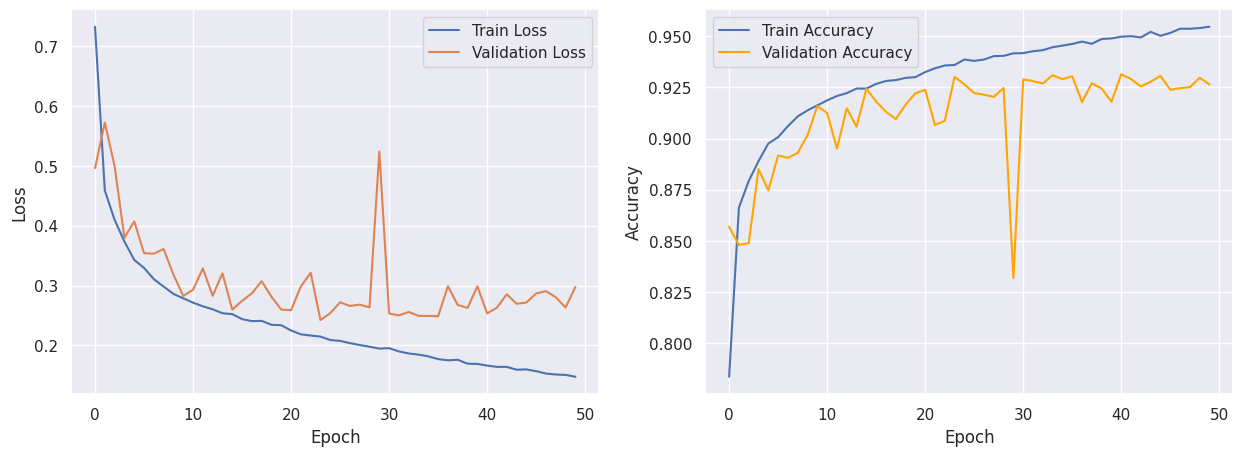

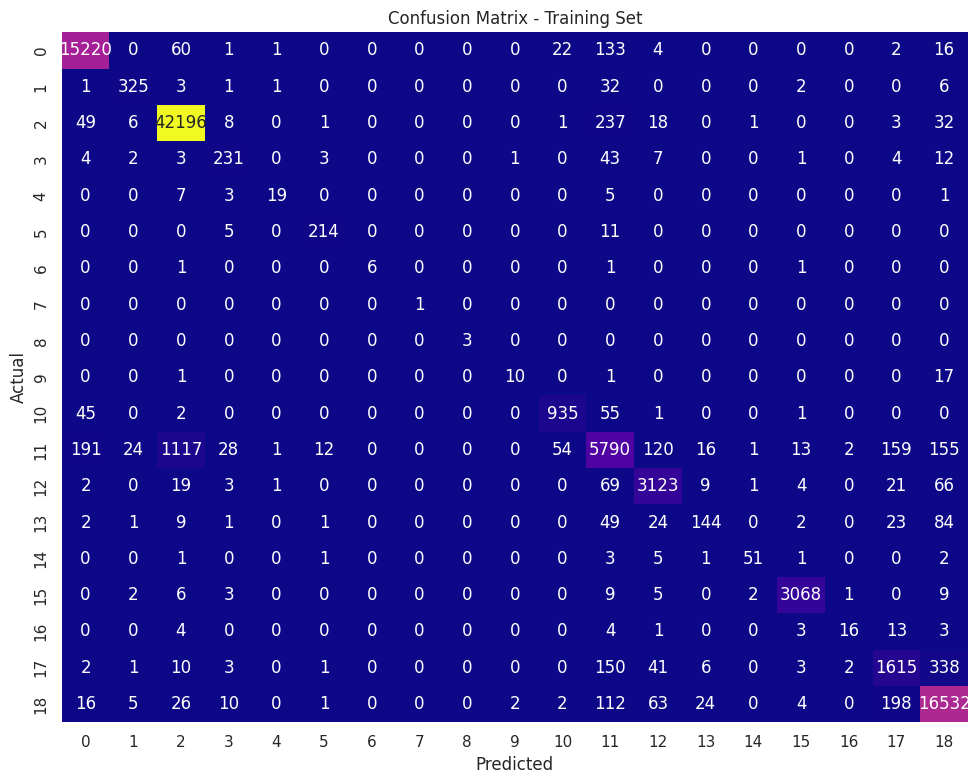

In [70]:
all_label_model = TimeSeriesMLP(input_size=620, output_size=19, hidden_units=[256,256]).to(device)
learning_rate=0.001
optimizer = optim.Adam(all_label_model.parameters(), lr=learning_rate)
# training and evaluating the model
trained_model, metrics = train_evaluate_plot_model(all_label_model, train_loader, val_loader, optimizer, num_epochs=50, learning_rate=0.001, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))



**Interpretation**

The `loss & accuracy` graph gives a sense of overfitting as the values fluctuates alot especially in the first 5 epochs. Although there were no dramatic fluctuations, I believe that the optimizer might have over-optimized the model despite the noisy classes in the data.

`Confusion Matrix` presents a good explanation for the over-optimization as many there are quite a number of false positives and false negatives in the matrix distribution.

Test Accuracy: 0.927


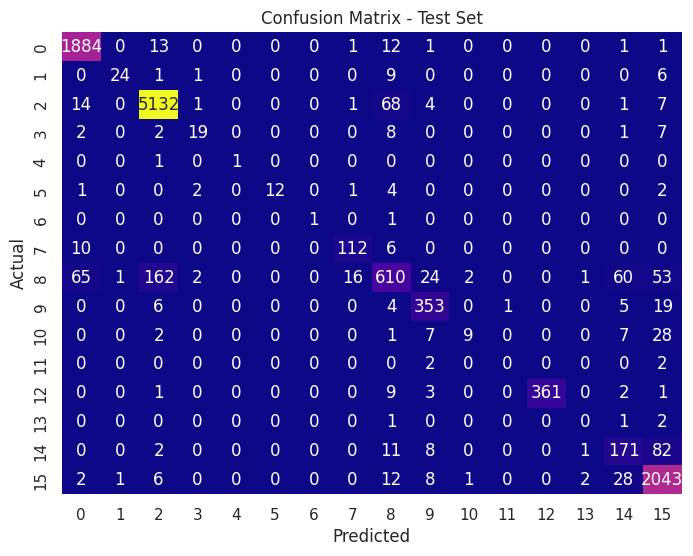

In [71]:
test_model(trained_model, test_loader)


**Interpretation**

The `Confusion Matrix` for test set looks good; however, I do not know, how to explain the automatic deletion of some of the class labels. This could possibly be due to the fact that some of the classes have very low number of labels that they cannot be dealt with at the data split.

### 3.1.7. Hyperparameter tuning for all labels

It is very important to choose the best set of parameters/hyperparameters to improve an average performing model just through optimizing these values. In this section, we will tune:
- `num_epochs`
- `lr`
- `optimizer`




Iteration 1: Hyperparameters - Num Epochs: 50, Learning Rate: 0.0001, Optimizer: Adam
Epoch 1/50, Train Loss: 0.1086, Train Accuracy: 0.9684, Validation Loss: 0.2556, Validation Accuracy: 0.9355
Epoch 2/50, Train Loss: 0.1030, Train Accuracy: 0.9706, Validation Loss: 0.2542, Validation Accuracy: 0.9346
Epoch 3/50, Train Loss: 0.1012, Train Accuracy: 0.9715, Validation Loss: 0.2549, Validation Accuracy: 0.9347
Epoch 4/50, Train Loss: 0.0999, Train Accuracy: 0.9717, Validation Loss: 0.2551, Validation Accuracy: 0.9355
Epoch 5/50, Train Loss: 0.0982, Train Accuracy: 0.9727, Validation Loss: 0.2569, Validation Accuracy: 0.9344
Epoch 6/50, Train Loss: 0.0976, Train Accuracy: 0.9728, Validation Loss: 0.2566, Validation Accuracy: 0.9363
Epoch 7/50, Train Loss: 0.0966, Train Accuracy: 0.9730, Validation Loss: 0.2604, Validation Accuracy: 0.9347
Epoch 8/50, Train Loss: 0.0957, Train Accuracy: 0.9734, Validation Loss: 0.2565, Validation Accuracy: 0.9346
Epoch 9/50, Train Loss: 0.0951, Train Acc

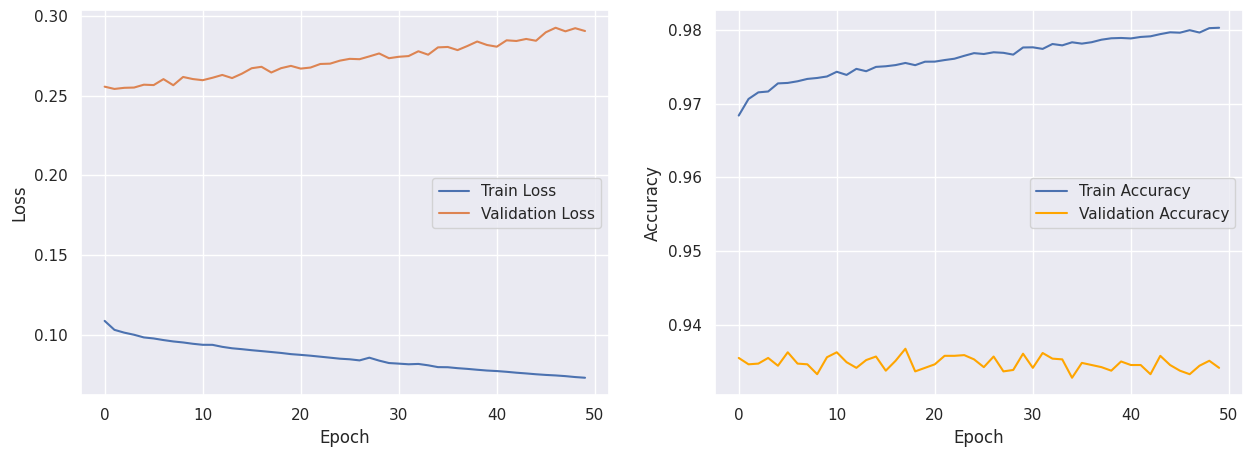

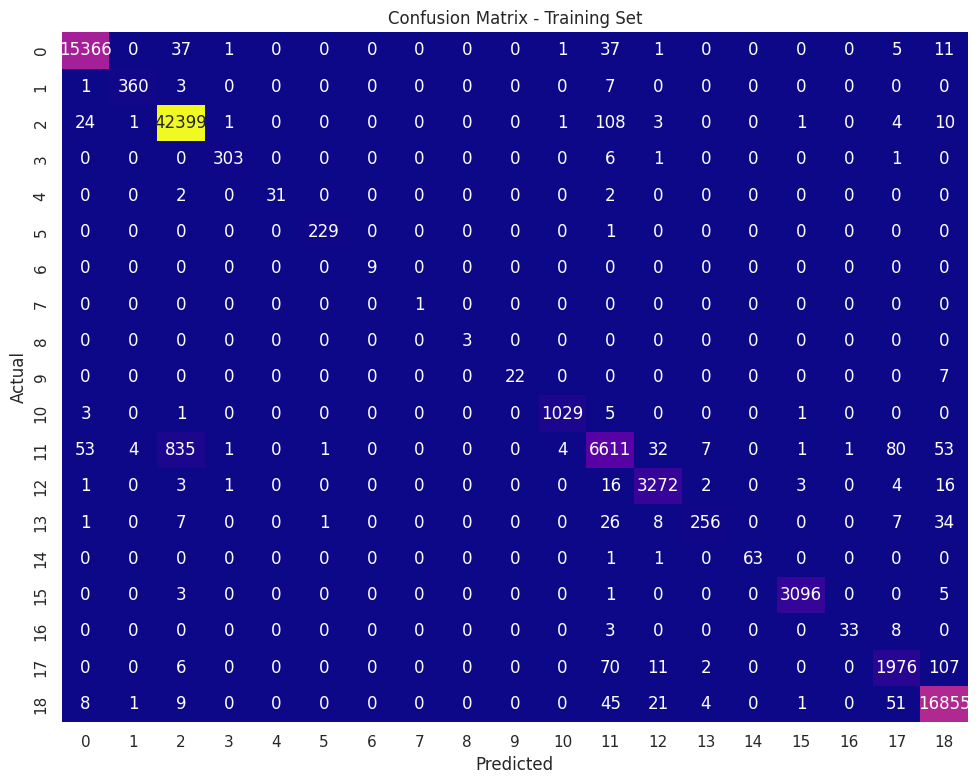


Iteration 2: Hyperparameters - Num Epochs: 50, Learning Rate: 0.0001, Optimizer: SGD
Epoch 1/50, Train Loss: 0.0706, Train Accuracy: 0.9811, Validation Loss: 0.2896, Validation Accuracy: 0.9338
Epoch 2/50, Train Loss: 0.0699, Train Accuracy: 0.9814, Validation Loss: 0.2893, Validation Accuracy: 0.9344
Epoch 3/50, Train Loss: 0.0694, Train Accuracy: 0.9816, Validation Loss: 0.2892, Validation Accuracy: 0.9339
Epoch 4/50, Train Loss: 0.0692, Train Accuracy: 0.9819, Validation Loss: 0.2891, Validation Accuracy: 0.9343
Epoch 5/50, Train Loss: 0.0690, Train Accuracy: 0.9820, Validation Loss: 0.2890, Validation Accuracy: 0.9345
Epoch 6/50, Train Loss: 0.0688, Train Accuracy: 0.9820, Validation Loss: 0.2891, Validation Accuracy: 0.9342
Epoch 7/50, Train Loss: 0.0687, Train Accuracy: 0.9821, Validation Loss: 0.2891, Validation Accuracy: 0.9343
Epoch 8/50, Train Loss: 0.0686, Train Accuracy: 0.9821, Validation Loss: 0.2891, Validation Accuracy: 0.9342
Epoch 9/50, Train Loss: 0.0685, Train Accu

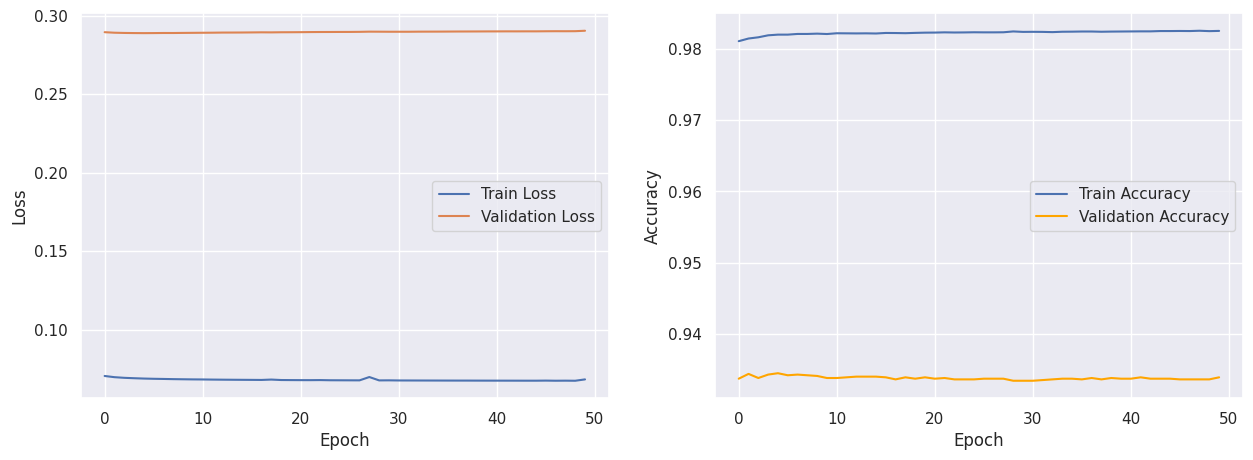

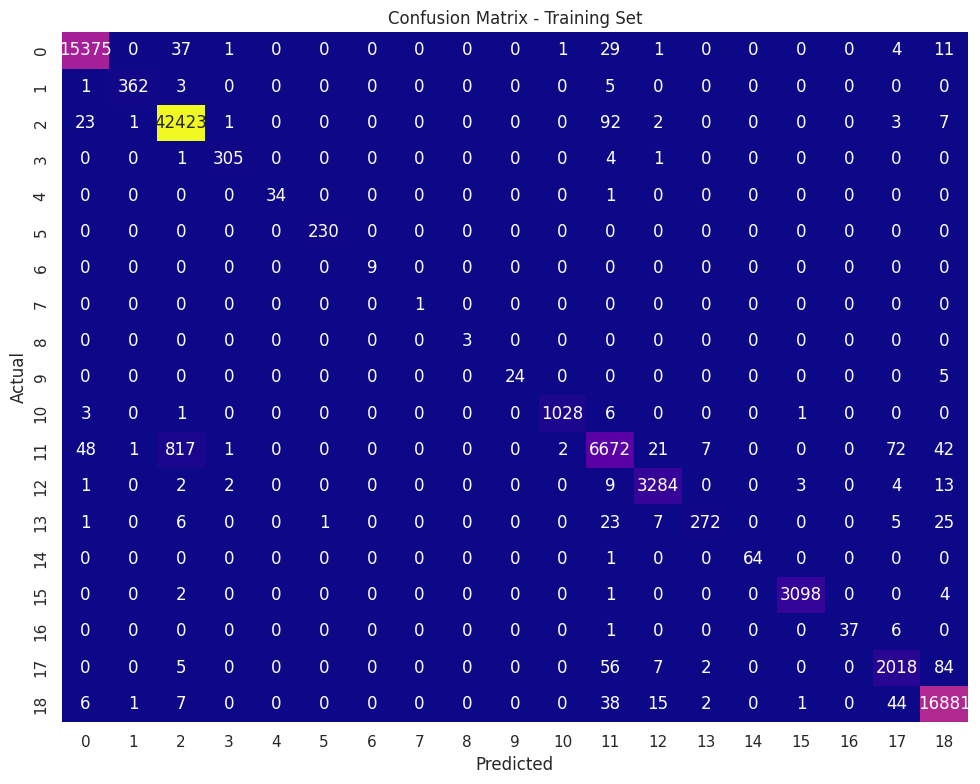


Iteration 3: Hyperparameters - Num Epochs: 50, Learning Rate: 0.001, Optimizer: Adam
Epoch 1/50, Train Loss: 0.1305, Train Accuracy: 0.9583, Validation Loss: 0.3407, Validation Accuracy: 0.9186
Epoch 2/50, Train Loss: 0.1291, Train Accuracy: 0.9587, Validation Loss: 0.3214, Validation Accuracy: 0.9279
Epoch 3/50, Train Loss: 0.1296, Train Accuracy: 0.9583, Validation Loss: 0.2962, Validation Accuracy: 0.9329
Epoch 4/50, Train Loss: 0.1289, Train Accuracy: 0.9588, Validation Loss: 0.3290, Validation Accuracy: 0.9236
Epoch 5/50, Train Loss: 0.1276, Train Accuracy: 0.9592, Validation Loss: 0.3433, Validation Accuracy: 0.9164
Epoch 6/50, Train Loss: 0.1257, Train Accuracy: 0.9597, Validation Loss: 0.3271, Validation Accuracy: 0.9264
Epoch 7/50, Train Loss: 0.1234, Train Accuracy: 0.9608, Validation Loss: 0.3082, Validation Accuracy: 0.9267
Epoch 8/50, Train Loss: 0.1227, Train Accuracy: 0.9603, Validation Loss: 0.3280, Validation Accuracy: 0.9257
Epoch 9/50, Train Loss: 0.1242, Train Accu

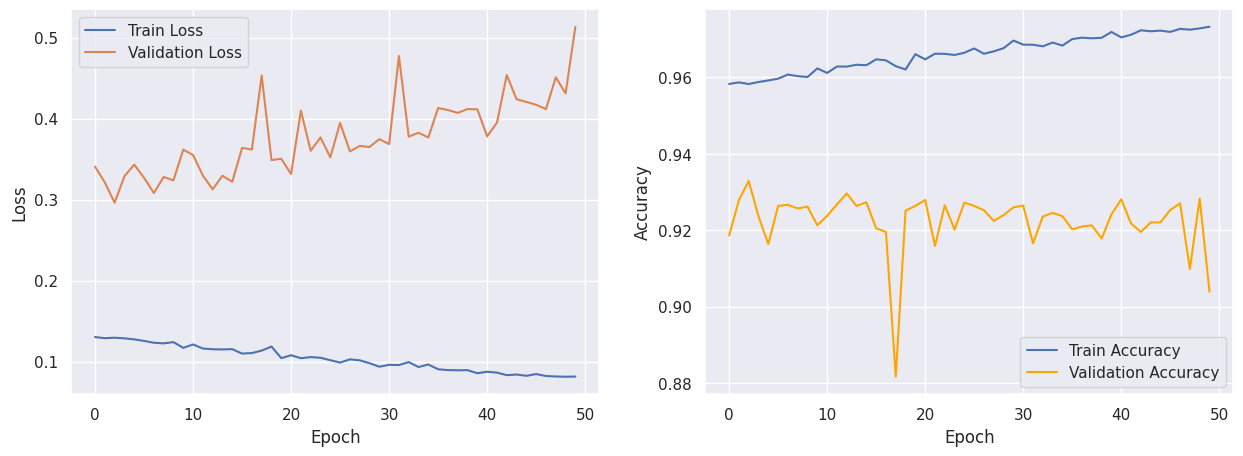

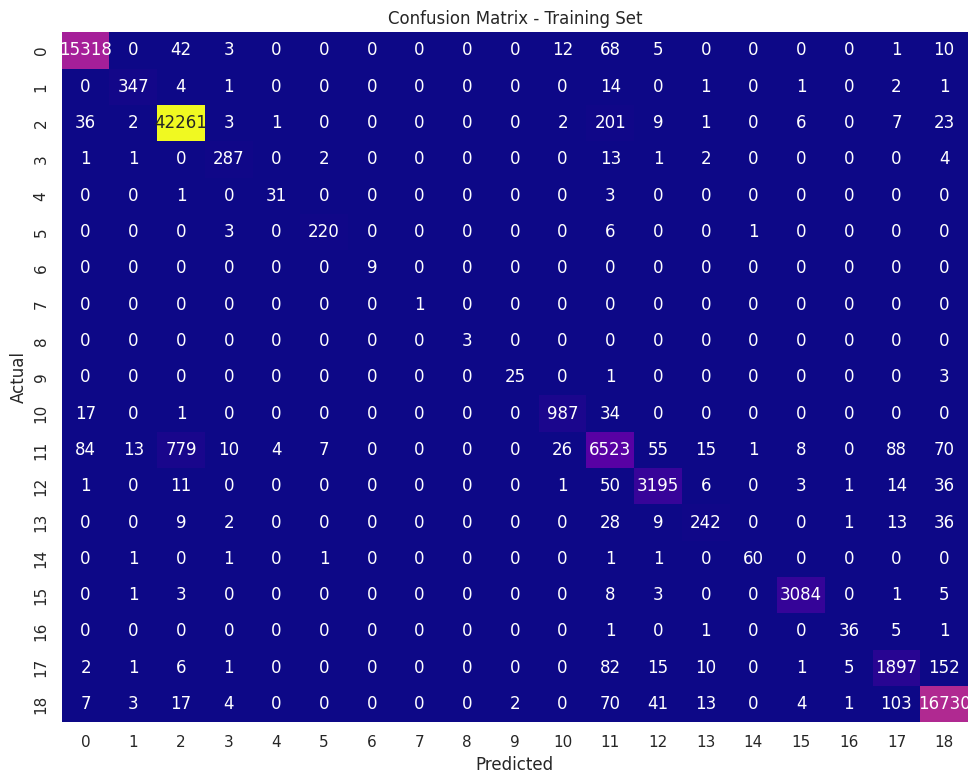


Iteration 4: Hyperparameters - Num Epochs: 50, Learning Rate: 0.001, Optimizer: SGD
Epoch 1/50, Train Loss: 0.0677, Train Accuracy: 0.9776, Validation Loss: 0.3977, Validation Accuracy: 0.9278
Epoch 2/50, Train Loss: 0.0507, Train Accuracy: 0.9842, Validation Loss: 0.3951, Validation Accuracy: 0.9293
Epoch 3/50, Train Loss: 0.0471, Train Accuracy: 0.9858, Validation Loss: 0.3944, Validation Accuracy: 0.9288
Epoch 4/50, Train Loss: 0.0448, Train Accuracy: 0.9865, Validation Loss: 0.3941, Validation Accuracy: 0.9286
Epoch 5/50, Train Loss: 0.0432, Train Accuracy: 0.9871, Validation Loss: 0.3943, Validation Accuracy: 0.9290
Epoch 6/50, Train Loss: 0.0420, Train Accuracy: 0.9876, Validation Loss: 0.3947, Validation Accuracy: 0.9294
Epoch 7/50, Train Loss: 0.0410, Train Accuracy: 0.9882, Validation Loss: 0.3950, Validation Accuracy: 0.9292
Epoch 8/50, Train Loss: 0.0402, Train Accuracy: 0.9886, Validation Loss: 0.3953, Validation Accuracy: 0.9291
Epoch 9/50, Train Loss: 0.0396, Train Accur

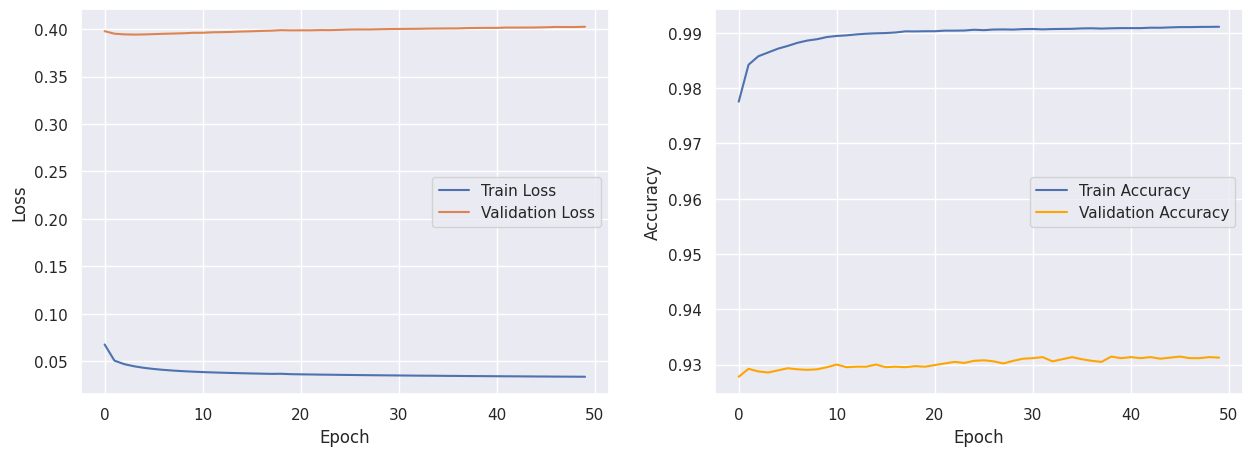

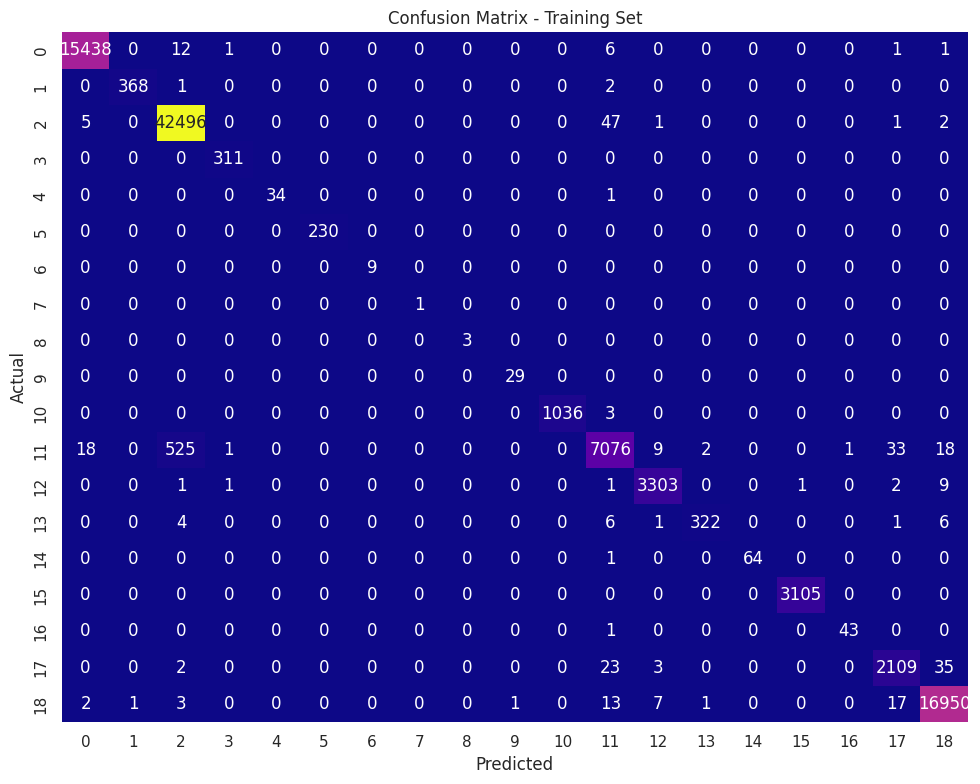


Iteration 5: Hyperparameters - Num Epochs: 50, Learning Rate: 0.01, Optimizer: Adam
Epoch 1/50, Train Loss: 0.4408, Train Accuracy: 0.8798, Validation Loss: 0.4672, Validation Accuracy: 0.8639
Epoch 2/50, Train Loss: 0.3767, Train Accuracy: 0.8896, Validation Loss: 0.7754, Validation Accuracy: 0.8237
Epoch 3/50, Train Loss: 0.3548, Train Accuracy: 0.8955, Validation Loss: 0.3516, Validation Accuracy: 0.8992
Epoch 4/50, Train Loss: 0.3478, Train Accuracy: 0.8964, Validation Loss: 0.3574, Validation Accuracy: 0.8912
Epoch 5/50, Train Loss: 0.3355, Train Accuracy: 0.9002, Validation Loss: 0.3568, Validation Accuracy: 0.8873
Epoch 6/50, Train Loss: 0.3296, Train Accuracy: 0.9037, Validation Loss: 0.4946, Validation Accuracy: 0.8527
Epoch 7/50, Train Loss: 0.3707, Train Accuracy: 0.8913, Validation Loss: 0.3209, Validation Accuracy: 0.9041
Epoch 8/50, Train Loss: 0.3207, Train Accuracy: 0.9053, Validation Loss: 0.3010, Validation Accuracy: 0.9117
Epoch 9/50, Train Loss: 0.3219, Train Accur

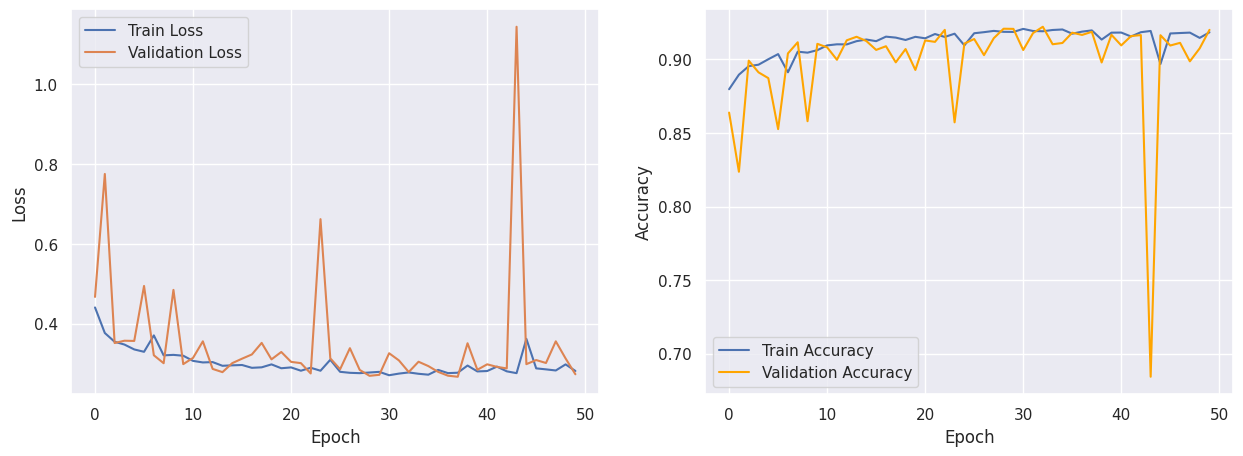

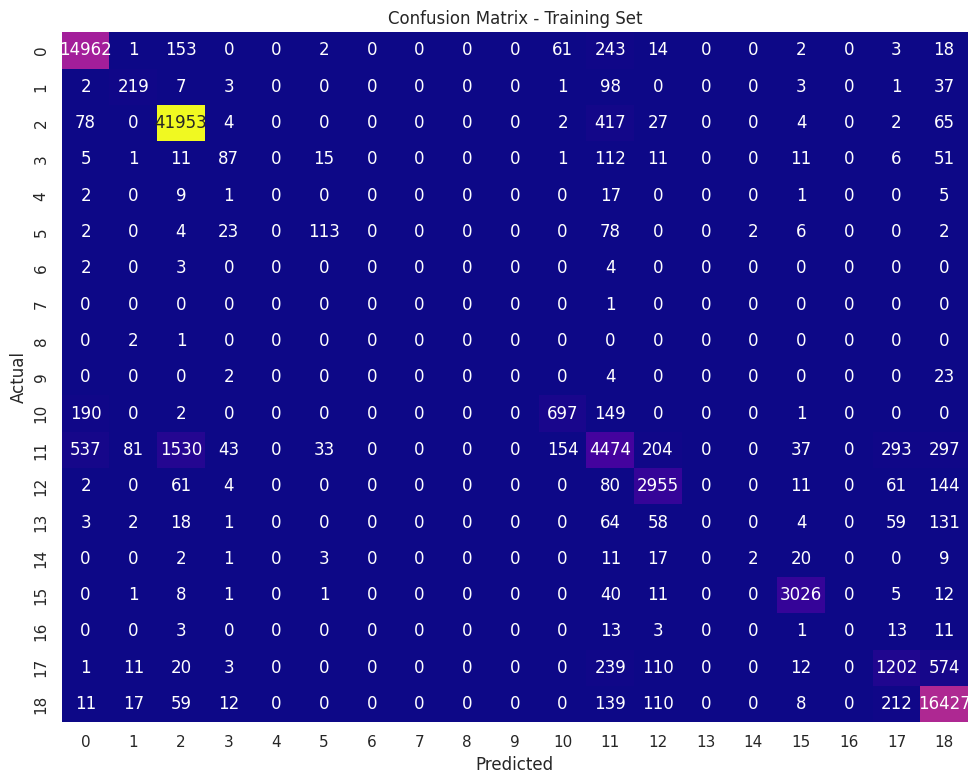


Iteration 6: Hyperparameters - Num Epochs: 50, Learning Rate: 0.01, Optimizer: SGD
Epoch 1/50, Train Loss: 0.2383, Train Accuracy: 0.9314, Validation Loss: 0.2548, Validation Accuracy: 0.9245
Epoch 2/50, Train Loss: 0.2340, Train Accuracy: 0.9323, Validation Loss: 0.2527, Validation Accuracy: 0.9251
Epoch 3/50, Train Loss: 0.2325, Train Accuracy: 0.9329, Validation Loss: 0.2521, Validation Accuracy: 0.9250
Epoch 4/50, Train Loss: 0.2314, Train Accuracy: 0.9333, Validation Loss: 0.2523, Validation Accuracy: 0.9248
Epoch 5/50, Train Loss: 0.2307, Train Accuracy: 0.9332, Validation Loss: 0.2511, Validation Accuracy: 0.9246
Epoch 6/50, Train Loss: 0.2307, Train Accuracy: 0.9336, Validation Loss: 0.2543, Validation Accuracy: 0.9240
Epoch 7/50, Train Loss: 0.2297, Train Accuracy: 0.9335, Validation Loss: 0.2506, Validation Accuracy: 0.9248
Epoch 8/50, Train Loss: 0.2292, Train Accuracy: 0.9339, Validation Loss: 0.2502, Validation Accuracy: 0.9248
Epoch 9/50, Train Loss: 0.2288, Train Accura

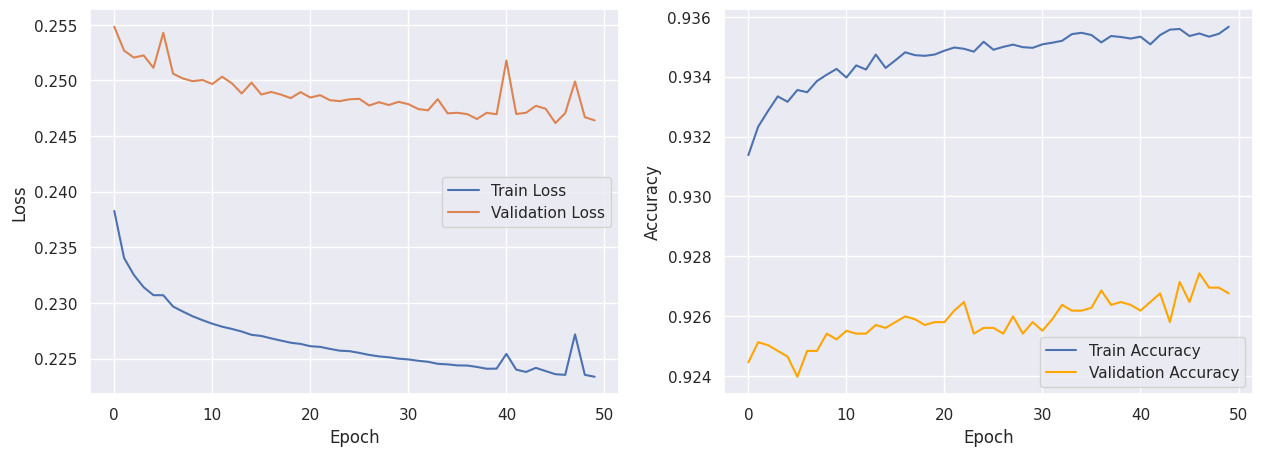

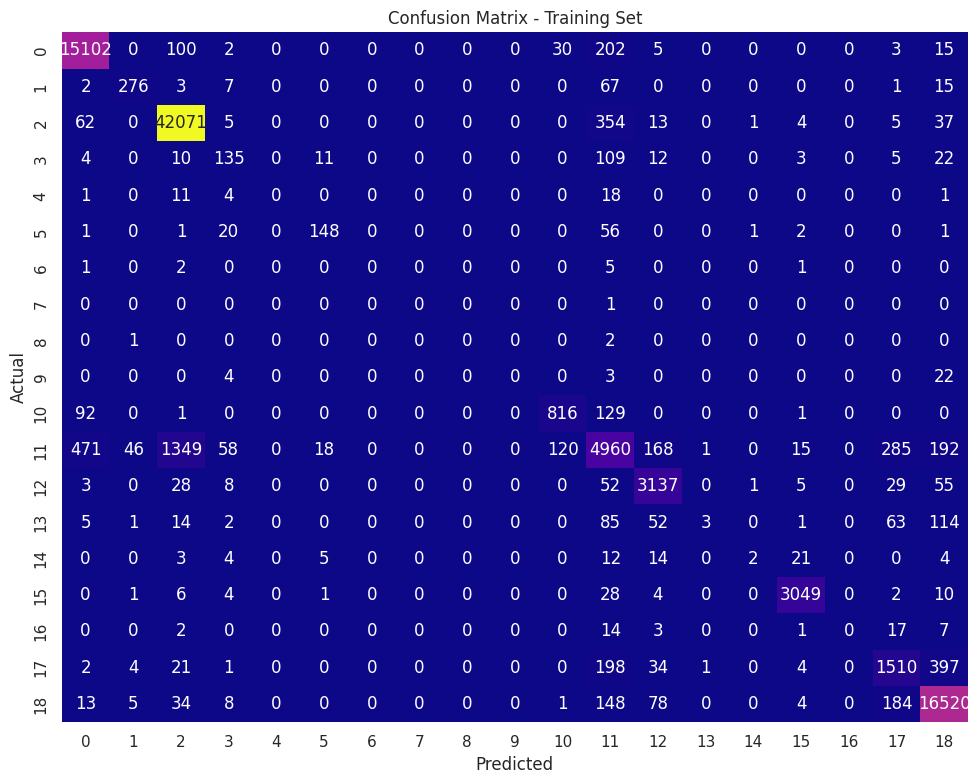


Best Hyperparameters:
{'num_epochs': 50, 'learning_rate': 0.01, 'optimizer': 'SGD'}

Best Metrics:
{'train_loss': 0.22359069406358578, 'val_loss': 0.24617026796553032, 'train_accuracy': 0.935356918121607, 'val_accuracy': 0.9264734114033404}


<All keys matched successfully>

In [72]:
# hyperparameter search space
param_space = {
    'num_epochs': [50],
    'learning_rate': [0.0001, 0.001, 0.01],
    'optimizer': [optim.Adam, optim.SGD]
}

# Store results for all trials
results = []

# parameterGrid from the hyperparameter search space
param_grid = list(product(param_space['num_epochs'], param_space['learning_rate'], param_space['optimizer']))

for i, (num_epochs, learning_rate, optimizer) in enumerate(param_grid):
    print(f"\nIteration {i + 1}: Hyperparameters - Num Epochs: {num_epochs}, Learning Rate: {learning_rate}, Optimizer: {optimizer.__name__}")

    # Train and evaluate the model
    model, metrics = train_evaluate_plot_model(all_label_model,
                                               train_loader=train_loader, val_loader=val_loader,
                                               optimizer=optimizer(all_label_model.parameters(), lr=learning_rate),
                                               num_epochs=num_epochs,
                                               learning_rate=learning_rate,
                                               device=device)

    # Store the results for this trial
    results.append({
        'hyperparameters': {'num_epochs': num_epochs, 'learning_rate': learning_rate, 'optimizer': optimizer.__name__},
        'model_state_dict': model.state_dict(),  # Save the model's state dict
        'metrics': metrics
    })

# best set of hyperparameters based on validation accuracy
best_result = min(results, key=lambda x: x['metrics']['val_loss'])
best_hyperparameters = best_result['hyperparameters']
best_metrics = best_result['metrics']
best_model_state_dict = best_result['model_state_dict']

print("\nBest Hyperparameters:")
print(best_hyperparameters)
print("\nBest Metrics:")
print(best_metrics)



With a list of `epochs.values` and this technique of tuning, the tuning took very long and did not optimize much. Therefore, I decided to tune and optimize the model using only 50 epochs for different combinations of `optimizers` and `learning rates`

**Interpretation**

The plots may look as if the model has performed extremely poorly, it is just the scale adjustment. Model performed good on both train and val data. Through the tuning process, we got, `SGD` as the optimistic optimizer at the `lr = 0.01`. It is not ideal or the best and it is certainly not what was expected. There might be a better improved yet intricate way to tune hyperparameters. However, this simple method has done well in identifying give the complexity of the data and the problem in hand.

Test Accuracy: 0.927


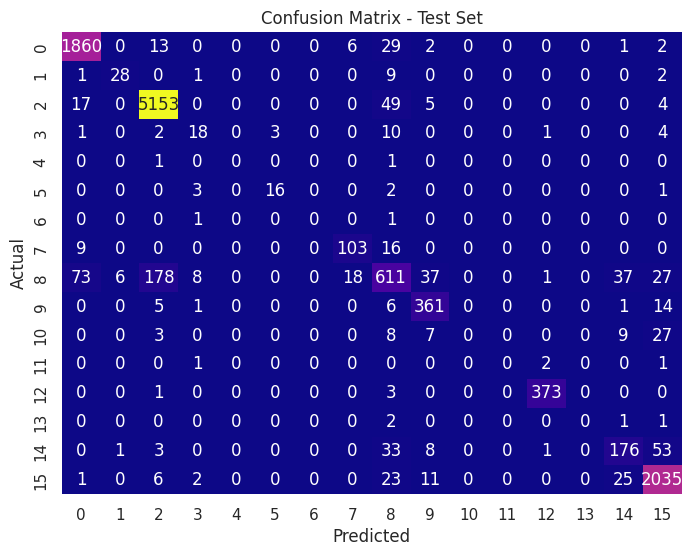

In [78]:

all_label_model.load_state_dict(best_model_state_dict)
# Test the best model with the test set
test_model(all_label_model, test_loader)

**Interpretation**

The `Confusion Matrix` looks similar to the previous one with similar complications.

### 3.1.8. Network Tuning - Regularization





**Tune dropout rate, the hidden layers for the best model, and early-stopping**

Givent the performance after the hyperparameter tuning there was no need to introduce regularization at this instance. However, the dropout_rate has already been introduced in the model_instance, if need be we can tune it up and down with the model that has performed the best.

**Best Hyperparameters:**

{'num_epochs': 50, 'learning_rate': 0.01, 'optimizer': 'SGD'}

This will be used to tune the network and find the best metrics.


Trial 1/16: Hidden Units - [128, 128], Dropout Rate - 0.1
Epoch 1/50, Train Loss: 1.7723, Train Accuracy: 0.4509, Validation Loss: 1.6369, Validation Accuracy: 0.4566
Epoch 2/50, Train Loss: 1.6113, Train Accuracy: 0.4538, Validation Loss: 1.5983, Validation Accuracy: 0.4566
Epoch 3/50, Train Loss: 1.5354, Train Accuracy: 0.4696, Validation Loss: 1.4581, Validation Accuracy: 0.4814
Epoch 4/50, Train Loss: 1.2804, Train Accuracy: 0.6242, Validation Loss: 1.1249, Validation Accuracy: 0.6820
Epoch 5/50, Train Loss: 0.9979, Train Accuracy: 0.7389, Validation Loss: 0.8761, Validation Accuracy: 0.7687
Epoch 6/50, Train Loss: 0.8292, Train Accuracy: 0.7796, Validation Loss: 0.7856, Validation Accuracy: 0.7859
Epoch 7/50, Train Loss: 0.7516, Train Accuracy: 0.7947, Validation Loss: 0.8066, Validation Accuracy: 0.7962
Epoch 8/50, Train Loss: 0.7088, Train Accuracy: 0.7998, Validation Loss: 0.7186, Validation Accuracy: 0.7919
Epoch 9/50, Train Loss: 0.6784, Train Accuracy: 0.8040, Validation Lo

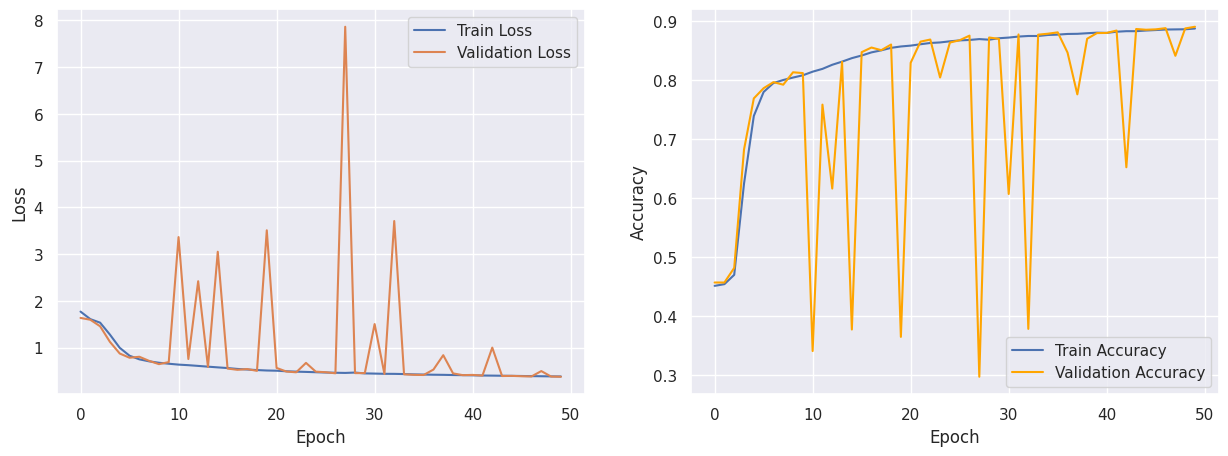

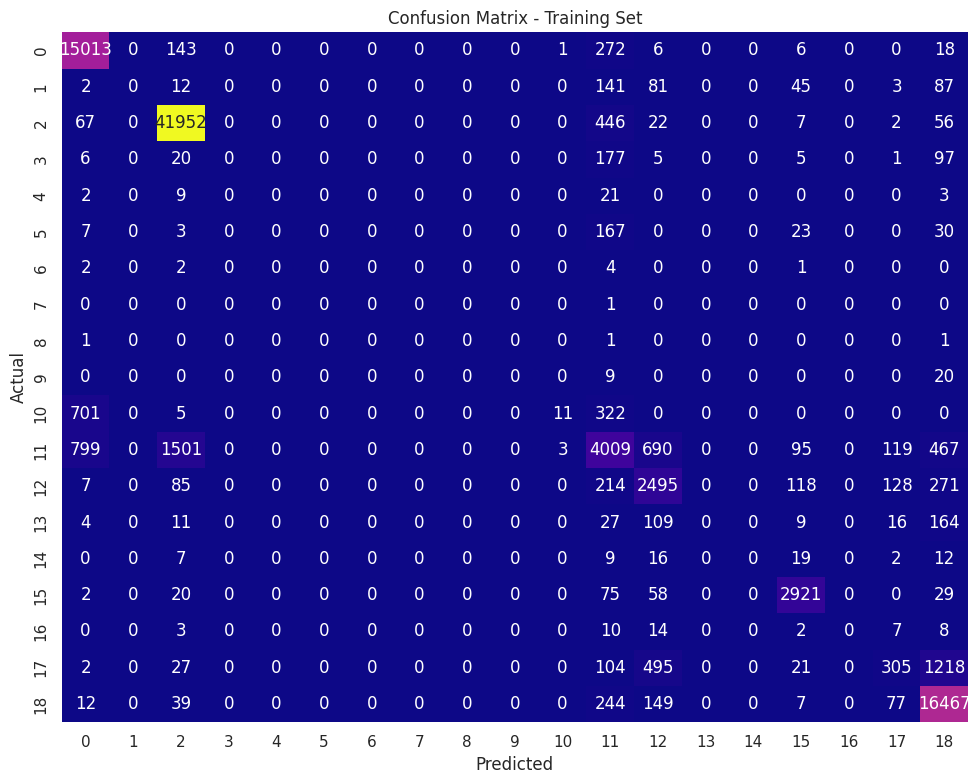


Trial 2/16: Hidden Units - [128, 128], Dropout Rate - 0.2
Epoch 1/50, Train Loss: 1.7824, Train Accuracy: 0.4537, Validation Loss: 1.6292, Validation Accuracy: 0.4566
Epoch 2/50, Train Loss: 1.6204, Train Accuracy: 0.4538, Validation Loss: 1.6034, Validation Accuracy: 0.4566
Epoch 3/50, Train Loss: 1.5693, Train Accuracy: 0.4570, Validation Loss: 1.5549, Validation Accuracy: 0.5433
Epoch 4/50, Train Loss: 1.3564, Train Accuracy: 0.5750, Validation Loss: 1.1990, Validation Accuracy: 0.6204
Epoch 5/50, Train Loss: 1.0724, Train Accuracy: 0.7124, Validation Loss: 0.9288, Validation Accuracy: 0.7475
Epoch 6/50, Train Loss: 0.8725, Train Accuracy: 0.7715, Validation Loss: 0.7978, Validation Accuracy: 0.7831
Epoch 7/50, Train Loss: 0.7809, Train Accuracy: 0.7889, Validation Loss: 0.7243, Validation Accuracy: 0.8024
Epoch 8/50, Train Loss: 0.7322, Train Accuracy: 0.7955, Validation Loss: 0.9307, Validation Accuracy: 0.7346
Epoch 9/50, Train Loss: 0.6997, Train Accuracy: 0.8001, Validation Lo

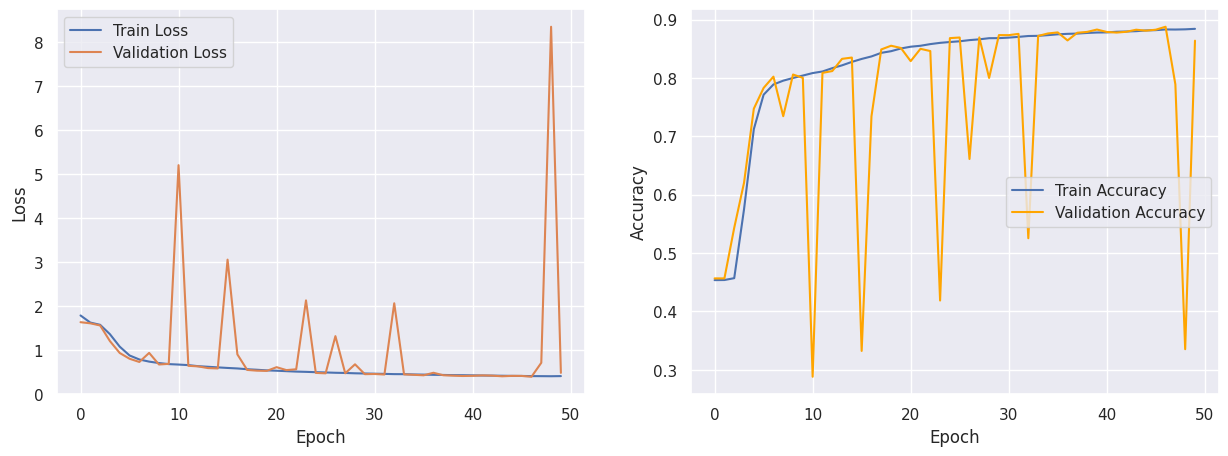

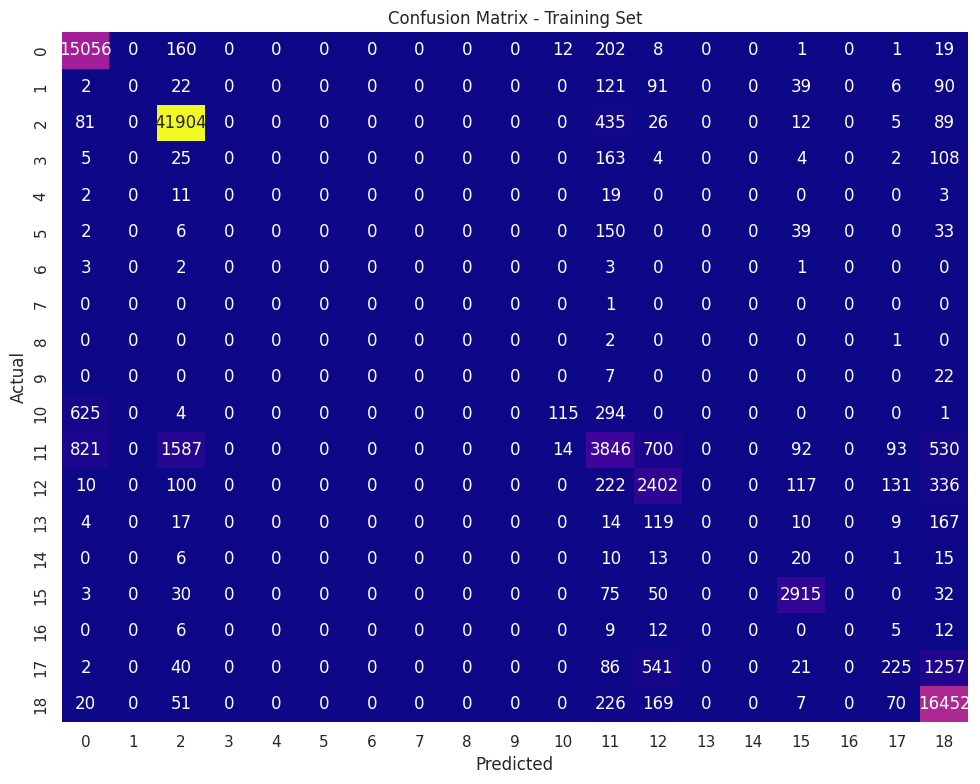


Trial 3/16: Hidden Units - [128, 128], Dropout Rate - 0.3
Epoch 1/50, Train Loss: 1.7934, Train Accuracy: 0.4505, Validation Loss: 1.6283, Validation Accuracy: 0.4566
Epoch 2/50, Train Loss: 1.6216, Train Accuracy: 0.4538, Validation Loss: 1.6070, Validation Accuracy: 0.4566
Epoch 3/50, Train Loss: 1.5687, Train Accuracy: 0.4606, Validation Loss: 1.4929, Validation Accuracy: 0.5058
Epoch 4/50, Train Loss: 1.3713, Train Accuracy: 0.5732, Validation Loss: 1.3210, Validation Accuracy: 0.5702
Epoch 5/50, Train Loss: 1.1616, Train Accuracy: 0.6785, Validation Loss: 1.1394, Validation Accuracy: 0.6453
Epoch 6/50, Train Loss: 0.9599, Train Accuracy: 0.7490, Validation Loss: 0.8628, Validation Accuracy: 0.7650
Epoch 7/50, Train Loss: 0.8264, Train Accuracy: 0.7781, Validation Loss: 0.7506, Validation Accuracy: 0.7978
Epoch 8/50, Train Loss: 0.7588, Train Accuracy: 0.7911, Validation Loss: 0.7264, Validation Accuracy: 0.7939
Epoch 9/50, Train Loss: 0.7186, Train Accuracy: 0.7973, Validation Lo

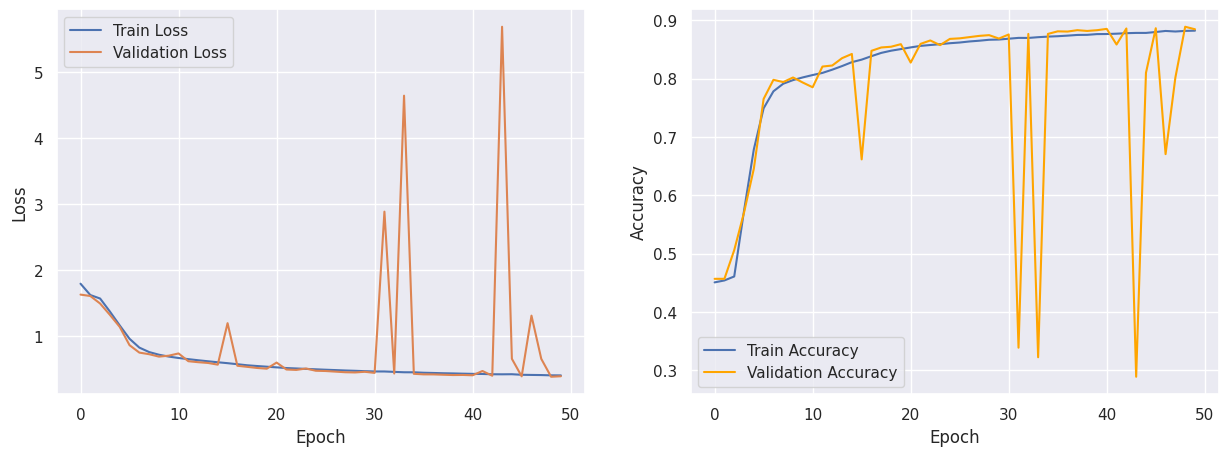

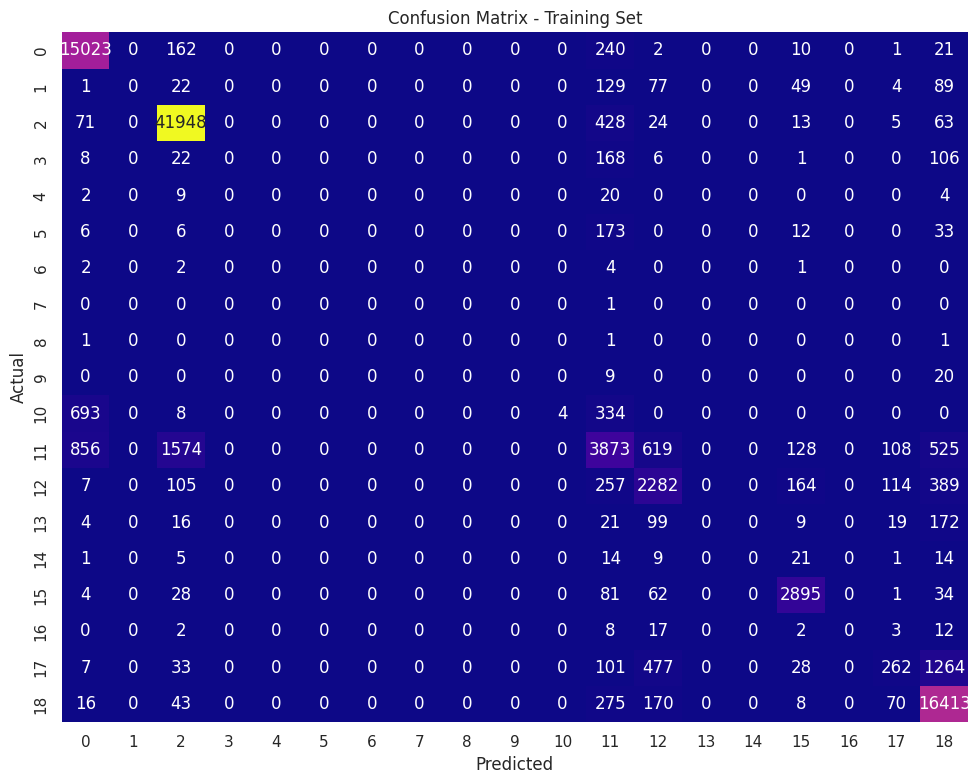


Trial 4/16: Hidden Units - [128, 128], Dropout Rate - 0.4
Epoch 1/50, Train Loss: 1.7874, Train Accuracy: 0.4492, Validation Loss: 1.6230, Validation Accuracy: 0.4566
Epoch 2/50, Train Loss: 1.6269, Train Accuracy: 0.4538, Validation Loss: 1.6176, Validation Accuracy: 0.4566
Epoch 3/50, Train Loss: 1.5845, Train Accuracy: 0.4548, Validation Loss: 1.5412, Validation Accuracy: 0.4566
Epoch 4/50, Train Loss: 1.4181, Train Accuracy: 0.5492, Validation Loss: 1.3135, Validation Accuracy: 0.5696
Epoch 5/50, Train Loss: 1.2001, Train Accuracy: 0.6573, Validation Loss: 1.0512, Validation Accuracy: 0.7134
Epoch 6/50, Train Loss: 0.9934, Train Accuracy: 0.7396, Validation Loss: 1.9795, Validation Accuracy: 0.5020
Epoch 7/50, Train Loss: 0.8564, Train Accuracy: 0.7733, Validation Loss: 0.7678, Validation Accuracy: 0.7946
Epoch 8/50, Train Loss: 0.7864, Train Accuracy: 0.7876, Validation Loss: 0.7589, Validation Accuracy: 0.8023
Epoch 9/50, Train Loss: 0.7426, Train Accuracy: 0.7950, Validation Lo

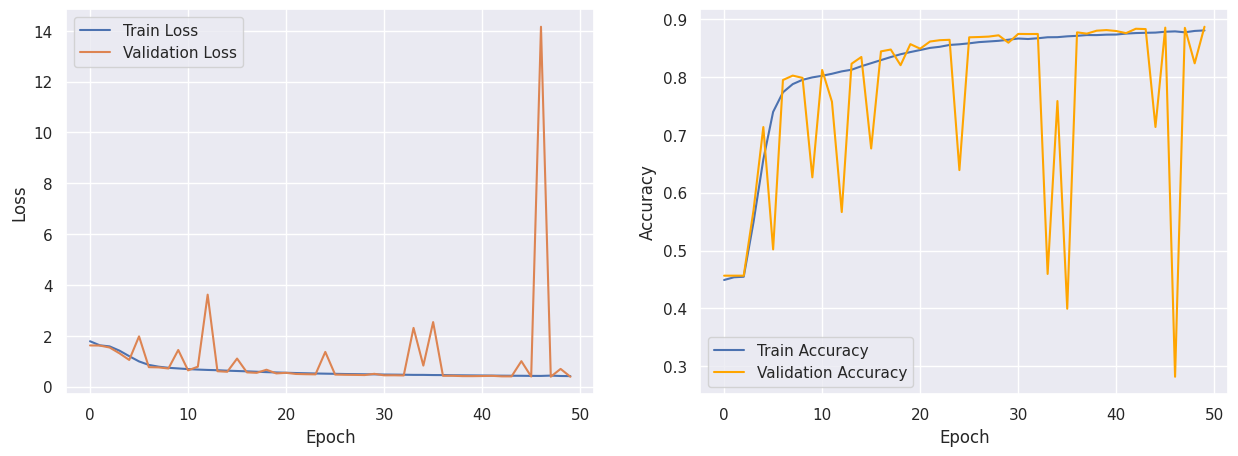

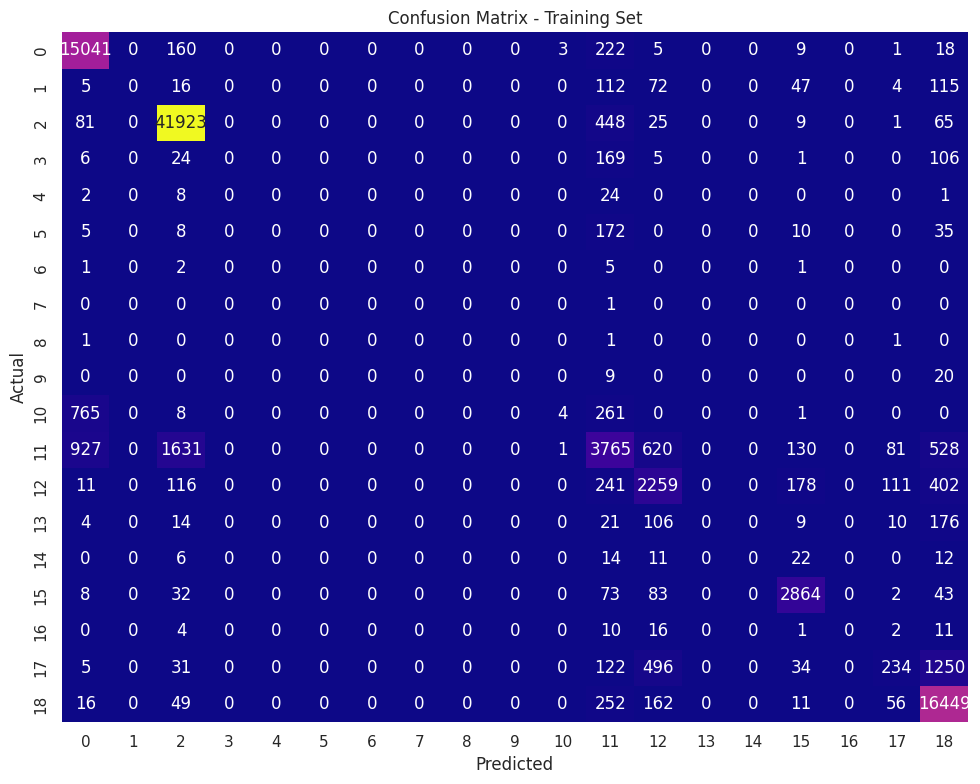


Trial 5/16: Hidden Units - [256, 256], Dropout Rate - 0.1
Epoch 1/50, Train Loss: 1.7649, Train Accuracy: 0.4504, Validation Loss: 1.6221, Validation Accuracy: 0.4566
Epoch 2/50, Train Loss: 1.6062, Train Accuracy: 0.4538, Validation Loss: 1.5907, Validation Accuracy: 0.4566
Epoch 3/50, Train Loss: 1.4911, Train Accuracy: 0.4950, Validation Loss: 1.4229, Validation Accuracy: 0.5122
Epoch 4/50, Train Loss: 1.2019, Train Accuracy: 0.6549, Validation Loss: 1.0723, Validation Accuracy: 0.7149
Epoch 5/50, Train Loss: 0.9359, Train Accuracy: 0.7552, Validation Loss: 1.6135, Validation Accuracy: 0.4749
Epoch 6/50, Train Loss: 0.7946, Train Accuracy: 0.7871, Validation Loss: 0.8095, Validation Accuracy: 0.7706
Epoch 7/50, Train Loss: 0.7288, Train Accuracy: 0.7977, Validation Loss: 0.7234, Validation Accuracy: 0.7907
Epoch 8/50, Train Loss: 0.6901, Train Accuracy: 0.8020, Validation Loss: 0.7822, Validation Accuracy: 0.7769
Epoch 9/50, Train Loss: 0.6640, Train Accuracy: 0.8064, Validation Lo

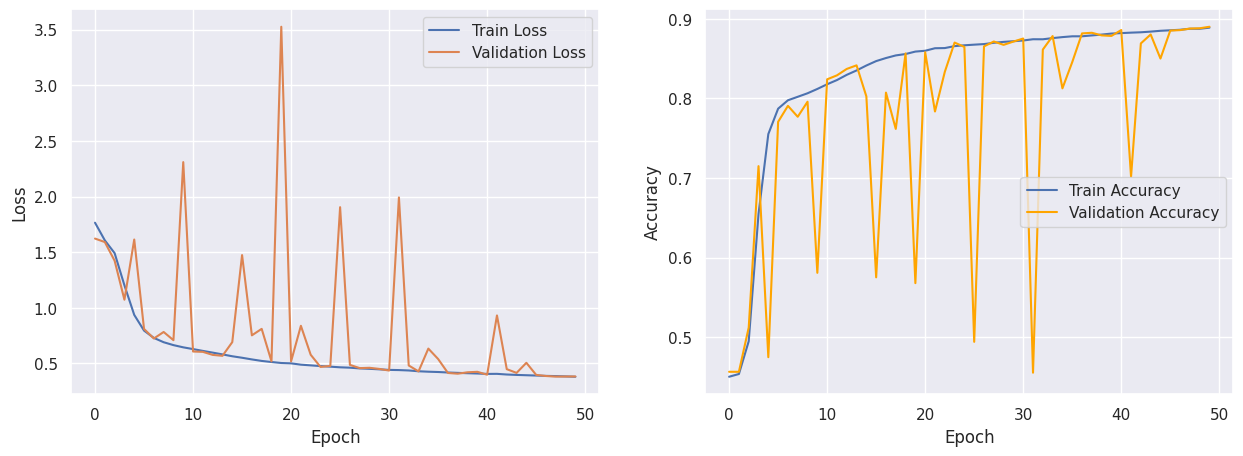

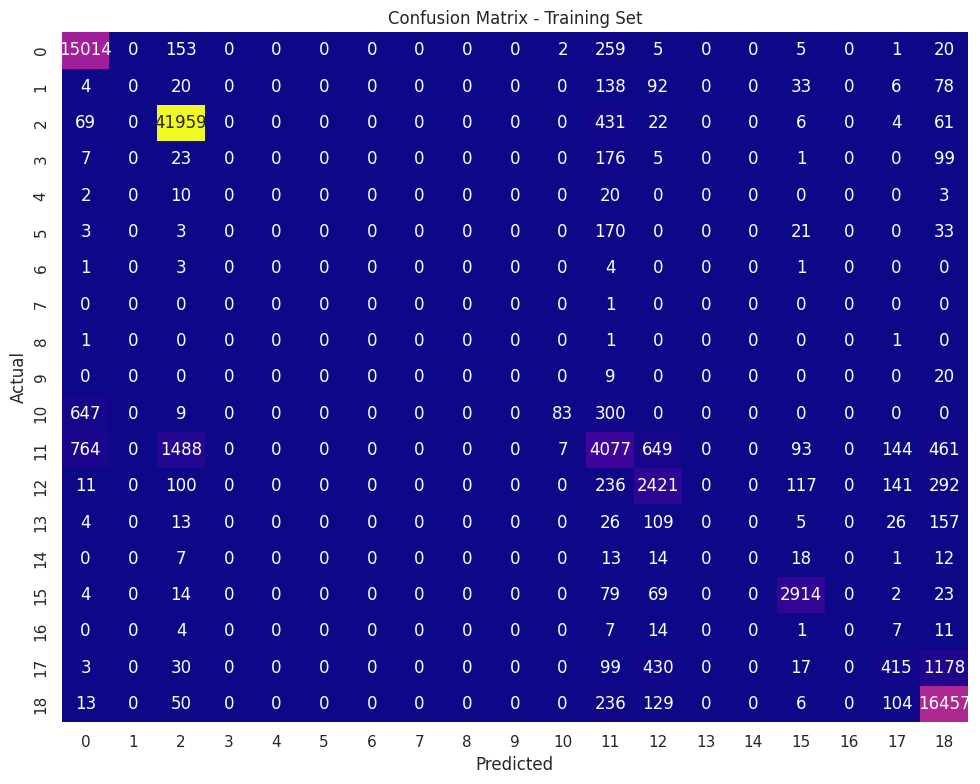


Trial 6/16: Hidden Units - [256, 256], Dropout Rate - 0.2
Epoch 1/50, Train Loss: 1.7622, Train Accuracy: 0.4524, Validation Loss: 1.6326, Validation Accuracy: 0.4566
Epoch 2/50, Train Loss: 1.6135, Train Accuracy: 0.4538, Validation Loss: 1.6054, Validation Accuracy: 0.4566
Epoch 3/50, Train Loss: 1.5368, Train Accuracy: 0.4713, Validation Loss: 1.4528, Validation Accuracy: 0.4768
Epoch 4/50, Train Loss: 1.2726, Train Accuracy: 0.6147, Validation Loss: 1.1277, Validation Accuracy: 0.6430
Epoch 5/50, Train Loss: 0.9855, Train Accuracy: 0.7412, Validation Loss: 0.8654, Validation Accuracy: 0.7824
Epoch 6/50, Train Loss: 0.8212, Train Accuracy: 0.7833, Validation Loss: 0.8065, Validation Accuracy: 0.7966
Epoch 7/50, Train Loss: 0.7521, Train Accuracy: 0.7943, Validation Loss: 2.2761, Validation Accuracy: 0.3890
Epoch 8/50, Train Loss: 0.7097, Train Accuracy: 0.7986, Validation Loss: 1.0311, Validation Accuracy: 0.6645
Epoch 9/50, Train Loss: 0.6775, Train Accuracy: 0.8032, Validation Lo

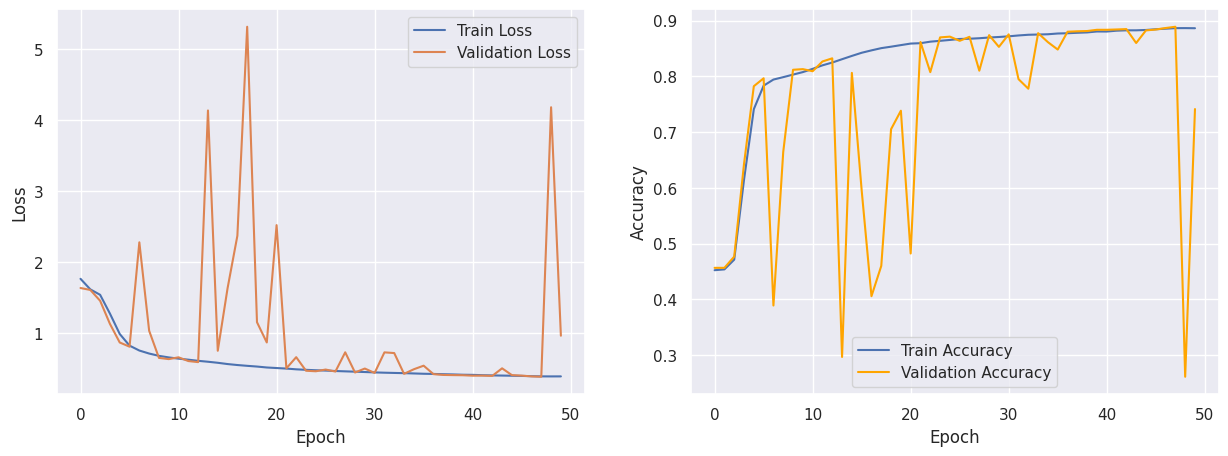

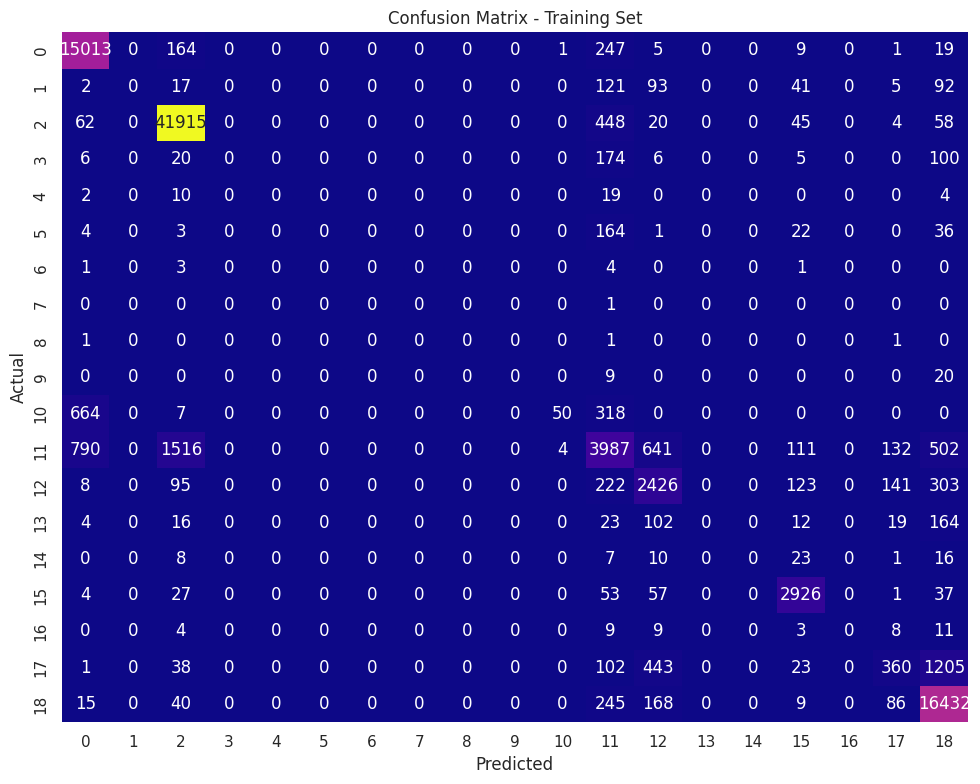


Trial 7/16: Hidden Units - [256, 256], Dropout Rate - 0.3
Epoch 1/50, Train Loss: 1.7721, Train Accuracy: 0.4509, Validation Loss: 1.6222, Validation Accuracy: 0.4566
Epoch 2/50, Train Loss: 1.6175, Train Accuracy: 0.4538, Validation Loss: 1.6140, Validation Accuracy: 0.4566
Epoch 3/50, Train Loss: 1.5505, Train Accuracy: 0.4670, Validation Loss: 1.4719, Validation Accuracy: 0.4726
Epoch 4/50, Train Loss: 1.3119, Train Accuracy: 0.5961, Validation Loss: 1.1870, Validation Accuracy: 0.7079
Epoch 5/50, Train Loss: 1.0367, Train Accuracy: 0.7211, Validation Loss: 1.8501, Validation Accuracy: 0.5378
Epoch 6/50, Train Loss: 0.8489, Train Accuracy: 0.7768, Validation Loss: 0.9203, Validation Accuracy: 0.7314
Epoch 7/50, Train Loss: 0.7623, Train Accuracy: 0.7919, Validation Loss: 0.7379, Validation Accuracy: 0.7932
Epoch 8/50, Train Loss: 0.7167, Train Accuracy: 0.7981, Validation Loss: 1.3677, Validation Accuracy: 0.6232
Epoch 9/50, Train Loss: 0.6874, Train Accuracy: 0.8012, Validation Lo

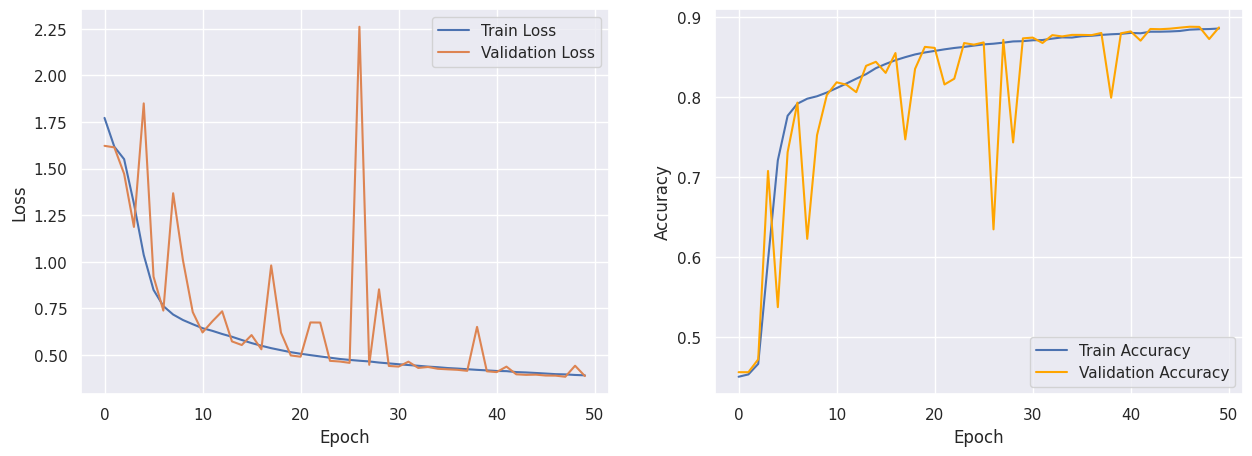

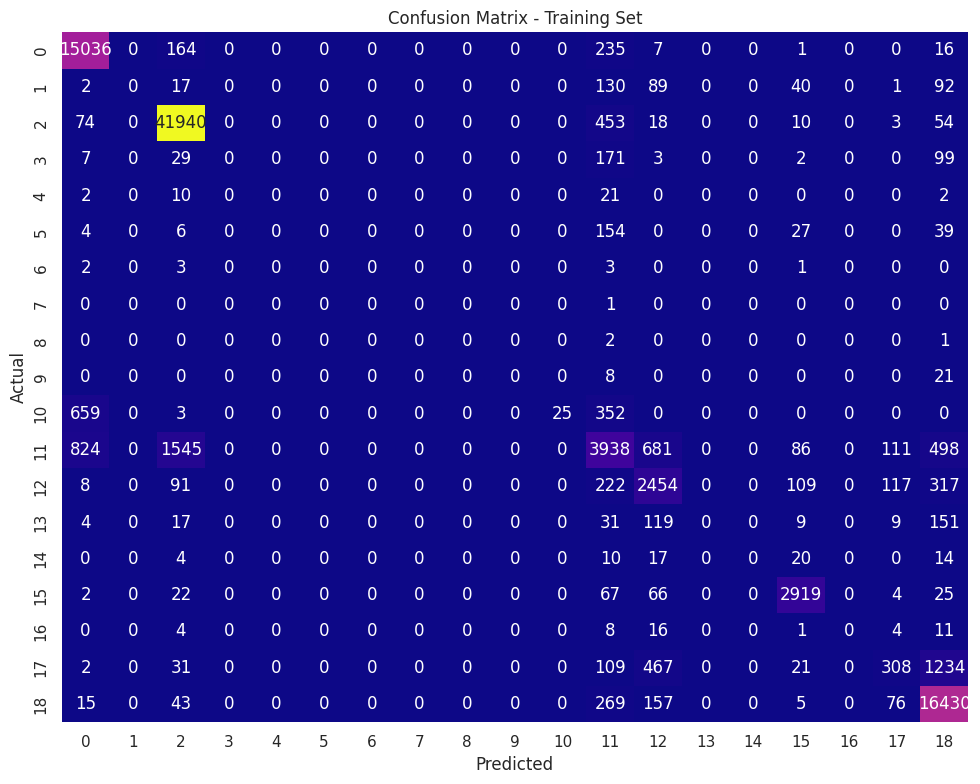


Trial 8/16: Hidden Units - [256, 256], Dropout Rate - 0.4
Epoch 1/50, Train Loss: 1.7828, Train Accuracy: 0.4513, Validation Loss: 1.6409, Validation Accuracy: 0.4566
Epoch 2/50, Train Loss: 1.6221, Train Accuracy: 0.4538, Validation Loss: 1.6046, Validation Accuracy: 0.4566
Epoch 3/50, Train Loss: 1.5671, Train Accuracy: 0.4617, Validation Loss: 1.5113, Validation Accuracy: 0.4571
Epoch 4/50, Train Loss: 1.3680, Train Accuracy: 0.5722, Validation Loss: 1.8049, Validation Accuracy: 0.3198
Epoch 5/50, Train Loss: 1.1471, Train Accuracy: 0.6713, Validation Loss: 1.1044, Validation Accuracy: 0.6411
Epoch 6/50, Train Loss: 0.9357, Train Accuracy: 0.7546, Validation Loss: 0.8515, Validation Accuracy: 0.7665
Epoch 7/50, Train Loss: 0.8120, Train Accuracy: 0.7845, Validation Loss: 0.7551, Validation Accuracy: 0.8000
Epoch 8/50, Train Loss: 0.7487, Train Accuracy: 0.7949, Validation Loss: 0.7210, Validation Accuracy: 0.7925
Epoch 9/50, Train Loss: 0.7119, Train Accuracy: 0.7995, Validation Lo

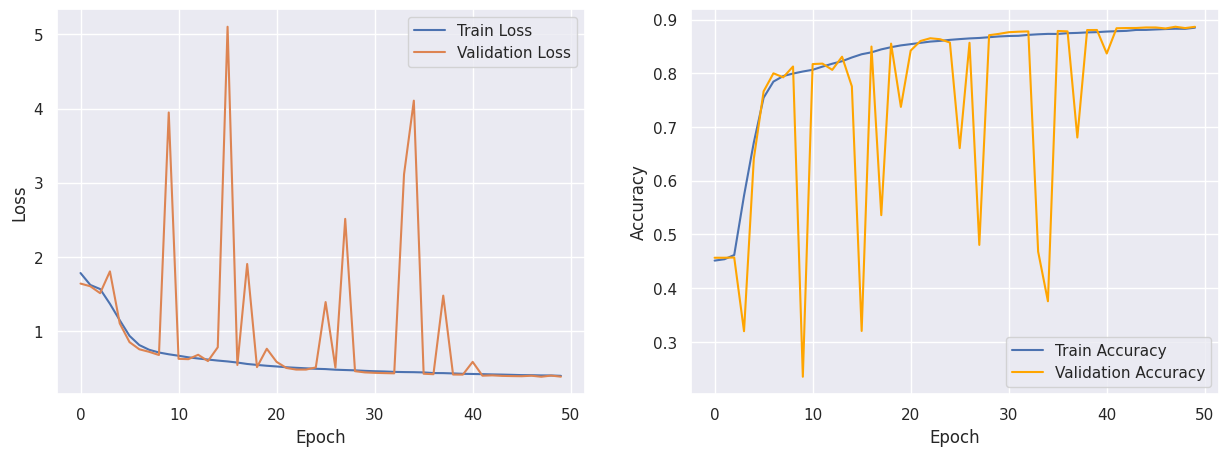

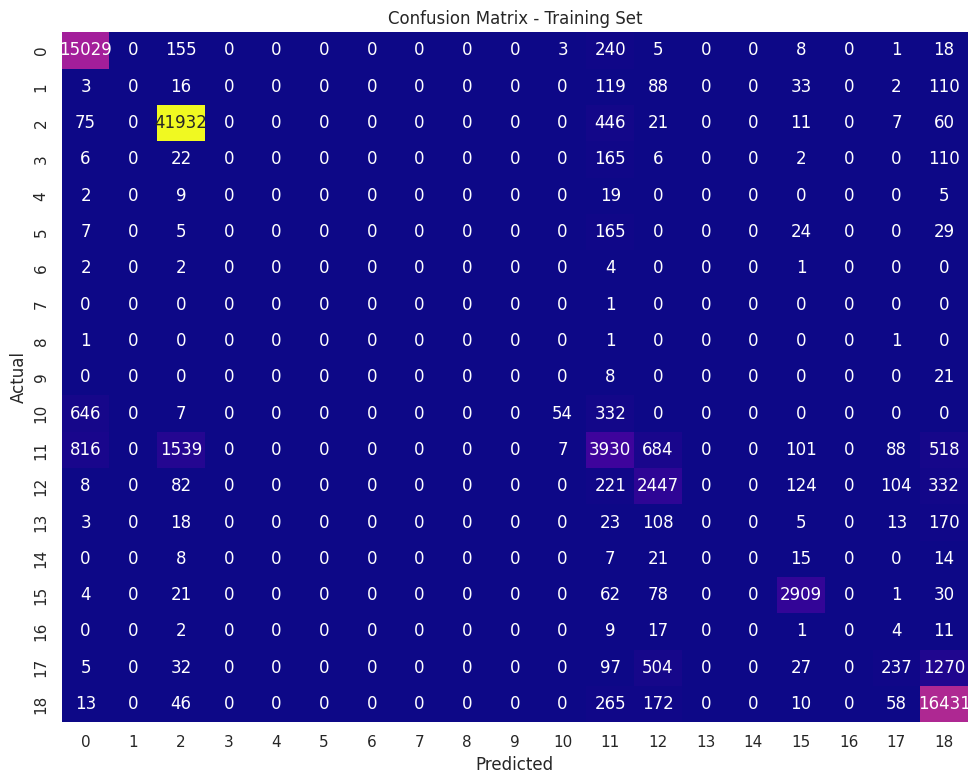


Trial 9/16: Hidden Units - [256, 128], Dropout Rate - 0.1
Epoch 1/50, Train Loss: 1.7619, Train Accuracy: 0.4530, Validation Loss: 1.6380, Validation Accuracy: 0.4566
Epoch 2/50, Train Loss: 1.6102, Train Accuracy: 0.4538, Validation Loss: 1.5979, Validation Accuracy: 0.4566
Epoch 3/50, Train Loss: 1.5252, Train Accuracy: 0.4798, Validation Loss: 1.4359, Validation Accuracy: 0.5785
Epoch 4/50, Train Loss: 1.2807, Train Accuracy: 0.6160, Validation Loss: 1.2374, Validation Accuracy: 0.5965
Epoch 5/50, Train Loss: 1.0308, Train Accuracy: 0.7262, Validation Loss: 0.9924, Validation Accuracy: 0.7063
Epoch 6/50, Train Loss: 0.8478, Train Accuracy: 0.7765, Validation Loss: 0.8447, Validation Accuracy: 0.7629
Epoch 7/50, Train Loss: 0.7588, Train Accuracy: 0.7936, Validation Loss: 0.7184, Validation Accuracy: 0.8012
Epoch 8/50, Train Loss: 0.7116, Train Accuracy: 0.8009, Validation Loss: 0.7038, Validation Accuracy: 0.8043
Epoch 9/50, Train Loss: 0.6797, Train Accuracy: 0.8045, Validation Lo

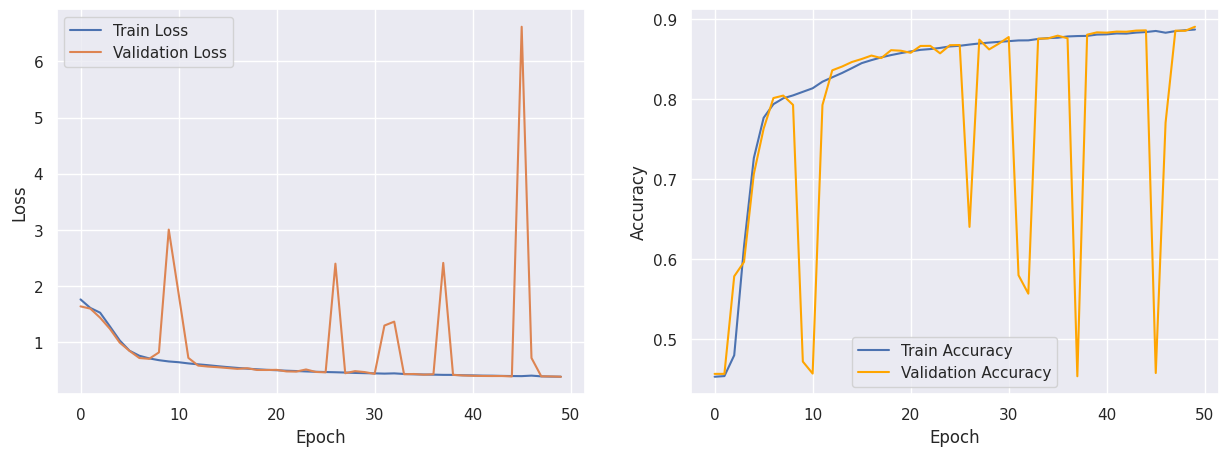

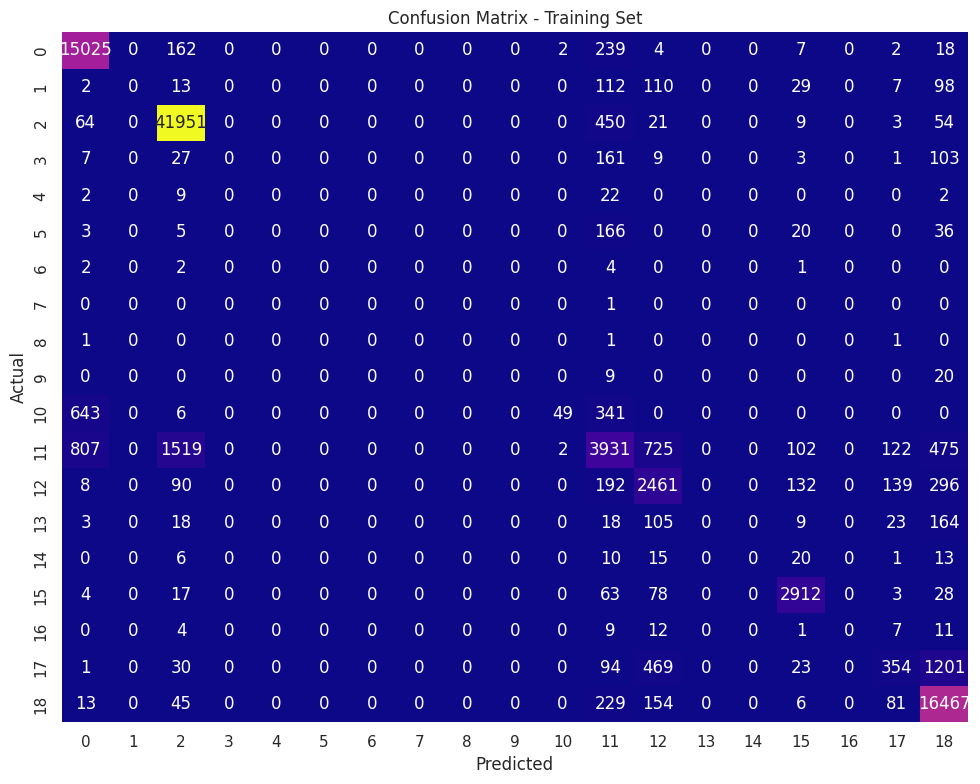


Trial 10/16: Hidden Units - [256, 128], Dropout Rate - 0.2
Epoch 1/50, Train Loss: 1.7754, Train Accuracy: 0.4465, Validation Loss: 1.6317, Validation Accuracy: 0.4566
Epoch 2/50, Train Loss: 1.6157, Train Accuracy: 0.4538, Validation Loss: 1.5936, Validation Accuracy: 0.4566
Epoch 3/50, Train Loss: 1.5534, Train Accuracy: 0.4656, Validation Loss: 1.5648, Validation Accuracy: 0.4804
Epoch 4/50, Train Loss: 1.3449, Train Accuracy: 0.5855, Validation Loss: 1.2030, Validation Accuracy: 0.6502
Epoch 5/50, Train Loss: 1.1108, Train Accuracy: 0.6977, Validation Loss: 0.9822, Validation Accuracy: 0.7329
Epoch 6/50, Train Loss: 0.9051, Train Accuracy: 0.7609, Validation Loss: 0.8279, Validation Accuracy: 0.7861
Epoch 7/50, Train Loss: 0.7920, Train Accuracy: 0.7861, Validation Loss: 0.8594, Validation Accuracy: 0.7559
Epoch 8/50, Train Loss: 0.7369, Train Accuracy: 0.7958, Validation Loss: 0.8858, Validation Accuracy: 0.7465
Epoch 9/50, Train Loss: 0.7014, Train Accuracy: 0.8006, Validation L

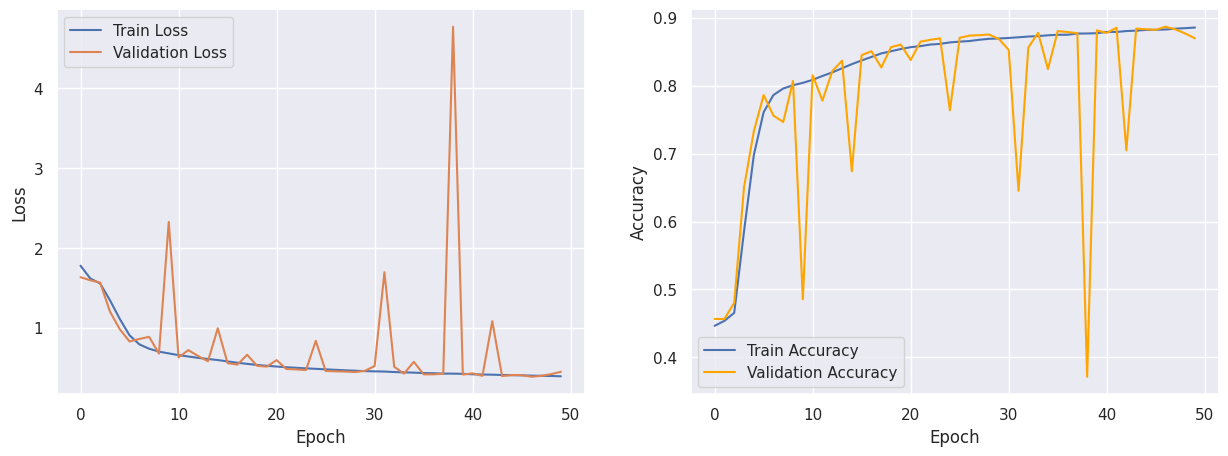

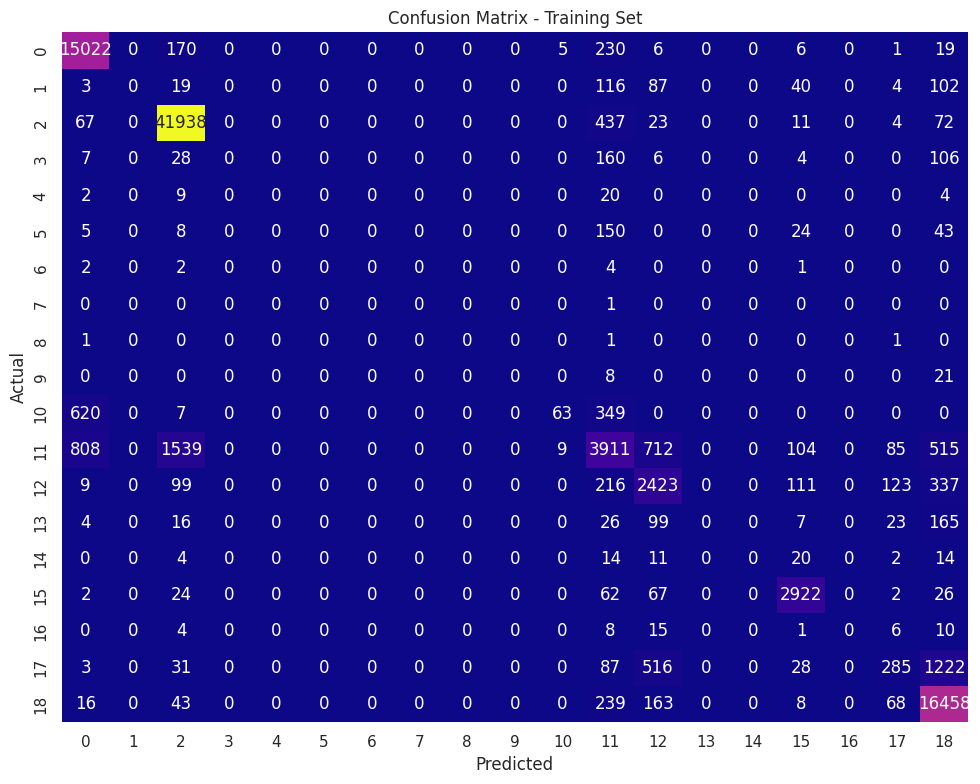


Trial 11/16: Hidden Units - [256, 128], Dropout Rate - 0.3
Epoch 1/50, Train Loss: 1.8033, Train Accuracy: 0.4514, Validation Loss: 1.6294, Validation Accuracy: 0.4566
Epoch 2/50, Train Loss: 1.6263, Train Accuracy: 0.4538, Validation Loss: 1.6129, Validation Accuracy: 0.4566
Epoch 3/50, Train Loss: 1.5985, Train Accuracy: 0.4539, Validation Loss: 1.5739, Validation Accuracy: 0.4566
Epoch 4/50, Train Loss: 1.4710, Train Accuracy: 0.5157, Validation Loss: 1.3304, Validation Accuracy: 0.5952
Epoch 5/50, Train Loss: 1.2414, Train Accuracy: 0.6339, Validation Loss: 1.1422, Validation Accuracy: 0.7185
Epoch 6/50, Train Loss: 1.0179, Train Accuracy: 0.7315, Validation Loss: 2.3888, Validation Accuracy: 0.4619
Epoch 7/50, Train Loss: 0.8622, Train Accuracy: 0.7713, Validation Loss: 0.8270, Validation Accuracy: 0.7682
Epoch 8/50, Train Loss: 0.7839, Train Accuracy: 0.7885, Validation Loss: 0.7481, Validation Accuracy: 0.7899
Epoch 9/50, Train Loss: 0.7414, Train Accuracy: 0.7944, Validation L

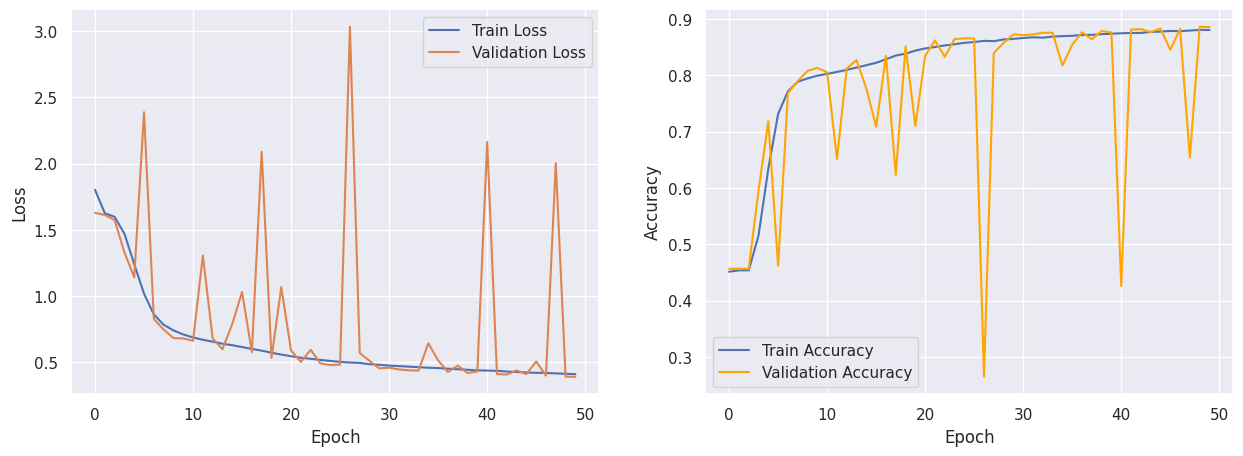

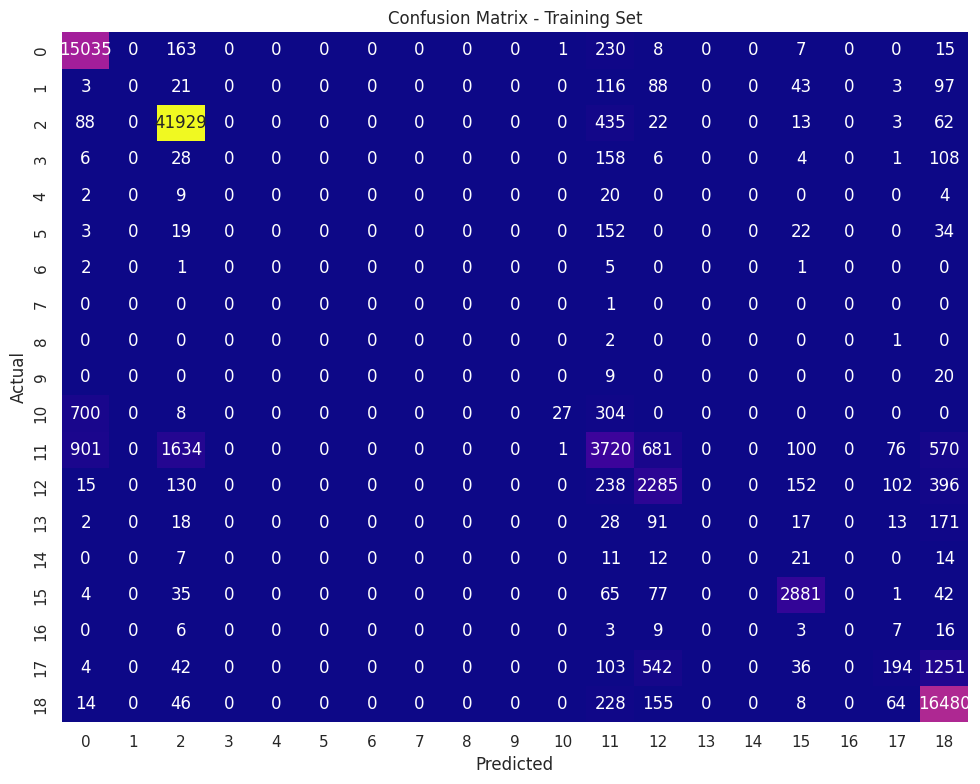


Trial 12/16: Hidden Units - [256, 128], Dropout Rate - 0.4
Epoch 1/50, Train Loss: 1.7878, Train Accuracy: 0.4489, Validation Loss: 1.6256, Validation Accuracy: 0.4566
Epoch 2/50, Train Loss: 1.6245, Train Accuracy: 0.4538, Validation Loss: 1.6005, Validation Accuracy: 0.4566
Epoch 3/50, Train Loss: 1.5705, Train Accuracy: 0.4623, Validation Loss: 1.4889, Validation Accuracy: 0.5405
Epoch 4/50, Train Loss: 1.3867, Train Accuracy: 0.5685, Validation Loss: 1.5495, Validation Accuracy: 0.4559
Epoch 5/50, Train Loss: 1.2074, Train Accuracy: 0.6537, Validation Loss: 1.0809, Validation Accuracy: 0.7088
Epoch 6/50, Train Loss: 1.0247, Train Accuracy: 0.7289, Validation Loss: 0.9171, Validation Accuracy: 0.7487
Epoch 7/50, Train Loss: 0.8751, Train Accuracy: 0.7679, Validation Loss: 0.8599, Validation Accuracy: 0.7702
Epoch 8/50, Train Loss: 0.7931, Train Accuracy: 0.7855, Validation Loss: 0.7277, Validation Accuracy: 0.8063
Epoch 9/50, Train Loss: 0.7462, Train Accuracy: 0.7931, Validation L

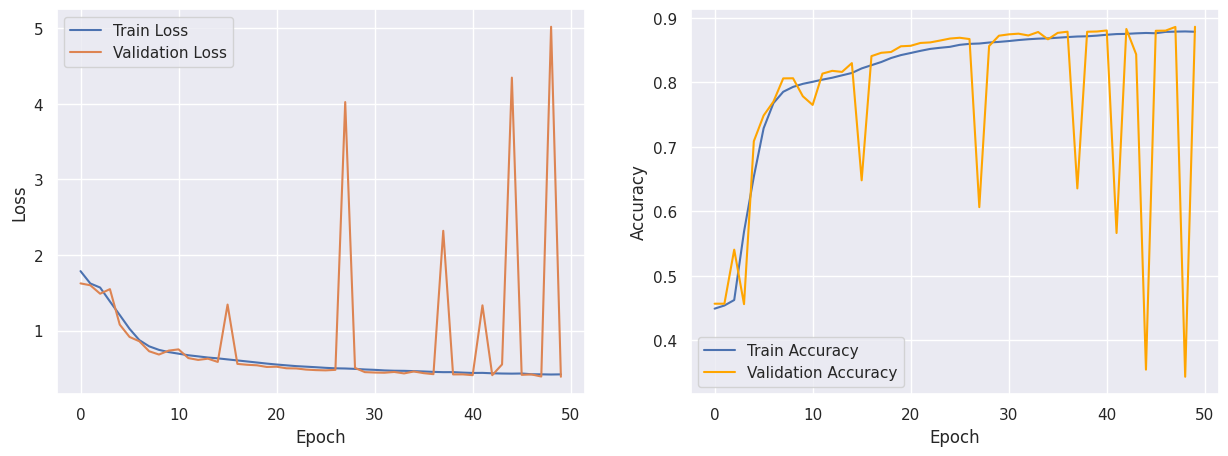

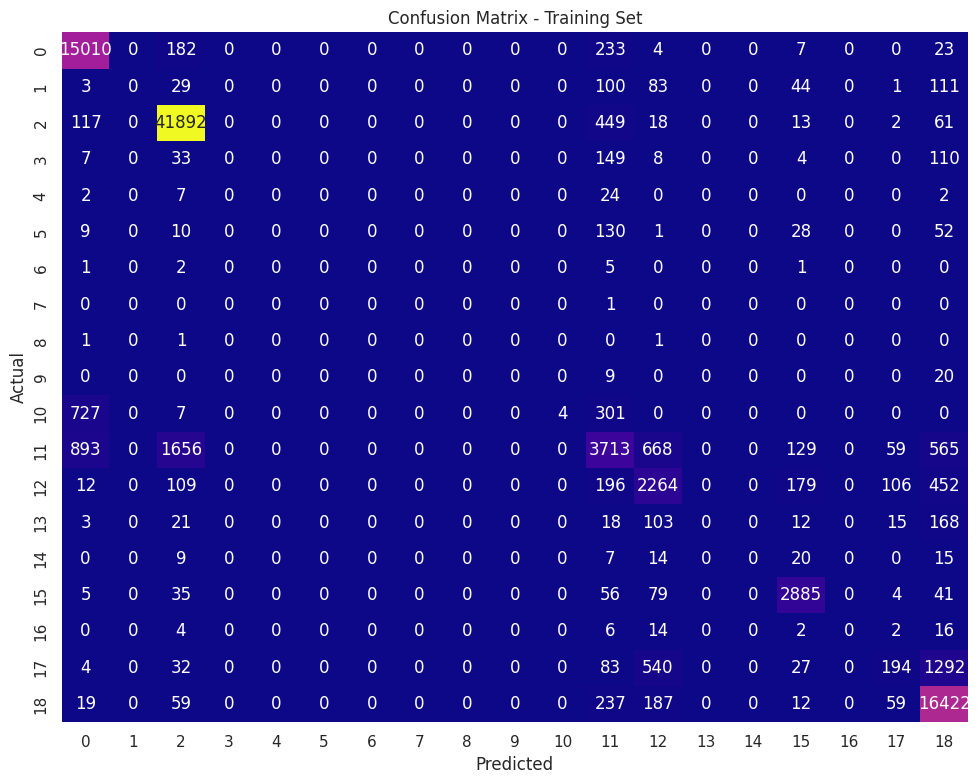


Trial 13/16: Hidden Units - [128, 256], Dropout Rate - 0.1
Epoch 1/50, Train Loss: 1.7542, Train Accuracy: 0.4520, Validation Loss: 1.6367, Validation Accuracy: 0.4566
Epoch 2/50, Train Loss: 1.6103, Train Accuracy: 0.4538, Validation Loss: 1.5913, Validation Accuracy: 0.4566
Epoch 3/50, Train Loss: 1.5167, Train Accuracy: 0.4839, Validation Loss: 1.4352, Validation Accuracy: 0.5060
Epoch 4/50, Train Loss: 1.2630, Train Accuracy: 0.6146, Validation Loss: 1.1696, Validation Accuracy: 0.6710
Epoch 5/50, Train Loss: 1.0162, Train Accuracy: 0.7296, Validation Loss: 0.9679, Validation Accuracy: 0.7240
Epoch 6/50, Train Loss: 0.8324, Train Accuracy: 0.7807, Validation Loss: 1.0311, Validation Accuracy: 0.6865
Epoch 7/50, Train Loss: 0.7449, Train Accuracy: 0.7954, Validation Loss: 0.7508, Validation Accuracy: 0.7860
Epoch 8/50, Train Loss: 0.6987, Train Accuracy: 0.8010, Validation Loss: 0.9082, Validation Accuracy: 0.7427
Epoch 9/50, Train Loss: 0.6686, Train Accuracy: 0.8055, Validation L

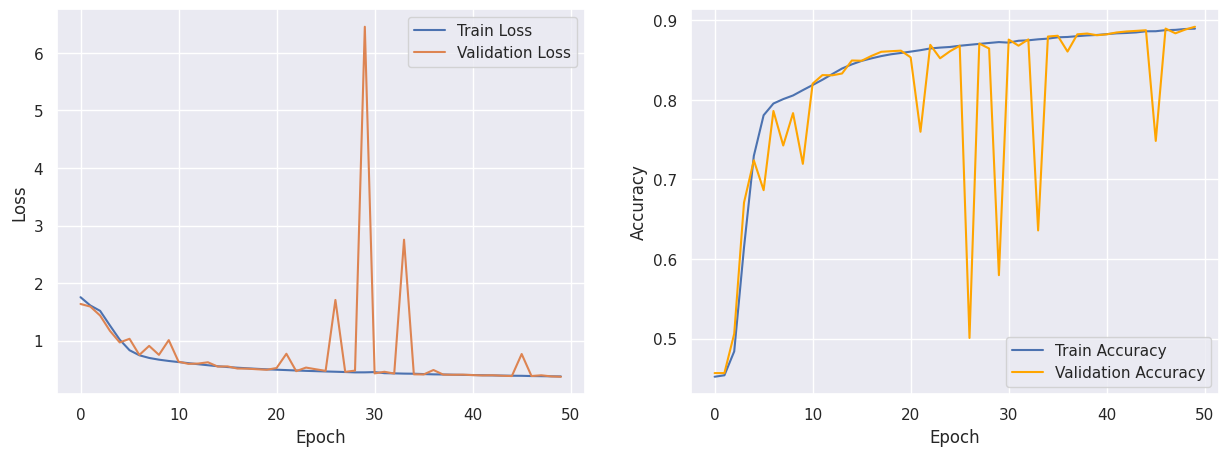

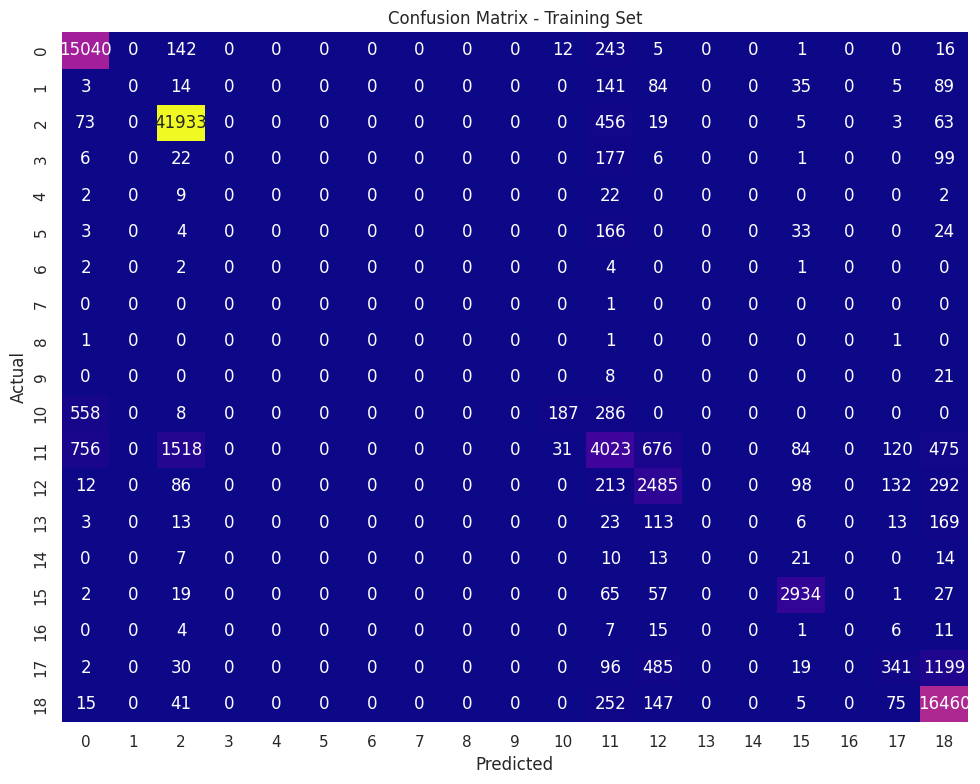


Trial 14/16: Hidden Units - [128, 256], Dropout Rate - 0.2
Epoch 1/50, Train Loss: 1.7663, Train Accuracy: 0.4482, Validation Loss: 1.6205, Validation Accuracy: 0.4566
Epoch 2/50, Train Loss: 1.5973, Train Accuracy: 0.4540, Validation Loss: 1.5598, Validation Accuracy: 0.4568
Epoch 3/50, Train Loss: 1.4405, Train Accuracy: 0.5301, Validation Loss: 1.3010, Validation Accuracy: 0.6001
Epoch 4/50, Train Loss: 1.1976, Train Accuracy: 0.6497, Validation Loss: 1.1643, Validation Accuracy: 0.6737
Epoch 5/50, Train Loss: 0.9681, Train Accuracy: 0.7447, Validation Loss: 1.0061, Validation Accuracy: 0.7029
Epoch 6/50, Train Loss: 0.8160, Train Accuracy: 0.7830, Validation Loss: 0.7978, Validation Accuracy: 0.7780
Epoch 7/50, Train Loss: 0.7448, Train Accuracy: 0.7957, Validation Loss: 0.7186, Validation Accuracy: 0.8073
Epoch 8/50, Train Loss: 0.7015, Train Accuracy: 0.8018, Validation Loss: 0.6776, Validation Accuracy: 0.8098
Epoch 9/50, Train Loss: 0.6740, Train Accuracy: 0.8049, Validation L

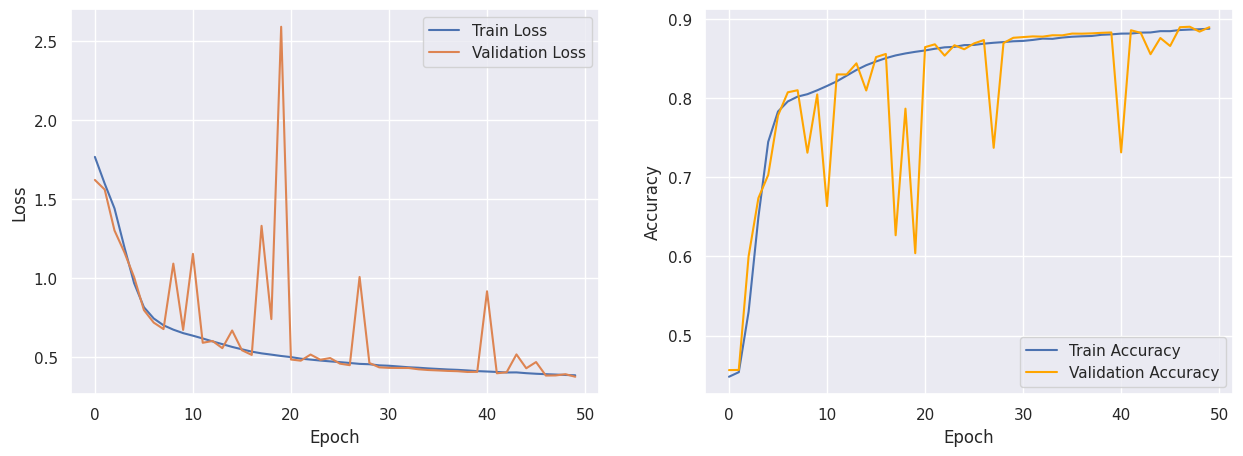

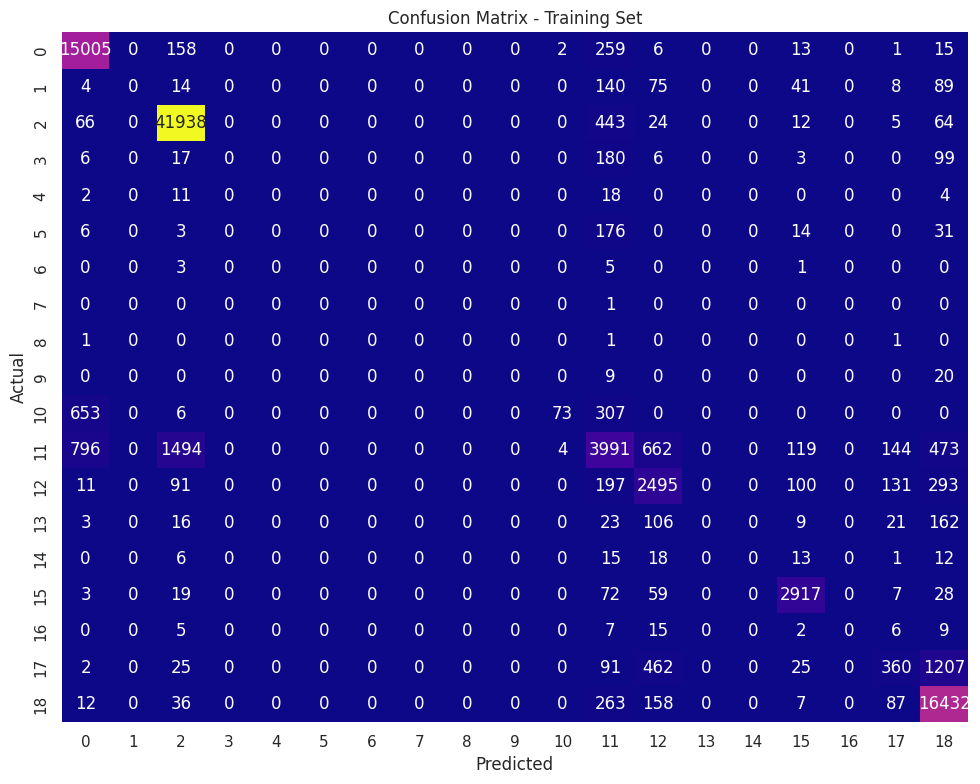


Trial 15/16: Hidden Units - [128, 256], Dropout Rate - 0.3
Epoch 1/50, Train Loss: 1.7610, Train Accuracy: 0.4498, Validation Loss: 1.6250, Validation Accuracy: 0.4566
Epoch 2/50, Train Loss: 1.6069, Train Accuracy: 0.4538, Validation Loss: 1.5774, Validation Accuracy: 0.4566
Epoch 3/50, Train Loss: 1.4871, Train Accuracy: 0.5014, Validation Loss: 1.3495, Validation Accuracy: 0.5597
Epoch 4/50, Train Loss: 1.2178, Train Accuracy: 0.6505, Validation Loss: 1.0681, Validation Accuracy: 0.7008
Epoch 5/50, Train Loss: 0.9656, Train Accuracy: 0.7471, Validation Loss: 1.8170, Validation Accuracy: 0.4116
Epoch 6/50, Train Loss: 0.8169, Train Accuracy: 0.7814, Validation Loss: 0.7891, Validation Accuracy: 0.7947
Epoch 7/50, Train Loss: 0.7466, Train Accuracy: 0.7933, Validation Loss: 0.7313, Validation Accuracy: 0.7912
Epoch 8/50, Train Loss: 0.7059, Train Accuracy: 0.7997, Validation Loss: 0.6731, Validation Accuracy: 0.8082
Epoch 9/50, Train Loss: 0.6785, Train Accuracy: 0.8037, Validation L

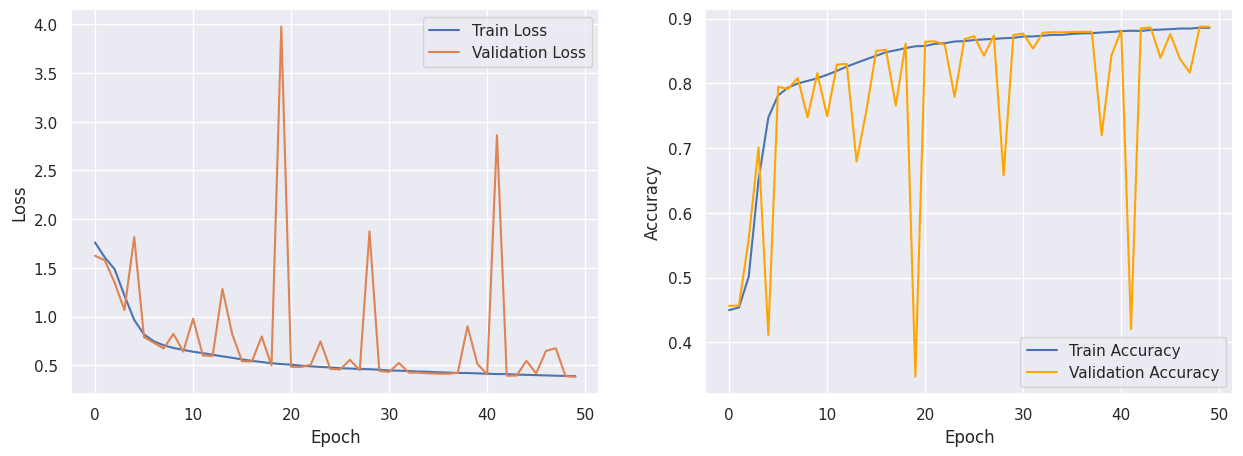

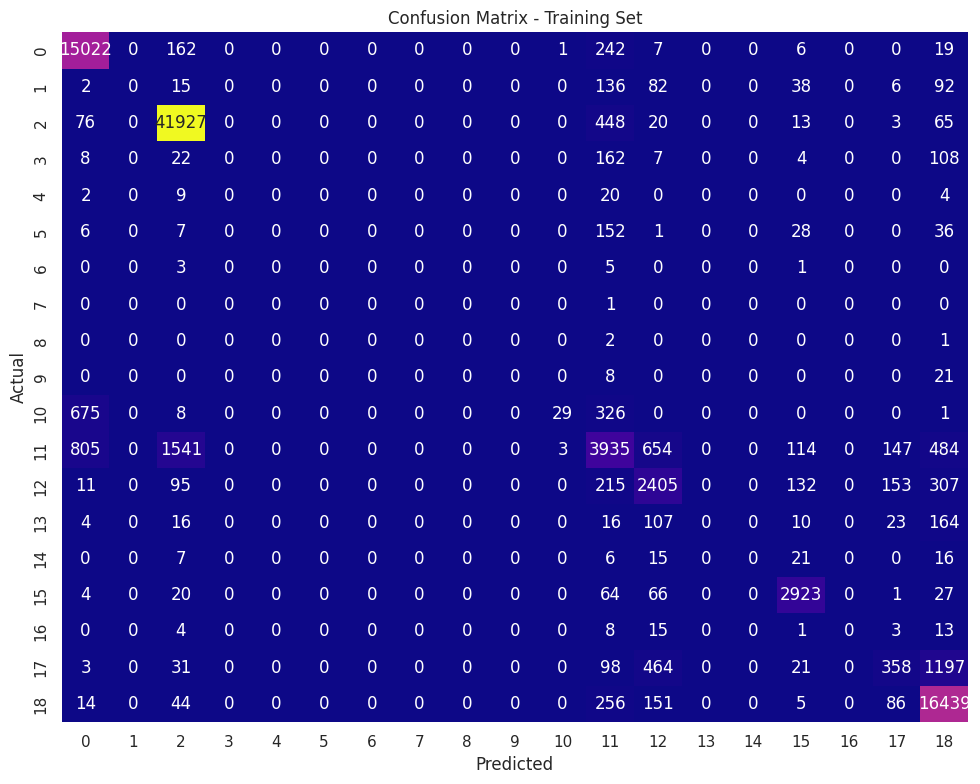


Trial 16/16: Hidden Units - [128, 256], Dropout Rate - 0.4
Epoch 1/50, Train Loss: 1.7435, Train Accuracy: 0.4533, Validation Loss: 1.6220, Validation Accuracy: 0.4566
Epoch 2/50, Train Loss: 1.6159, Train Accuracy: 0.4538, Validation Loss: 1.5920, Validation Accuracy: 0.4566
Epoch 3/50, Train Loss: 1.5452, Train Accuracy: 0.4662, Validation Loss: 1.4609, Validation Accuracy: 0.5696
Epoch 4/50, Train Loss: 1.3050, Train Accuracy: 0.6143, Validation Loss: 1.1331, Validation Accuracy: 0.7137
Epoch 5/50, Train Loss: 1.0281, Train Accuracy: 0.7304, Validation Loss: 0.8914, Validation Accuracy: 0.7675
Epoch 6/50, Train Loss: 0.8536, Train Accuracy: 0.7728, Validation Loss: 0.9825, Validation Accuracy: 0.7294
Epoch 7/50, Train Loss: 0.7707, Train Accuracy: 0.7895, Validation Loss: 0.7137, Validation Accuracy: 0.8044
Epoch 8/50, Train Loss: 0.7256, Train Accuracy: 0.7966, Validation Loss: 0.6841, Validation Accuracy: 0.8062
Epoch 9/50, Train Loss: 0.6941, Train Accuracy: 0.8015, Validation L

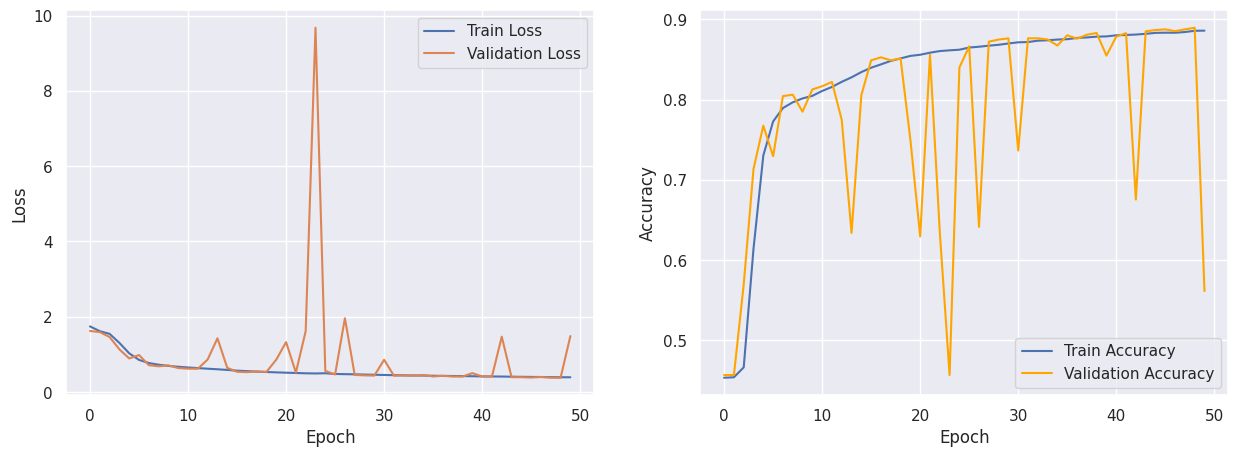

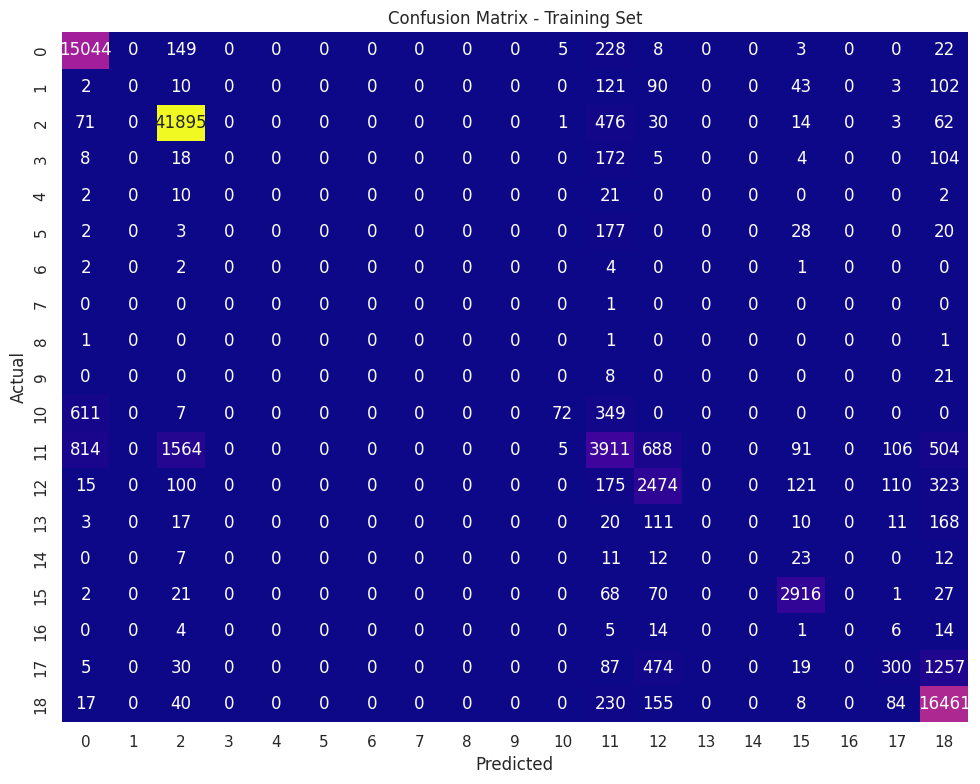


Best Hyperparameters:
Hidden Units: [128, 256], Dropout Rate: 0.1

Best Metrics:
{'train_loss': 0.3771176619396772, 'val_loss': 0.3717227986802353, 'train_accuracy': 0.8895276287582257, 'val_accuracy': 0.8919178345171818}


In [80]:
learning_rate = 0.01
# hyperparameter search space
hidden_units_list = [[128, 128], [256, 256], [256, 128], [128, 256]]
dropout_rates_list = [0.1, 0.2, 0.3, 0.4]

# no. of trials
num_trials = len(hidden_units_list) * len(dropout_rates_list)

# Storing results for all trials
results = []

for i, (hidden_units, dropout_rate) in enumerate(product(hidden_units_list, dropout_rates_list), start=1):
    print(f"\nTrial {i}/{num_trials}: Hidden Units - {hidden_units}, Dropout Rate - {dropout_rate}")

    # Create and train the model
    model = TimeSeriesMLP(input_size=620, output_size=19, hidden_units=hidden_units, dropout_rate=dropout_rate).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Train and evaluate the model
    trained_model, metrics = train_evaluate_plot_model(model, train_loader, val_loader, optimizer, num_epochs=50, learning_rate=learning_rate, device=device)

    # Storing the results for this trial
    results.append({
        'hidden_units': hidden_units,
        'dropout_rate': dropout_rate,
        'metrics': metrics
    })

    # # Plot Confusion Matrix
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(confusion_matrix_data, annot=True, fmt='g', cmap='Blues', cbar=False)
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.title(f'Confusion Matrix - Trial {i}/{num_trials}')
    # plt.show()

# best set of hyperparameters based on validation accuracy
best_result = min(results, key=lambda x: x['metrics']['val_loss'])
best_hidden_units = best_result['hidden_units']
best_dropout_rate = best_result['dropout_rate']
best_metrics = best_result['metrics']

print("\nBest Hyperparameters:")
print(f"Hidden Units: {best_hidden_units}, Dropout Rate: {best_dropout_rate}")
print("\nBest Metrics:")
print(best_metrics)


**Interpretation**



**Best Hyperparameters:**

Hidden Units: [128, 256], Dropout Rate: 0.1

**Best Metrics:**

{'train_loss': 0.3771176619396772, 'val_loss': 0.3717227986802353, 'train_accuracy': 0.8895276287582257, 'val_accuracy': 0.8919178345171818}

Under the given ***best_network_hyperparams*** we have got better an improved model that can perform good with the test data.
We will not record these metrics rather use them to tune the model and use the best params from the previous hyperparameter tuning and record the metrics from the updated model.

**NOTE:** Refer to `Comparison Table` to see the overall performance of models under different conditions

### 3.1.6. MLP - after dropping minority classes

Everything remains the same except for the `output_size`: Number of output classes, set to 12. In addition, we would load `new_train` and `new_val` dataset.

In [81]:
# merger_model = TimeSeriesMLP(620, 19, hidden_units=[256,256]).to(device)
# print(merger_model)

In [82]:
# summary(merger_model, (620,))  # input shape: (n_features)

In [83]:
# # model = TimeSeriesMLP(620, 13, hidden_units=[256,256]).to(device)
# learning_rate = 0.001
# optimizer = optim.SGD(merger_model.parameters(), lr=learning_rate)
# trained_model = train_evaluate_plot_model(merger_model, new_train_loader, new_val_loader, optimizer, num_epochs=50)

In [84]:
# tested_model = test_model(merger_model, new_test_loader)
# tested_model

### 3.1.8. Hyperparameter tuning after dropping minority classes

In [85]:
# from itertools import product

# # Define hyperparameter search space
# param_space = {
#     'num_epochs': [25, 50, 75],
#     'learning_rate': [0.0001, 0.001, 0.01],
#     'optimizer': [optim.Adam, optim.SGD]
# }

# # Number of trials
# num_trials = 5

# # Store results for all trials
# results = []

# # Create a ParameterGrid from the hyperparameter search space
# param_grid = list(product(param_space['num_epochs'], param_space['learning_rate'], param_space['optimizer']))

# for i, (num_epochs, learning_rate, optimizer) in enumerate(param_grid):
#     print(f"\nIteration {i + 1}: Hyperparameters - Num Epochs: {num_epochs}, Learning Rate: {learning_rate}, Optimizer: {optimizer.__name__}")

#     # Train and evaluate the model
#     model, metrics = train_evaluate_plot_model(all_label_model,
#                                                train_loader=train_loader, val_loader=val_loader,
#                                                optimizer=optimizer(all_label_model.parameters(), lr=learning_rate),
#                                                num_epochs=num_epochs,
#                                                learning_rate=learning_rate,
#                                                device=device)

#     # Store the results for this trial
#     results.append({
#         'hyperparameters': {'num_epochs': num_epochs, 'learning_rate': learning_rate, 'optimizer': optimizer.__name__},
#         'metrics': metrics
#     })

# # best set of hyperparameters based on validation accuracy
# best_result = min(results, key=lambda x: x['metrics']['val_loss'])
# best_hyperparameters = best_result['hyperparameters']
# best_metrics = best_result['metrics']

# print("\nBest Hyperparameters:")
# print(best_hyperparameters)
# print("\nBest Metrics:")
# print(best_metrics)


## 3.2 LSTM

### 3.2.1. Model Class Definition

In [86]:

class TimeSeriesLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(TimeSeriesLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the last time step's output for prediction
        return out


### 3.2.2. Architecture



The TimeSeriesLSTM model is built using Long Short-Term Memory (LSTM) cells, a type of recurrent neural network (RNN).
It takes a sequence of input data (x) where each element represents a time step.
The LSTM layer processes the `input` sequence and produces `hidden states` at each time step.
The final `hidden state` corresponding to the last time step is used for prediction through a fully connected `(linear)` layer.
The output size of the linear layer is determined by `output_size`.

- [reference: this description is written with the help of AI]




```plaintext
TimeSeriesLSTM Architecture:
---------------------------
Input (Size: [batch_size, seq_len, input_size])
  ↓
LSTM (input_size, hidden_size, num_layers, batch_first=True)
  ↓
Linear (Output: [batch_size, output_size])
  ↓
Output (Size: [batch_size, output_size])

```


### 3.2.3. Model Instance

In [87]:

input_size = 10  # Assuming 10 features in your input
hidden_size = 64
output_size = 19
num_layers = 1

# Create the model
lstm_model = TimeSeriesLSTM(input_size, hidden_size, output_size, num_layers)


In [88]:

# Get all trainable parameters
trainable_params = [param for param in lstm_model.parameters() if param.requires_grad]
total_trainable_params = sum(p.numel() for p in trainable_params)
print("\nNumber of Trainable Parameters: ", total_trainable_params)



Number of Trainable Parameters:  20691


### 3.2.4 LSTM - Train and Validation ~ for all classes

Epoch 1/50, Train Loss: 1.6525, Train Accuracy: 0.4512, Validation Loss: 1.6241, Validation Accuracy: 0.4566
Epoch 2/50, Train Loss: 1.6240, Train Accuracy: 0.4527, Validation Loss: 1.6230, Validation Accuracy: 0.4566
Epoch 3/50, Train Loss: 1.6189, Train Accuracy: 0.4545, Validation Loss: 1.5107, Validation Accuracy: 0.4960
Epoch 4/50, Train Loss: 1.0152, Train Accuracy: 0.6933, Validation Loss: 1.2641, Validation Accuracy: 0.6143
Epoch 5/50, Train Loss: 0.7374, Train Accuracy: 0.7835, Validation Loss: 0.7069, Validation Accuracy: 0.7961
Epoch 6/50, Train Loss: 0.6528, Train Accuracy: 0.8104, Validation Loss: 1.4238, Validation Accuracy: 0.6145
Epoch 7/50, Train Loss: 0.6255, Train Accuracy: 0.8183, Validation Loss: 1.0470, Validation Accuracy: 0.6948
Epoch 8/50, Train Loss: 0.5824, Train Accuracy: 0.8314, Validation Loss: 0.5645, Validation Accuracy: 0.8333
Epoch 9/50, Train Loss: 0.5497, Train Accuracy: 0.8401, Validation Loss: 0.5249, Validation Accuracy: 0.8467
Epoch 10/50, Train 

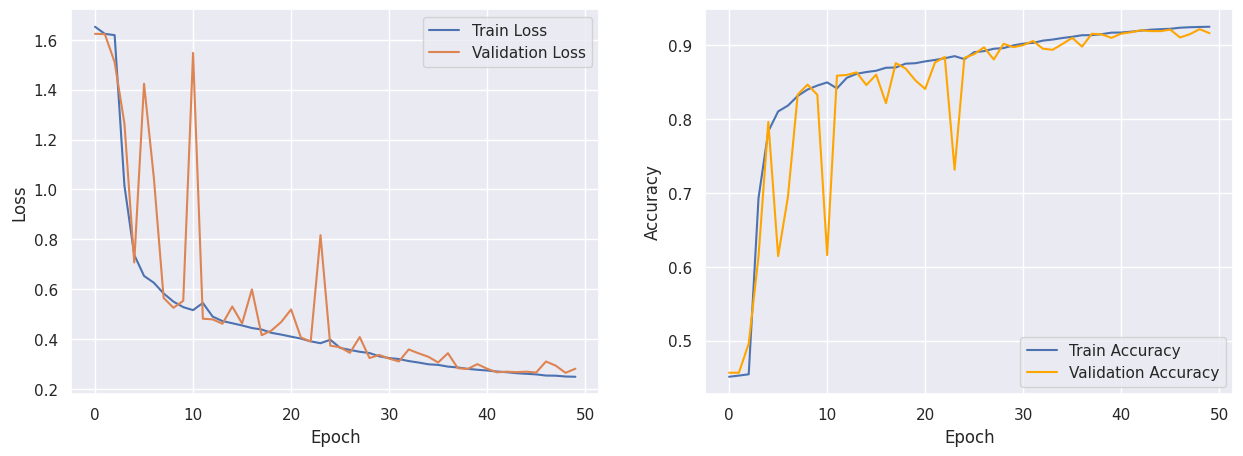

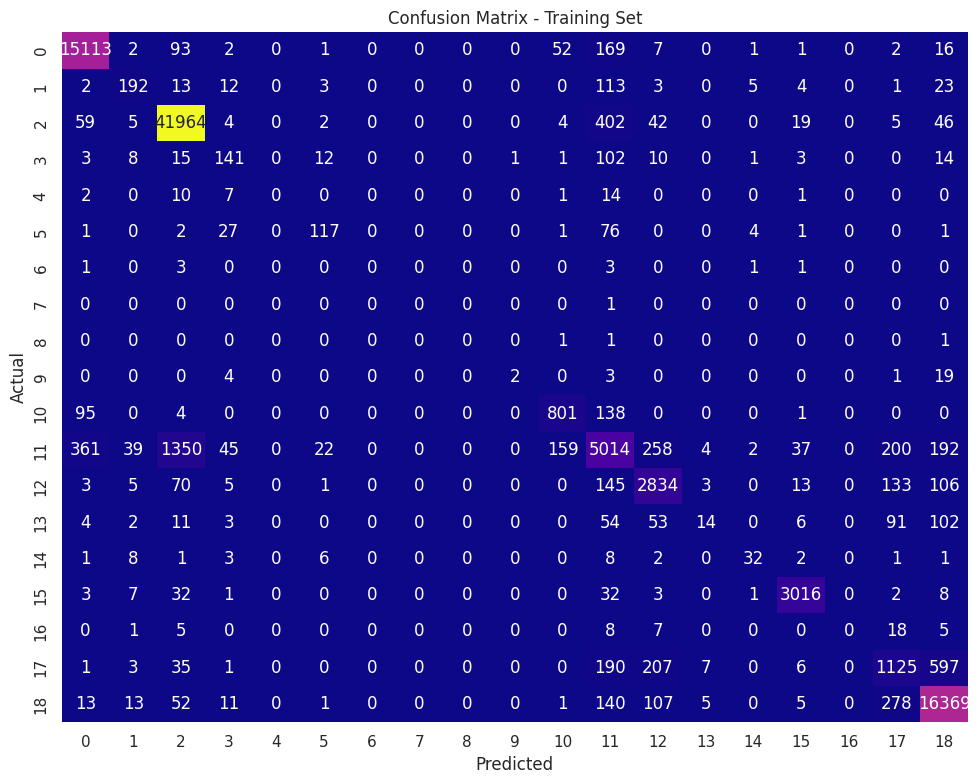

In [89]:
learning_rate=0.001
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
train_lstm_model, metrics = train_evaluate_plot_model(lstm_model, train_loader, val_loader, optimizer, num_epochs=50)

**Interpretation**

The `loss & accuracy` graph has relatively higher fluctuation and the accuracy slightly lower than MLP. This may very well be because of the noise the minority classes bring into the equation.


`Best Metrics (Based on Validation Loss):`

 {'train_loss': 0.2492603564972889, 'val_loss': 0.26401401695115434, 'train_accuracy': 0.9247768261857275, 'val_accuracy': 0.9218660011518526}



Test Accuracy: 0.916


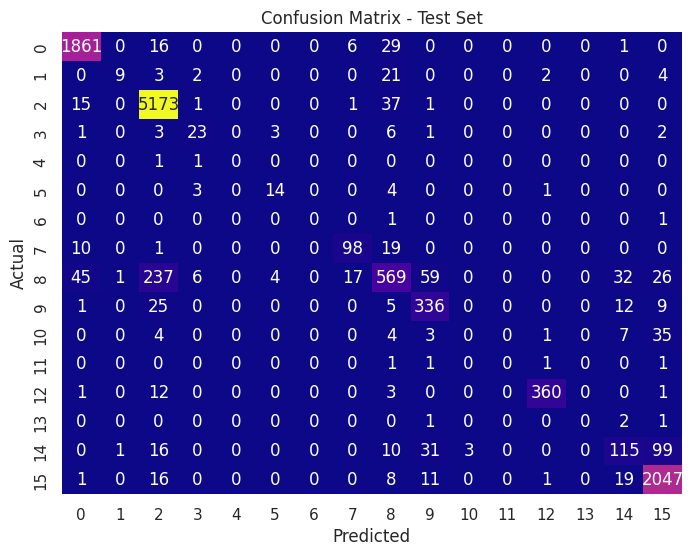

In [90]:
test_model(train_lstm_model, test_loader)

**Interpretation**

The `Confusion Matrix` we observe is different from the one for training set, it is because of the poor splitting strategy in this example. We could improve the pre-processing of the data and make it look better again. If we see a high performance on test data it is merely because of the data ignorance by the model.

### 3.2.5 Hyperparameter tuning ~ for all classes


Iteration 1: Hyperparameters - Num Epochs: 50, Learning Rate: 0.0001, Optimizer: Adam
Epoch 1/50, Train Loss: 0.2140, Train Accuracy: 0.9368, Validation Loss: 0.2387, Validation Accuracy: 0.9300
Epoch 2/50, Train Loss: 0.2125, Train Accuracy: 0.9372, Validation Loss: 0.2399, Validation Accuracy: 0.9286
Epoch 3/50, Train Loss: 0.2118, Train Accuracy: 0.9371, Validation Loss: 0.2379, Validation Accuracy: 0.9294
Epoch 4/50, Train Loss: 0.2113, Train Accuracy: 0.9374, Validation Loss: 0.2370, Validation Accuracy: 0.9286
Epoch 5/50, Train Loss: 0.2129, Train Accuracy: 0.9382, Validation Loss: 0.2361, Validation Accuracy: 0.9303
Epoch 6/50, Train Loss: 0.2102, Train Accuracy: 0.9379, Validation Loss: 0.2366, Validation Accuracy: 0.9307
Epoch 7/50, Train Loss: 0.2087, Train Accuracy: 0.9389, Validation Loss: 0.2351, Validation Accuracy: 0.9308
Epoch 8/50, Train Loss: 0.2082, Train Accuracy: 0.9386, Validation Loss: 0.2366, Validation Accuracy: 0.9312
Epoch 9/50, Train Loss: 0.2079, Train Acc

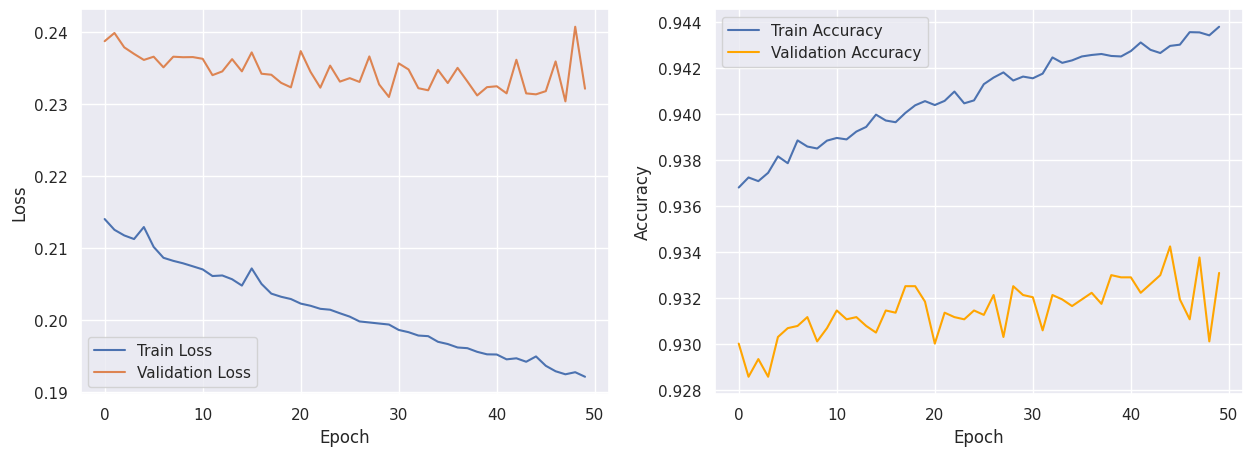

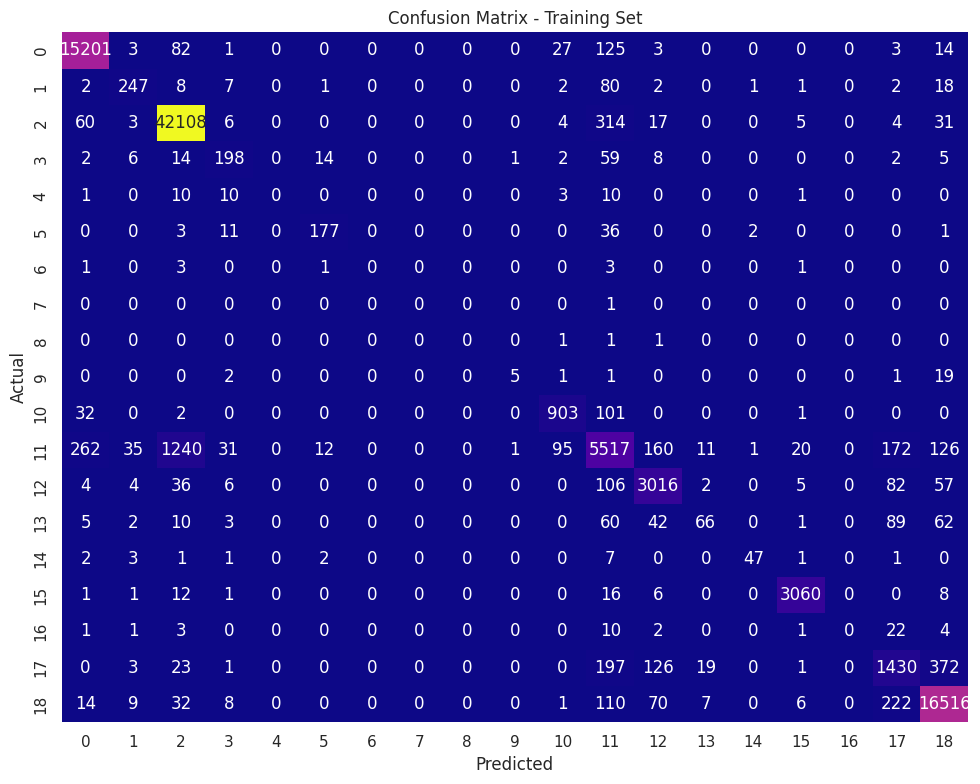


Iteration 2: Hyperparameters - Num Epochs: 50, Learning Rate: 0.0001, Optimizer: SGD
Epoch 1/50, Train Loss: 0.1876, Train Accuracy: 0.9456, Validation Loss: 0.2304, Validation Accuracy: 0.9337
Epoch 2/50, Train Loss: 0.1873, Train Accuracy: 0.9455, Validation Loss: 0.2306, Validation Accuracy: 0.9333
Epoch 3/50, Train Loss: 0.1872, Train Accuracy: 0.9456, Validation Loss: 0.2305, Validation Accuracy: 0.9339
Epoch 4/50, Train Loss: 0.1874, Train Accuracy: 0.9456, Validation Loss: 0.2321, Validation Accuracy: 0.9332
Epoch 5/50, Train Loss: 0.1874, Train Accuracy: 0.9459, Validation Loss: 0.2322, Validation Accuracy: 0.9337
Epoch 6/50, Train Loss: 0.1879, Train Accuracy: 0.9457, Validation Loss: 0.2334, Validation Accuracy: 0.9310
Epoch 7/50, Train Loss: 0.1871, Train Accuracy: 0.9459, Validation Loss: 0.2301, Validation Accuracy: 0.9336
Epoch 8/50, Train Loss: 0.1871, Train Accuracy: 0.9458, Validation Loss: 0.2311, Validation Accuracy: 0.9331
Epoch 9/50, Train Loss: 0.1871, Train Accu

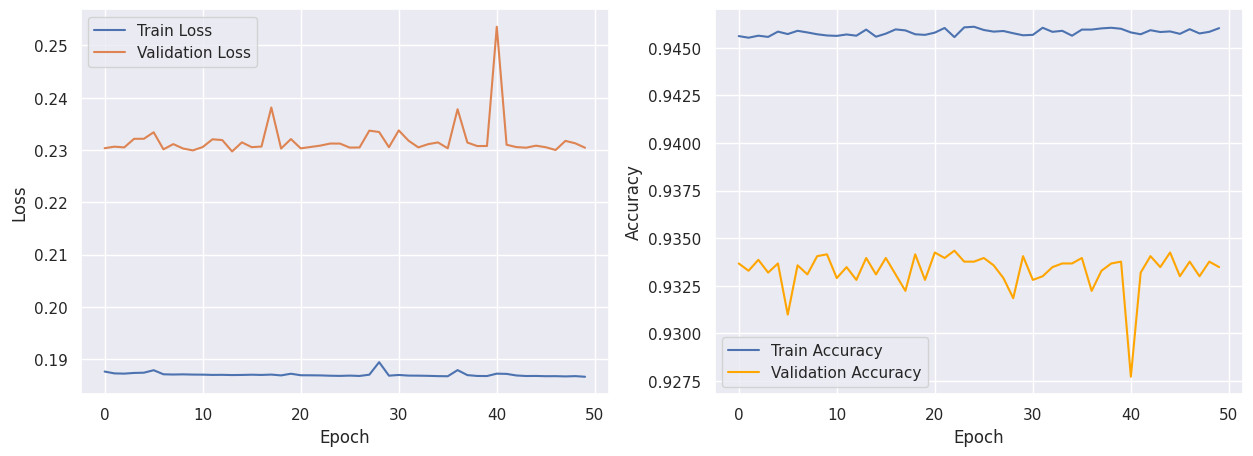

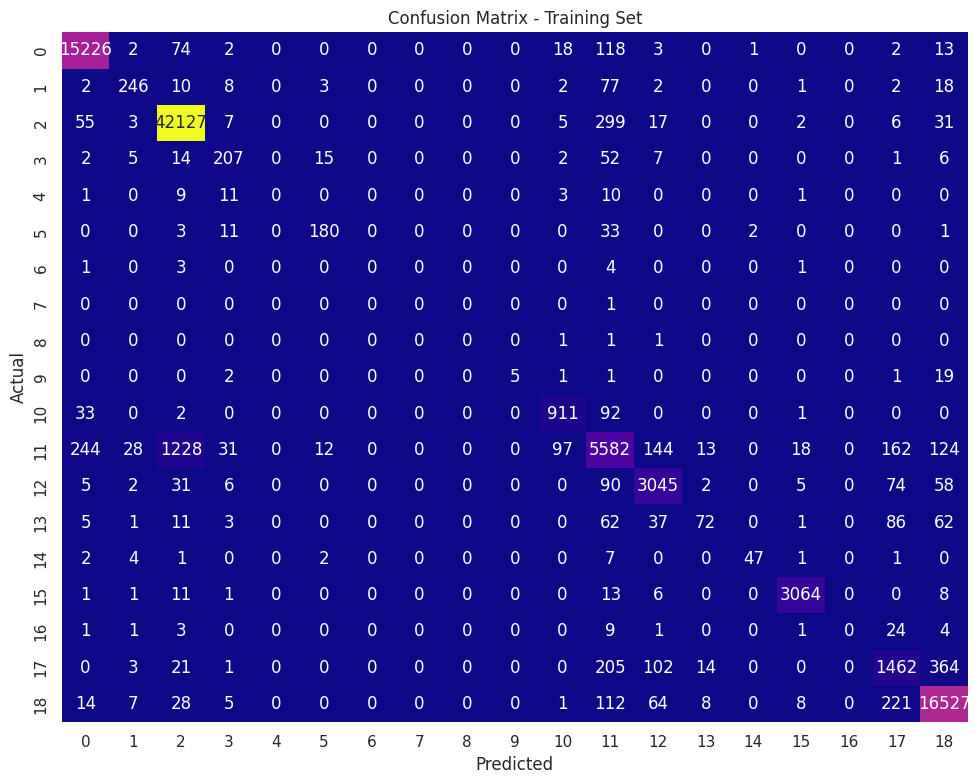


Iteration 3: Hyperparameters - Num Epochs: 50, Learning Rate: 0.001, Optimizer: Adam
Epoch 1/50, Train Loss: 0.2332, Train Accuracy: 0.9295, Validation Loss: 0.2744, Validation Accuracy: 0.9202
Epoch 2/50, Train Loss: 0.2317, Train Accuracy: 0.9301, Validation Loss: 0.2605, Validation Accuracy: 0.9221
Epoch 3/50, Train Loss: 0.2303, Train Accuracy: 0.9308, Validation Loss: 0.2737, Validation Accuracy: 0.9219
Epoch 4/50, Train Loss: 0.2321, Train Accuracy: 0.9307, Validation Loss: 0.2891, Validation Accuracy: 0.9169
Epoch 5/50, Train Loss: 0.2350, Train Accuracy: 0.9299, Validation Loss: 0.2432, Validation Accuracy: 0.9293
Epoch 6/50, Train Loss: 0.2267, Train Accuracy: 0.9316, Validation Loss: 0.2603, Validation Accuracy: 0.9246
Epoch 7/50, Train Loss: 0.2254, Train Accuracy: 0.9322, Validation Loss: 0.2589, Validation Accuracy: 0.9238
Epoch 8/50, Train Loss: 0.2244, Train Accuracy: 0.9328, Validation Loss: 0.2505, Validation Accuracy: 0.9259
Epoch 9/50, Train Loss: 0.2224, Train Accu

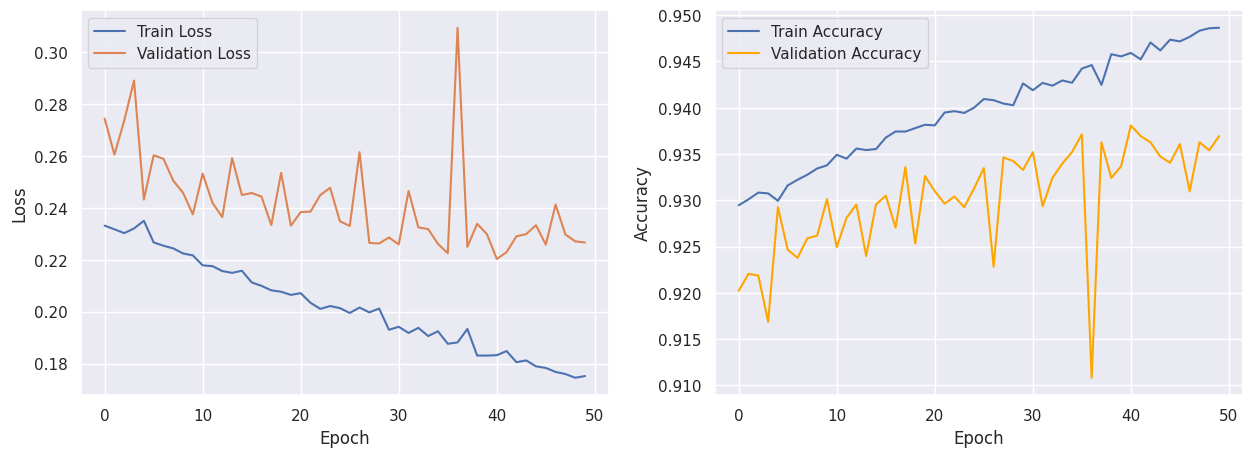

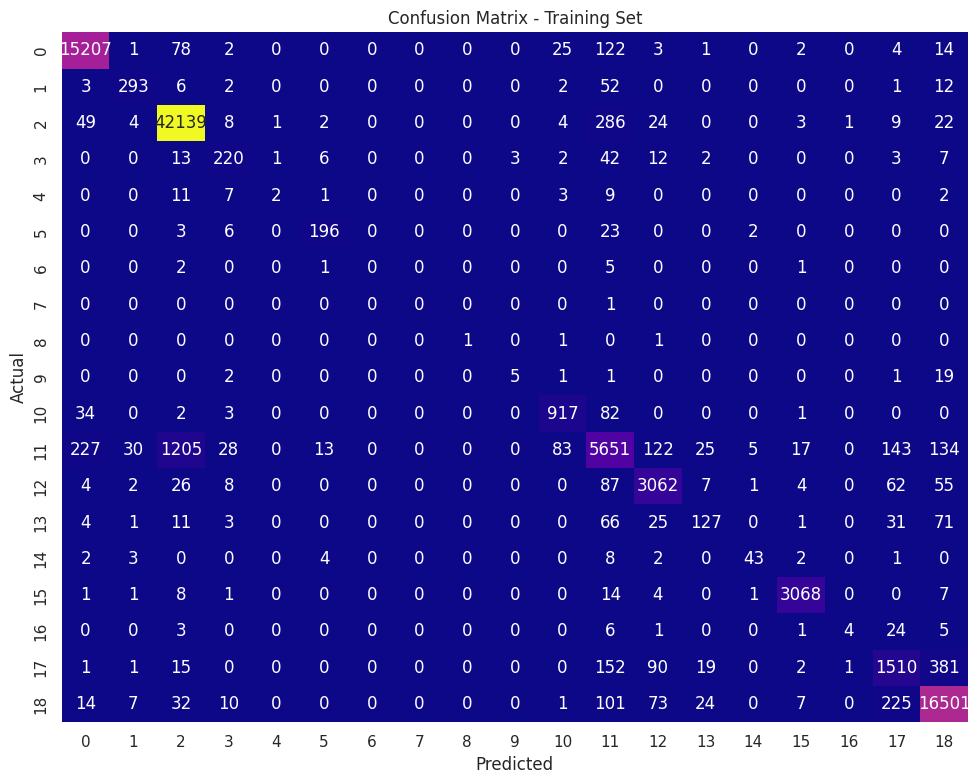


Iteration 4: Hyperparameters - Num Epochs: 50, Learning Rate: 0.001, Optimizer: SGD
Epoch 1/50, Train Loss: 0.1541, Train Accuracy: 0.9559, Validation Loss: 0.2131, Validation Accuracy: 0.9391
Epoch 2/50, Train Loss: 0.1500, Train Accuracy: 0.9570, Validation Loss: 0.2129, Validation Accuracy: 0.9401
Epoch 3/50, Train Loss: 0.1486, Train Accuracy: 0.9574, Validation Loss: 0.2125, Validation Accuracy: 0.9398
Epoch 4/50, Train Loss: 0.1477, Train Accuracy: 0.9578, Validation Loss: 0.2128, Validation Accuracy: 0.9414
Epoch 5/50, Train Loss: 0.1470, Train Accuracy: 0.9582, Validation Loss: 0.2123, Validation Accuracy: 0.9414
Epoch 6/50, Train Loss: 0.1463, Train Accuracy: 0.9582, Validation Loss: 0.2147, Validation Accuracy: 0.9410
Epoch 7/50, Train Loss: 0.1461, Train Accuracy: 0.9582, Validation Loss: 0.2167, Validation Accuracy: 0.9398
Epoch 8/50, Train Loss: 0.1459, Train Accuracy: 0.9586, Validation Loss: 0.2138, Validation Accuracy: 0.9398
Epoch 9/50, Train Loss: 0.1455, Train Accur

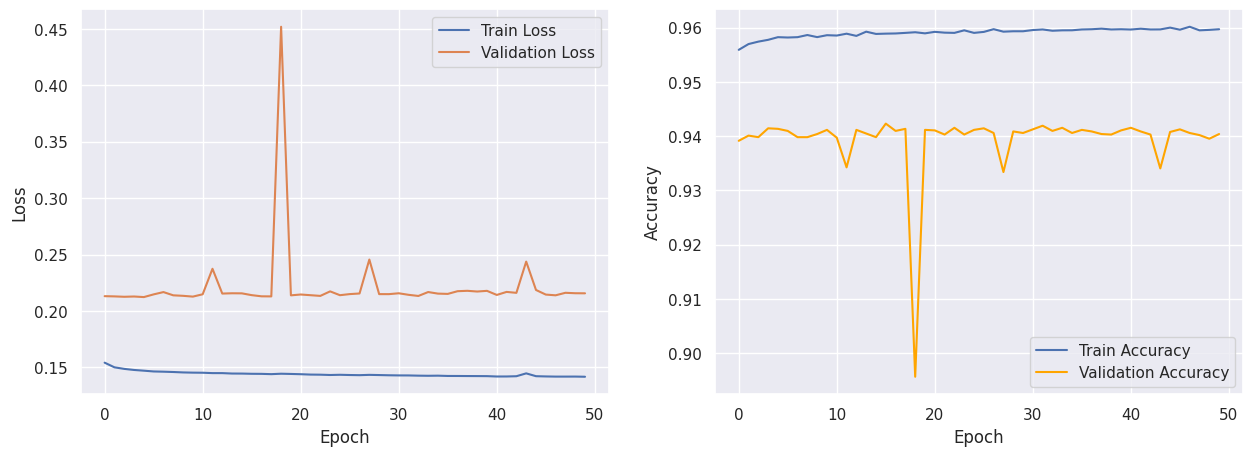

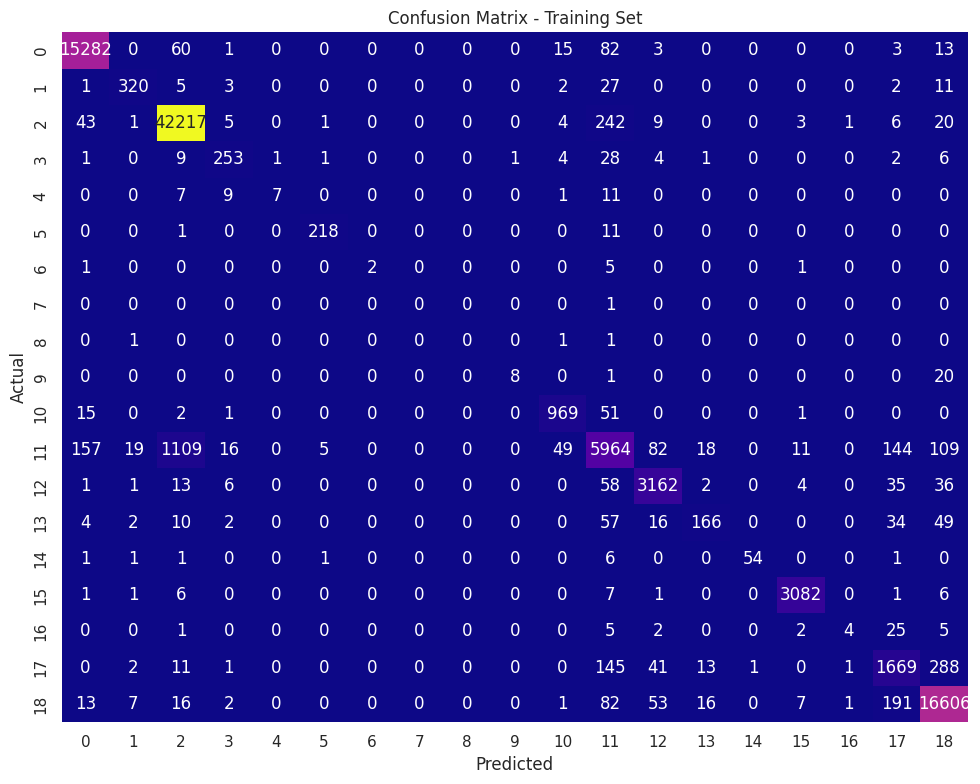


Iteration 5: Hyperparameters - Num Epochs: 50, Learning Rate: 0.01, Optimizer: Adam
Epoch 1/50, Train Loss: 0.3308, Train Accuracy: 0.9011, Validation Loss: 0.3048, Validation Accuracy: 0.9071
Epoch 2/50, Train Loss: 0.2925, Train Accuracy: 0.9134, Validation Loss: 0.4255, Validation Accuracy: 0.8885
Epoch 3/50, Train Loss: 0.2795, Train Accuracy: 0.9174, Validation Loss: 0.3758, Validation Accuracy: 0.8829
Epoch 4/50, Train Loss: 0.2618, Train Accuracy: 0.9230, Validation Loss: 0.2735, Validation Accuracy: 0.9193
Epoch 5/50, Train Loss: 0.2507, Train Accuracy: 0.9277, Validation Loss: 0.2825, Validation Accuracy: 0.9164
Epoch 6/50, Train Loss: 0.2444, Train Accuracy: 0.9290, Validation Loss: 0.2249, Validation Accuracy: 0.9366
Epoch 7/50, Train Loss: 0.2332, Train Accuracy: 0.9328, Validation Loss: 0.2331, Validation Accuracy: 0.9326
Epoch 8/50, Train Loss: 0.2284, Train Accuracy: 0.9344, Validation Loss: 0.2290, Validation Accuracy: 0.9352
Epoch 9/50, Train Loss: 0.2252, Train Accur

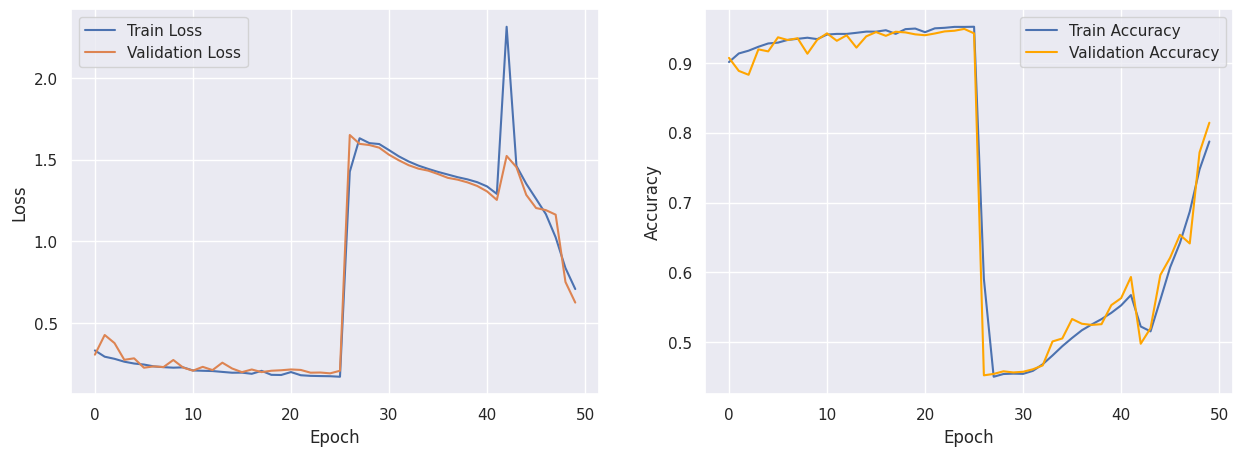

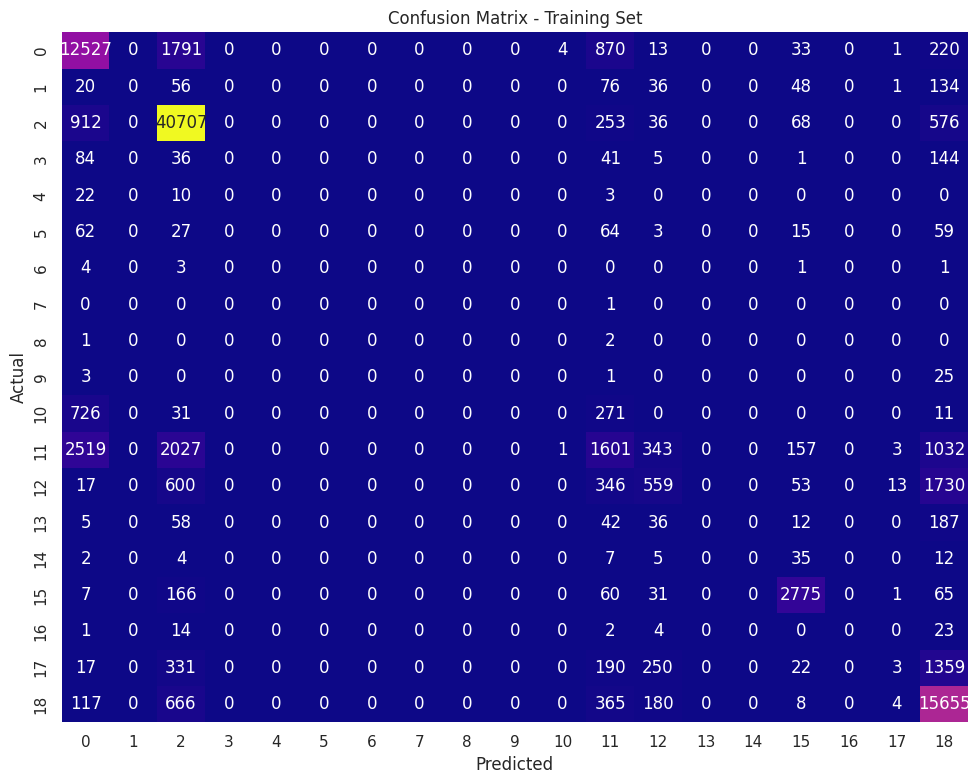


Iteration 6: Hyperparameters - Num Epochs: 50, Learning Rate: 0.01, Optimizer: SGD
Epoch 1/50, Train Loss: 0.6243, Train Accuracy: 0.8153, Validation Loss: 0.5903, Validation Accuracy: 0.8241
Epoch 2/50, Train Loss: 0.6092, Train Accuracy: 0.8207, Validation Loss: 0.6231, Validation Accuracy: 0.8117
Epoch 3/50, Train Loss: 0.6032, Train Accuracy: 0.8228, Validation Loss: 19.8920, Validation Accuracy: 0.0317
Epoch 4/50, Train Loss: 0.6395, Train Accuracy: 0.8175, Validation Loss: 4.1033, Validation Accuracy: 0.5513
Epoch 5/50, Train Loss: 0.5912, Train Accuracy: 0.8271, Validation Loss: 0.5526, Validation Accuracy: 0.8366
Epoch 6/50, Train Loss: 0.5817, Train Accuracy: 0.8290, Validation Loss: 0.5557, Validation Accuracy: 0.8335
Epoch 7/50, Train Loss: 0.5761, Train Accuracy: 0.8309, Validation Loss: 0.5632, Validation Accuracy: 0.8315
Epoch 8/50, Train Loss: 0.5729, Train Accuracy: 0.8330, Validation Loss: 1.5826, Validation Accuracy: 0.6304
Epoch 9/50, Train Loss: 0.5691, Train Accur

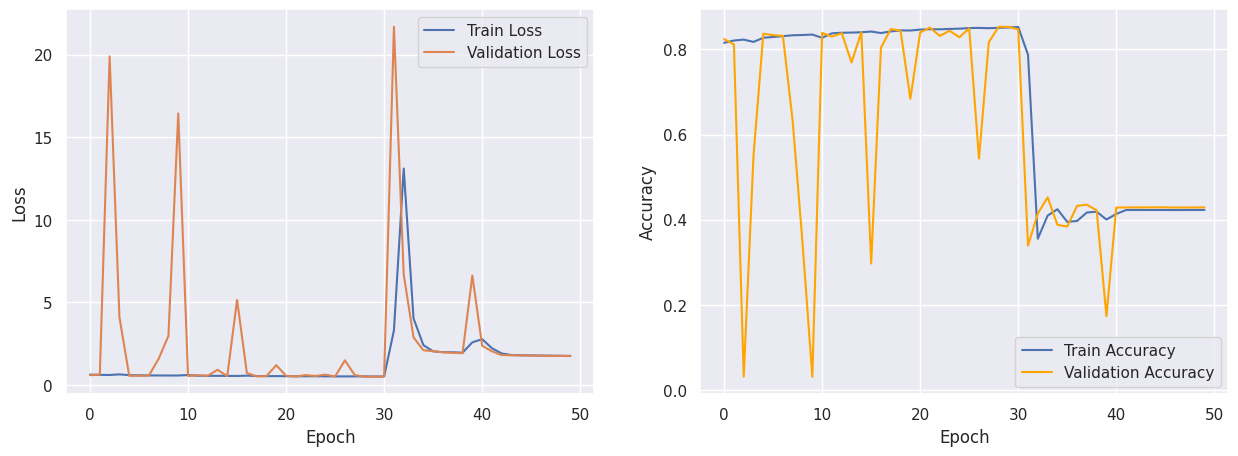

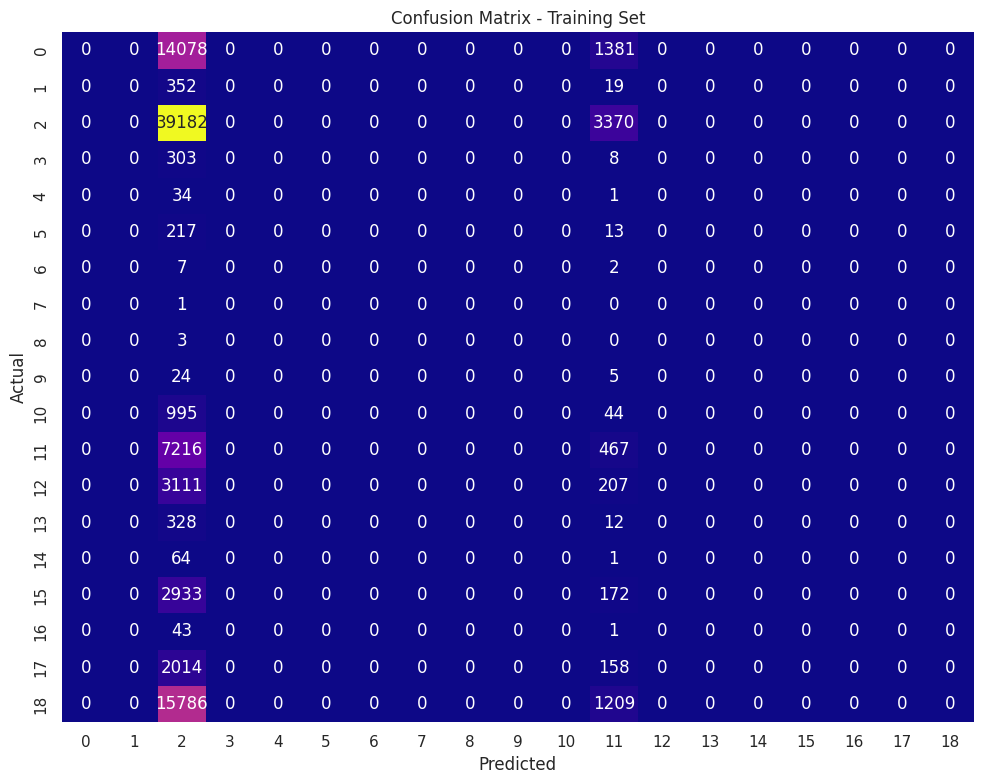


Best Hyperparameters:
{'num_epochs': 50, 'learning_rate': 0.01, 'optimizer': 'Adam'}

Best Metrics:
{'train_loss': 0.17288720042134748, 'val_loss': 0.19054966130825274, 'train_accuracy': 0.9514403643305852, 'val_accuracy': 0.9485505855250528}


In [92]:
# hyperparameter search space
param_space = {
    'num_epochs': [50],
    'learning_rate': [0.0001, 0.001, 0.01],
    'optimizer': [optim.Adam, optim.SGD]
}

# Store results for all trials
results = []

# parameterGrid from the hyperparameter search space
param_grid = list(product(param_space['num_epochs'], param_space['learning_rate'], param_space['optimizer']))

for i, (num_epochs, learning_rate, optimizer) in enumerate(param_grid):
    print(f"\nIteration {i + 1}: Hyperparameters - Num Epochs: {num_epochs}, Learning Rate: {learning_rate}, Optimizer: {optimizer.__name__}")

    # Train and evaluate the model
    model, metrics = train_evaluate_plot_model(lstm_model,
                                               train_loader=train_loader, val_loader=val_loader,
                                               optimizer=optimizer(lstm_model.parameters(), lr=learning_rate),
                                               num_epochs=num_epochs,
                                               learning_rate=learning_rate,
                                               device=device)

    # Store the results for this trial
    results.append({
        'hyperparameters': {'num_epochs': num_epochs, 'learning_rate': learning_rate, 'optimizer': optimizer.__name__},
        'model_state_dict': model.state_dict(),  # Save the model's state dict
        'metrics': metrics
    })

# best set of hyperparameters based on validation accuracy
best_result = min(results, key=lambda x: x['metrics']['val_loss'])
best_hyperparameters = best_result['hyperparameters']
best_metrics = best_result['metrics']
best_model_state_dict = best_result['model_state_dict']

print("\nBest Hyperparameters:")
print(best_hyperparameters)
print("\nBest Metrics:")
print(best_metrics)



Test Accuracy: 0.422


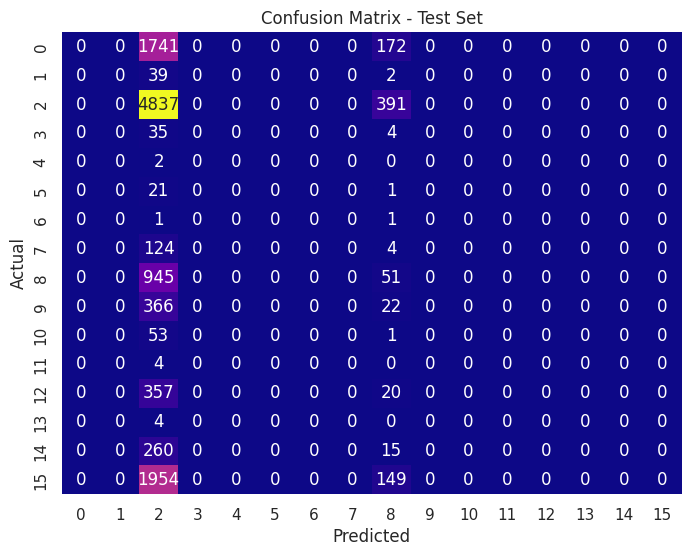

In [93]:
lstm_model.load_state_dict(best_model_state_dict)
# Test the best model with the test set
test_model(lstm_model, test_loader)

**Interpretation**

**Best Hyperparameters:**

- {'num_epochs': 50, 'learning_rate': 0.01, 'optimizer': 'Adam'}

**Best Metrics:**

- {'train_loss': 0.17288720042134748, 'val_loss': 0.19054966130825274, 'train_accuracy': 0.9514403643305852, 'val_accuracy': 0.9485505855250528}

- Test Accuracy = 0.422

The test results is clear indication of the overfitting of the model. The model performed well on train and val data; however, it might have overfitted on those datasets.
This takes us back to where we started. It is not the deficiency in the `NN` rather flaw in the data processing technique. The `Best_Params` from this tuning will be used to tune the `NN` and then we will to testing again with the combination of `best_hyparameters` from both tuning sections.

### 3.2.6. Network Tuning

LSTM layers and the number of units in each layer can be tuned. However, more layers and units can capture more complex patterns with an increased training time.

In the following cell, we are going to tune:


1. **Hidden Size (`hidden_size_list`):**
   - The number of units or neurons in the hidden state of each LSTM layer.


2. **Number of Layers (`num_layers_list`):**
   - The number of LSTM layers stacked on top of each other.

tuning these hyperparameters involves finding the optimal balance between model capacity and training efficiency.

Best Hyperparameters:

{'num_epochs': 50, 'learning_rate': 0.01, 'optimizer': 'Adam'}

In [ ]:
learning_rate = 0.01
# Hyperparameter search space
hidden_size_list = [64, 128, 256]
num_layers_list = [1, 2, 3]

# Number of trials
num_trials = len(hidden_size_list) * len(num_layers_list)

# Store results for all trials
results = []

for i, (hidden_size, num_layers) in enumerate(product(hidden_size_list, num_layers_list), start=1):
    print(f"\nTrial {i}/{num_trials}: Hidden Size - {hidden_size}, Num Layers - {num_layers}")

    # Create and train the LSTM model
    lstm_model = TimeSeriesLSTM(input_size=10, hidden_size=hidden_size, output_size=19, num_layers=num_layers).to(device)
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

    # Train and evaluate the model
    trained_model, metrics = train_evaluate_plot_model(lstm_model, train_loader, val_loader, optimizer, num_epochs=50, learning_rate=learning_rate, device=device)

    # Extract confusion matrix from metrics
    #confusion_matrix_data = metrics['confusion_matrix']

    # Store the results for this trial
    results.append({
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'metrics': metrics
    })

    # # Plot Confusion Matrix
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(confusion_matrix_data, annot=True, fmt='g', cmap='Blues', cbar=False)
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.title(f'Confusion Matrix - Trial {i}/{num_trials}')
    # plt.show()

# Find the best set of hyperparameters based on validation accuracy
best_result = min(results, key=lambda x: x['metrics']['val_loss'])
best_hidden_size = best_result['hidden_size']
best_num_layers = best_result['num_layers']
best_metrics = best_result['metrics']

print("\nBest Hyperparameters:")
print(f"Hidden Size: {best_hidden_size}, Num Layers: {best_num_layers}")
print("\nBest Metrics:")
print(best_metrics)


**Interpretation**



## 4. Model Performance - Comparison

This section will be a guide to summarize the performances of `MLP` and `LSTM` with different hyper-parameters/different versions to evaluate which parameter values improves the performance of the model.

### 4.1. Test Models with best parameters

**Best Parameters:**
- LSTM

    - {'Hidden Size': 256, 'Num Layers': 1}
    - {'num_epochs': 50, 'learning_rate': 0.01, 'optimizer': 'Adam'}

- MLP
    - {'Hidden Units': [128, 256], 'Dropout Rate': 0.1}
    - {'num_epochs': 50, 'learning_rate': 0.01, 'optimizer': 'SGD'}

In [ ]:
# Best Parameters for LSTM
best_lstm_params = {'Hidden Size': 256, 'Num Layers': 1}
best_lstm_optimizer_params = {'num_epochs': 50, 'learning_rate': 0.01, 'optimizer': optim.Adam}



# test LSTM model
best_lstm_model = TimeSeriesLSTM(input_size=10, hidden_size=best_lstm_params['Hidden Size'], output_size=19, num_layers=best_lstm_params['Num Layers']).to(device)
best_lstm_optimizer = best_lstm_optimizer_params['optimizer'](best_lstm_model.parameters(), lr=best_lstm_optimizer_params['learning_rate'])
best_lstm_model, lstm_metrics = train_evaluate_plot_model(best_lstm_model, train_loader, val_loader, best_lstm_optimizer, num_epochs=best_lstm_optimizer_params['num_epochs'], device=device)



Epoch 1/50, Train Loss: 1.6074, Train Accuracy: 0.4613, Validation Loss: 1.5181, Validation Accuracy: 0.5031


In [ ]:
test_model(best_lstm_model, test_loader)

**Interpretation**

The `Confusion Matrix` for test set looks good; however, I do not know, how to explain the automatic deletion of some of the class labels. This could possibly be due to the fact that some of the classes have very low number of labels that they cannot be dealt with at the data split.

In [ ]:
# Best Parameters for MLP
best_mlp_params = {'Hidden Units': [128, 256], 'Dropout Rate': 0.1}
best_mlp_optimizer_params = {'num_epochs': 50, 'learning_rate': 0.01, 'optimizer': optim.SGD}
# test MLP model
best_mlp_model = TimeSeriesMLP(input_size=620, output_size=19, hidden_units=best_mlp_params['Hidden Units'], dropout_rate=best_mlp_params['Dropout Rate']).to(device)
best_mlp_optimizer = best_mlp_optimizer_params['optimizer'](best_mlp_model.parameters(), lr=best_mlp_optimizer_params['learning_rate'])
best_mlp_model, mlp_metrics = train_evaluate_plot_model(best_mlp_model, train_loader, val_loader, best_mlp_optimizer, num_epochs=best_mlp_optimizer_params['num_epochs'], device=device)


In [ ]:
test_model(best_mlp_model, test_loader)

**Interpretation**

The `Confusion Matrix` for test set looks good; however, I do not know, how to explain the automatic deletion of some of the class labels. This could possibly be due to the fact that some of the classes have very low number of labels that they cannot be dealt with at the data split.

### 4.2. Comparison Table



We have used `CrossEntropyloss()` as the loss function and as the evaluation metrics as well to choose the best epoch.

Here's a comparison table for MLP and LSTM models:

**Number of trainable parameters for LSTM:**

{Number of Trainable Parameters:  20691}

**Number of trainable parameters for MLP:**

{Number of Trainable Parameters: 229,651}


**Best Hyperparameters for MLP `V2`:**

{'num_epochs': 50, 'learning_rate': 0.01, 'optimizer': 'SGD'}

**Best Hyperparameters for LSTM `V2`:**

{'num_epochs': 50, 'learning_rate': 0.01, 'optimizer': 'Adam'}

**Best Hyperparameters for MLP `V3`:**

{'Hidden Units': [128, 256], 'Dropout Rate': 0.1}

**Best Hyperparameters for LSTM `V3`:**

{'num_epochs': 50, 'learning_rate': 0.01, 'optimizer': 'Adam'}

The best params might be couterintuitive and very well be a glitch because of the unusual technique to estimate them

***Reminder:***

__Version1__: Default parameters

__version2__: Hyperparameter tuning

__Version3__: Network tuned on the best model from `version two`

***These results are bases of lowest Val_loss***

| Model Type | Hyperparameter Configuration | Number of Epochs | Train Accuracy | Train Loss | Validation Accuracy | Validation Loss | Test Accuracy |
|------------|-----------------------------|------------------|-----------------|------------|-----------------------|------------------|---------------|
| MLP `version one` | Default hyperparameters | 50 | 0.935 | 0.215 | 0.930 | 0.242 | 0.927 |
| MLP `version two` | Best hyperparameters found | 50 | 0.936 | 0.223 | 0.926 | 0.246 | 0.927|
| MLP `version three` | Best hyperparameters found | 50 | 0.945 | 0.154 | 0.936 | 0.188 | 0.887 |
| LSTM `version one` | Default hyperparameters | 50 | 0.925 | 0.25 | 0.922 | 0.26 | 0.916 |
| LSTM `version two` | Best hyperparameters found | 50 | 0.951 | 0.173 | 0.949 | 0.190 | 0.422 |
| LSTM `version three` | Best hyperparameters found | 50 | 0.956 | 0.232 | 0.962 | 0.186 | 0.923 |




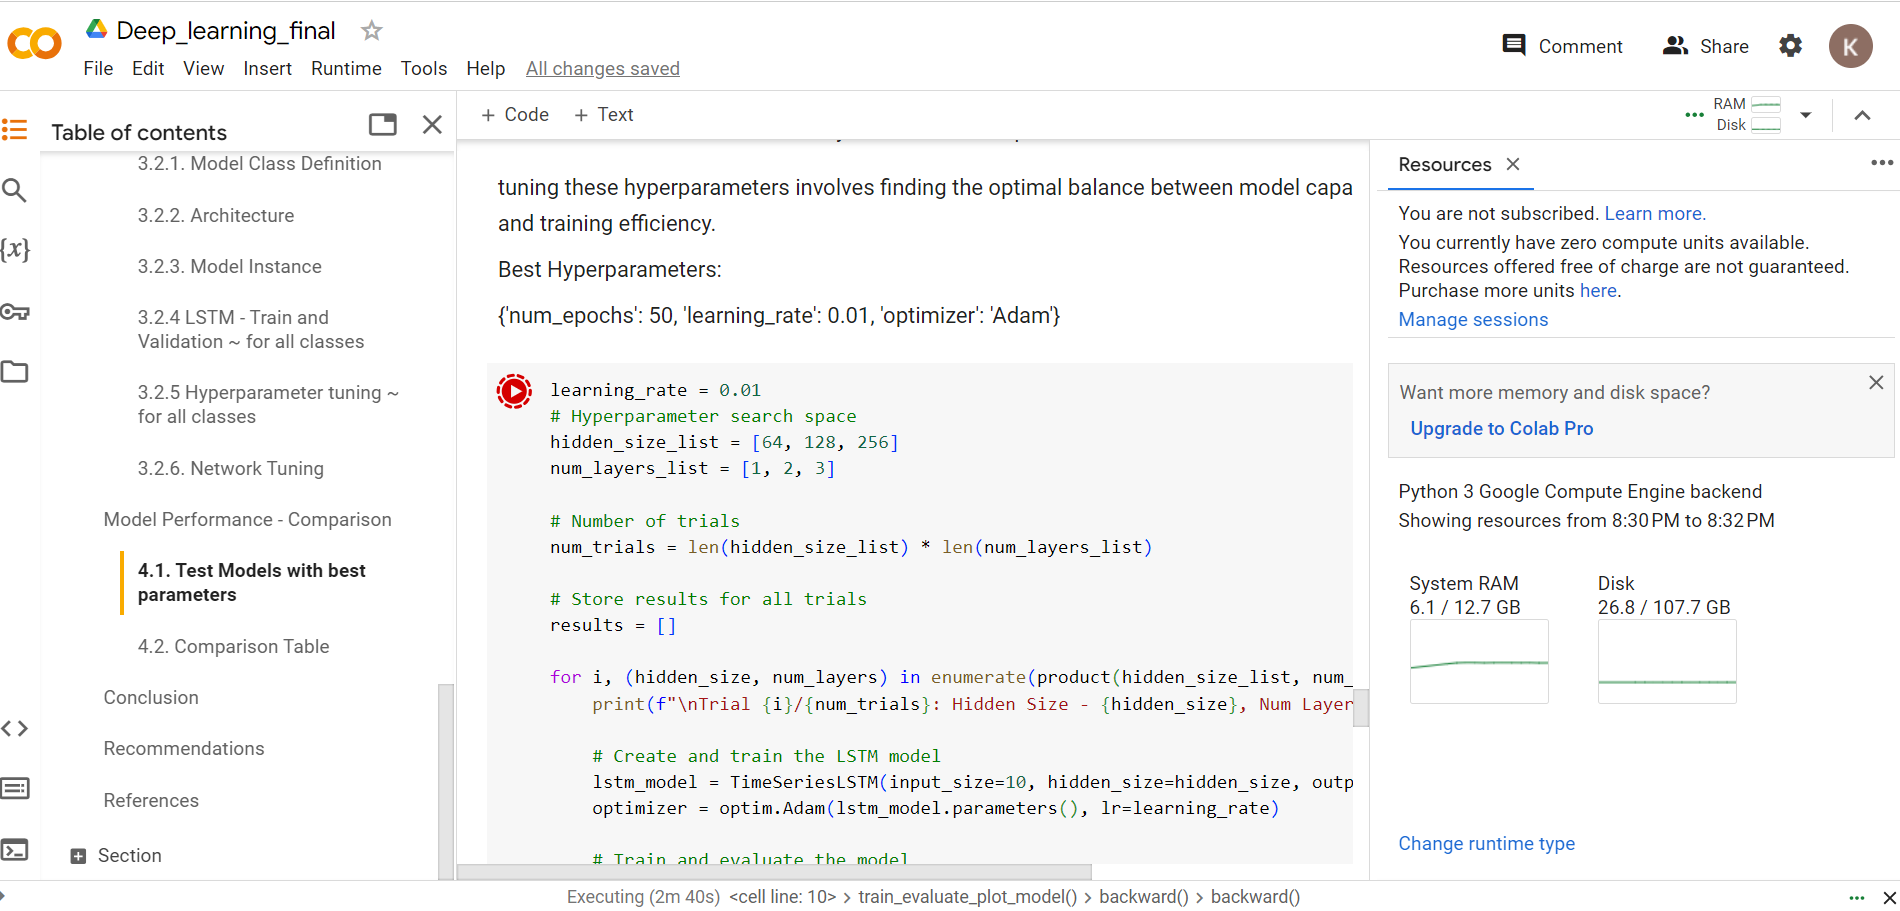

Unfortunately, I ran out of `google_units` to re-compute/estimate the best models. I have tried to rerun all the cells to re-compute metrics for the best models with some adjustments made in the previous cells.

**Results for `V3`**

The values are not guranteed as they are computed w.r.t previous parameter settings.

## 5. Conclusion

The performance of the models based on the graph and values is pretty good, but when you look at the confusion matrix. The results are poor, especially without tuning and regularization.

The initial and actual plan was to run the model on all the available dataset - labels and then remove the observations that correspond to the minority class or label with a count of less than 100.

Unfortunately, there were some mistakes made during the class definition of `Customized Dataset` and `reindexing` new filtered labels. Due to these unforseen circumstances, the notebook is incomplete and did not present the complete concept or idea that was planned.

There is huge observations for `winter_wheat`, `corn`, `meadow`, `winter_rapeseed`, `sunflowers`, and `unknown` classes. Other classes are very few in numbers. Therefore, it is important to perform feature engineering, to classfiy majority and minority classess in order to improve model's perfomance in identifying/classifying the crop-type.

It is clear that LSTM performed better than MLP, especially because it is a special design of RNN to handle timeseries data. It is clear from the

There are so many things that have could have done better, starting with the `Customized Dataset Class` to cleaning `Tuning` and `Regularization`. It is a learning curve, throughout the project, I learned how dataloader actually works and what do hyperparameters do to a model.

All in all, the models did perform good on paper; however, there is a lot of room for improvement. In addition, even after the submission of this notebook, I am going to look back and try different methods to improve the learning task.

## Recommendations



Looking at the results and performance of the models, I would like to recommend few things for my further exploration and for whoever is interested:


`** Pre-Processing ** of the data is an essential step and if we make mistakes there, the whole process goes haywire. I think, I have made several mistakes in data pre-processing and the whole notebook will look a lot different once that part is fixed`

- Split with `stratification` or `groups`. This will make sure that you have representation for each **label/class** across train/val/test datasets.
- Merge the minority classess from the very start of EDA process. It will be easier to handle at that stage, also, it will give you a better performance. It is usually recommended that we take good number of obs especially when doing DL ~ 100 observations. Classes/labels with less than that will only create noise and disrupt the model evaluation process. **please see confusion matrices for my test_models**
- Dropping minority class is another solid solution to deal with the problem. Since the dataset in case has many observations and we can afford to drop a few hundred of them. This will work well but it may cause a lot of information lose, as you would technically be disregarding the dropped class of crops.
- Hyperparameter tuning technique could be improved, implementations, like `optuna` and `skorch` could be implemented to set a param_grid and find the best set of hyperparameters.
- At last, an implementation of all the above considerations will improve the model's performance with significantly lower loss.

## 6. References


- PyTorch Hyperparameter Tuning Tutorial: [Link](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)
- PyTorch Vision Datasets Documentation: [Link](https://pytorch.org/vision/main/datasets.html)
- Medium - Multi-Layer Perceptron (MLP) in PyTorch: [Link](https://webcache.googleusercontent.com/search?q=cache:https://medium.com/deep-learning-study-notes/multi-layer-perceptron-mlp-in-pytorch-21ea46d50e62)
- Medium - Dealing with Imbalanced Data in Classification: [Link](https://webcache.googleusercontent.com/search?q=cache:https://medium.com/game-of-bits/how-to-deal-with-imbalanced-data-in-classification-bd03cfc66066)
- Medium - Time Series Classification with Convolutions: [Link](https://webcache.googleusercontent.com/search?q=cache:https://medium.com/analytics-vidhya/time-series-classification-with-convolutions-ed5cb33b1e3b)
- KDnuggets - Hyperparameter Tuning: Grid Search vs Random Search in Python: [Link](https://www.kdnuggets.com/2022/10/hyperparameter-tuning-grid-search-random-search-python.html)
- Debugger Cafe - Hyperparameter Search with PyTorch and Skorch: [Link](https://debuggercafe.com/hyperparameter-search-with-pytorch-and-skorch/)
- Scikit-Learn ConfusionMatrixDisplay Documentation: [Link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)
- Nyborg, J., Pelletier, C., Lefèvre, S., & Assent, I. (2022). Timematch: Unsupervised cross-region adaptation by temporal shift estimation. ISPRS Journal of Photogrammetry and Remote Sensing, 188, 301–313. [DOI](https://doi.org/10.1016/j.isprsjprs.2022.04.018)
- ChatGPT-AI - It has been used to refine the code structure and enhance the plots on some occasions.